<a href="https://colab.research.google.com/github/RainiBenaiah/AsaliAsPossible/blob/master/AsPossibleRL12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# CELL 1: Essential Imports - Asali Beehive RL Management System
# ============================================================================

print("="*60)
print("ASALI BEEHIVE RL MANAGEMENT SYSTEM")
print("="*60)
print("\nLoading dependencies...\n")

# ============================================================================
# AUTO-INSTALL MISSING PACKAGES
# ============================================================================
import subprocess
import sys

def install_package(package):
    """Install package if not available"""
    try:
        __import__(package.split('[')[0].replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"Installed {package}")

# Install required packages
required_packages = [
    'audiomentations',
    'librosa',
    'soundfile',
    'stable-baselines3[extra]',
    'tensorflow', # Added tensorflow to the required packages
]

for package in required_packages:
    install_package(package)

# ============================================================================
# CORE PYTHON LIBRARIES
# ============================================================================
print("Loading core libraries...")

import os
import sys
import time
import json
import pickle
import warnings
import shutil
from pathlib import Path
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from tqdm import tqdm
import random

warnings.filterwarnings('ignore')

# ============================================================================
# DATA MANIPULATION
# ============================================================================
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import butter, filtfilt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error
)
from sklearn.utils import class_weight

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn", "-q"])
    from imblearn.over_sampling import SMOTE

# ============================================================================
# AUDIO PROCESSING
# ============================================================================
import librosa
import librosa.display
import soundfile as sf
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch,
    PitchShift, Shift
)

# ============================================================================
# DEEP LEARNING
# ============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    GlobalAveragePooling1D, GlobalAveragePooling2D,
    LSTM, Bidirectional, Flatten, Reshape, Concatenate
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow GPU available: {len(gpus)} device(s)")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("TensorFlow running on CPU")

# ============================================================================
# REINFORCEMENT LEARNING
# ============================================================================
try:
    import gymnasium as gym
    from gymnasium import spaces
except ImportError:
    import gym
    from gym import spaces

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# GOOGLE DRIVE (if in Colab)
# ============================================================================
try:
    from google.colab import drive
    IN_COLAB = True
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
        print("Google Drive mounted")
    else:
        print("Google Drive already mounted")
except ImportError:
    IN_COLAB = False
    print("Running locally")

# ============================================================================
# PROJECT PATHS
# ============================================================================
print("\nSetting up project paths...")

if IN_COLAB:
    BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
    WORK_DIR = Path('/content/asali_work')
else:
    BASE_PATH = Path.cwd() / 'AsaliAsPossible'
    WORK_DIR = Path.cwd() / 'asali_work'

WORK_DIR.mkdir(parents=True, exist_ok=True)

# Project structure
PROJECT_DIRS = {
    'audio_preprocessed': WORK_DIR / 'audio_preprocessed',
    'audio_features': WORK_DIR / 'audio_features',
    'sensor_data': WORK_DIR / 'sensor_data',
    'sensor_preprocessed': WORK_DIR / 'sensor_preprocessed',
    'sound_models': WORK_DIR / 'models' / 'sound',
    'timeseries_models': WORK_DIR / 'models' / 'timeseries',
    'rl_models': WORK_DIR / 'models' / 'rl',
    'results': WORK_DIR / 'results',
    'visualizations': WORK_DIR / 'visualizations',
    'checkpoints': WORK_DIR / 'checkpoints',
}

for path in PROJECT_DIRS.values():
    path.mkdir(parents=True, exist_ok=True)

print("Project directories created")

# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Audio settings
AUDIO_CONFIG = {
    'sample_rate': 22050,
    'duration': 10,
    'n_mfcc': 40,
    'n_fft': 2048,
    'hop_length': 512,
    'n_mels': 128,
}

# Time-series settings
TIMESERIES_CONFIG = {
    'aggregation': '1H',
    'lookback': 48,
    'forecast_horizon': 24,
}

# RL settings
RL_CONFIG = {
    'n_hives': 3,
    'episode_length': 720,
    'n_actions': 8,
    'training_timesteps': 500000,
}

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def save_json(obj, filepath):
    with open(filepath, 'w') as f:
        json.dump(obj, f, indent=4)

def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

# Make directories globally available
globals().update(PROJECT_DIRS)

# ============================================================================
# STATUS
# ============================================================================
print("\n" + "="*60)
print("ALL IMPORTS LOADED SUCCESSFULLY")
print("="*60)

print(f"\nPython: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"Working Directory: {WORK_DIR}")
print(f"Base Path: {BASE_PATH}")

print("\n" + "="*60)
print("READY FOR PIPELINE")
print("="*60)

ASALI BEEHIVE RL MANAGEMENT SYSTEM

Loading dependencies...

Loading core libraries...
TensorFlow running on CPU
Mounted at /content/drive
Google Drive mounted

Setting up project paths...
Project directories created

ALL IMPORTS LOADED SUCCESSFULLY

Python: 3.12.12
NumPy: 2.0.2
TensorFlow: 2.20.0
Working Directory: /content/asali_work
Base Path: /content/drive/MyDrive/AsaliAsPossible

READY FOR PIPELINE


In [ ]:
# ============================================================================
# CELL 2: Find & Extract Audio Data from Drive
# ============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from tqdm import tqdm
import shutil

print("="*60)
print("AUDIO DATA EXTRACTION FROM DRIVE")
print("="*60)

# ============================================================================
# 1. SEARCH FOR ZIP FILES IN DRIVE
# ============================================================================

print("\nStep 1: Searching for audio ZIP files in Drive...")

# Search locations
search_paths = [
    BASE_PATH,
    BASE_PATH / 'datasets',
    BASE_PATH / 'audio',
    BASE_PATH / 'data',
]

zip_files = []

for search_path in search_paths:
    if not search_path.exists():
        continue

    print(f"Scanning: {search_path}")
    found_zips = list(search_path.rglob('*.zip'))

    for zip_file in found_zips:
        # Look for audio-related zips
        zip_name_lower = zip_file.name.lower()
        if any(keyword in zip_name_lower for keyword in ['sound', 'audio', 'bee', 'nuhive', 'wav']):
            zip_files.append({
                'path': zip_file,
                'name': zip_file.name,
                'size_mb': zip_file.stat().st_size / (1024*1024)
            })
            print(f"  Found: {zip_file.name} ({zip_file.stat().st_size / (1024*1024):.1f} MB)")

if len(zip_files) == 0:
    print("\nNo ZIP files found. Searching for direct audio folders...")

    # Check for already extracted folders
    possible_audio_dirs = [
        BASE_PATH / 'sound_files',
        BASE_PATH / 'nuhive_processed',
        BASE_PATH / 'root',
        BASE_PATH / 'audio_files',
        BASE_PATH / 'bee_sounds',
    ]

    for audio_dir in possible_audio_dirs:
        if audio_dir.exists():
            wav_count = len(list(audio_dir.rglob('*.wav')))
            if wav_count > 0:
                print(f"  Found existing folder: {audio_dir} ({wav_count} WAV files)")

    # List all contents of BASE_PATH
    print(f"\nContents of {BASE_PATH}:")
    if BASE_PATH.exists():
        for item in sorted(BASE_PATH.iterdir())[:20]:
            item_type = "DIR" if item.is_dir() else "FILE"
            size = f"({item.stat().st_size / (1024*1024):.1f} MB)" if item.is_file() else ""
            print(f"  [{item_type}] {item.name} {size}")
    else:
        print(f"  ERROR: {BASE_PATH} does not exist!")

    raise FileNotFoundError(
        f"No audio ZIP files found in Drive.\n"
        f"Please check:\n"
        f"  1. Drive is mounted correctly\n"
        f"  2. Audio files/ZIPs exist in: {BASE_PATH}\n"
        f"  3. File names contain: sound, audio, bee, nuhive, or wav"
    )

print(f"\nFound {len(zip_files)} ZIP files")

# ============================================================================
# 2. EXTRACT ZIP FILES TO WORKING DIRECTORY
# ============================================================================

print("\nStep 2: Extracting ZIP files to working directory...")

extraction_dir = WORK_DIR / 'extracted_audio'
extraction_dir.mkdir(parents=True, exist_ok=True)

extracted_folders = []

for zip_info in zip_files:
    zip_path = zip_info['path']
    zip_name = zip_info['name']

    print(f"\nExtracting: {zip_name}")
    print(f"  Size: {zip_info['size_mb']:.1f} MB")

    # Create extraction subfolder
    extract_subfolder = extraction_dir / zip_path.stem

    if extract_subfolder.exists() and len(list(extract_subfolder.rglob('*.wav'))) > 0:
        existing_wavs = len(list(extract_subfolder.rglob('*.wav')))
        print(f"  Already extracted ({existing_wavs} WAV files), skipping...")
        extracted_folders.append(extract_subfolder)
        continue

    extract_subfolder.mkdir(parents=True, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Get list of files
            file_list = zip_ref.namelist()
            wav_files = [f for f in file_list if f.lower().endswith('.wav')]

            print(f"  Contains {len(wav_files)} WAV files")
            print(f"  Extracting to: {extract_subfolder}")

            # Extract with progress bar
            for file in tqdm(file_list, desc="  Extracting", leave=False):
                zip_ref.extract(file, extract_subfolder)

            print(f"  Extraction complete")
            extracted_folders.append(extract_subfolder)

    except Exception as e:
        print(f"  ERROR extracting {zip_name}: {e}")
        continue

print(f"\nExtracted {len(extracted_folders)} ZIP files")

# ============================================================================
# 3. SCAN EXTRACTED AUDIO FILES
# ============================================================================

print("\nStep 3: Scanning extracted audio files...")

audio_files = []

for folder in extracted_folders:
    print(f"\nScanning: {folder.name}")
    wav_files = list(folder.rglob('*.wav'))
    print(f"  Found {len(wav_files)} WAV files")

    for file_path in tqdm(wav_files, desc=f"  Processing {folder.name}", leave=False):
        audio_files.append({
            'path': str(file_path),
            'filename': file_path.name,
            'dataset': folder.name,
            'subfolder': file_path.parent.name,
            'size_mb': file_path.stat().st_size / (1024*1024)
        })

if len(audio_files) == 0:
    raise ValueError("No audio files found after extraction!")

audio_df = pd.DataFrame(audio_files)

print(f"\nTotal audio files found: {len(audio_df)}")
print(f"Total size: {audio_df['size_mb'].sum() / 1024:.2f} GB")

# ============================================================================
# 4. REMOVE DUPLICATES
# ============================================================================

print("\nStep 4: Removing duplicates...")

initial_count = len(audio_df)
duplicates = audio_df[audio_df.duplicated(subset='filename', keep=False)]
print(f"Duplicate filenames: {len(duplicates)}")

audio_df_clean = audio_df.drop_duplicates(subset='filename', keep='first')
removed = initial_count - len(audio_df_clean)
print(f"Removed {removed} duplicates")
print(f"Unique files: {len(audio_df_clean)}")

# ============================================================================
# 5. ADD LABELS
# ============================================================================

print("\nStep 5: Adding labels from folder structure...")

def get_label_from_path(path_str):
    """Extract label from file path"""
    path_lower = path_str.lower()

    if 'noqueen' in path_lower or 'no_queen' in path_lower or 'queenless' in path_lower:
        return 'queenless'
    elif 'nobee' in path_lower or 'no_bee' in path_lower or 'empty' in path_lower:
        return 'inactive'
    elif 'bee' in path_lower or 'active' in path_lower or 'healthy' in path_lower or 'sol' in path_lower:
        return 'active'
    else:
        return 'unknown'

audio_df_clean['label'] = audio_df_clean['path'].apply(get_label_from_path)

print("\nLabel distribution:")
for label, count in audio_df_clean['label'].value_counts().items():
    print(f"  {label:20s}: {count:6d} files")

# ============================================================================
# 6. SAVE MANIFEST & STATISTICS
# ============================================================================

print("\nStep 6: Saving manifest and statistics...")

manifest_path = WORK_DIR / 'clean_audio_manifest.csv'
audio_df_clean.to_csv(manifest_path, index=False)
print(f"Manifest saved: {manifest_path}")

stats = {
    'total_files': len(audio_df_clean),
    'total_size_gb': audio_df_clean['size_mb'].sum() / 1024,
    'avg_size_mb': audio_df_clean['size_mb'].mean(),
    'files_per_dataset': audio_df_clean['dataset'].value_counts().to_dict(),
    'files_per_label': audio_df_clean['label'].value_counts().to_dict(),
    'duplicates_removed': removed,
    'zip_files_extracted': len(zip_files),
}

stats_path = WORK_DIR / 'audio_stats.json'
save_json(stats, stats_path)
print(f"Statistics saved: {stats_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("AUDIO DATA EXTRACTION COMPLETE")
print("="*60)

print(f"\nExtracted and cataloged:")
print(f"  ZIP files processed: {len(zip_files)}")
print(f"  Total audio files:   {stats['total_files']}")
print(f"  Unique files:        {len(audio_df_clean)}")
print(f"  Total size:          {stats['total_size_gb']:.2f} GB")
print(f"  Duplicates removed:  {stats['duplicates_removed']}")

print(f"\nDatasets:")
for dataset, count in stats['files_per_dataset'].items():
    print(f"  {dataset:30s}: {count:6d} files")

print(f"\nLabels:")
for label, count in stats['files_per_label'].items():
    print(f"  {label:20s}: {count:6d} files")

print(f"\nFiles extracted to: {extraction_dir}")
print(f"Manifest: {manifest_path}")
print("="*60)

AUDIO DATA EXTRACTION FROM DRIVE

Step 1: Searching for audio ZIP files in Drive...
Scanning: /content/drive/MyDrive/AsaliAsPossible
  Found: nuhive_processed.zip (2576.6 MB)
  Found: sound_files.zip (19718.0 MB)

Found 2 ZIP files

Step 2: Extracting ZIP files to working directory...

Extracting: nuhive_processed.zip
  Size: 2576.6 MB
  Contains 13792 WAV files
  Extracting to: /content/asali_work/extracted_audio/nuhive_processed


  Extraction complete

Extracting: sound_files.zip
  Size: 19718.0 MB
  Contains 7100 WAV files
  Extracting to: /content/asali_work/extracted_audio/sound_files


  Extraction complete

Extracted 2 ZIP files

Step 3: Scanning extracted audio files...

Scanning: nuhive_processed
  Found 13792 WAV files



Scanning: sound_files
  Found 7100 WAV files



Total audio files found: 20892
Total size: 25.05 GB

Step 4: Removing duplicates...
Duplicate filenames: 0
Removed 0 duplicates
Unique files: 20892

Step 5: Adding labels from folder structure...

Label distribution:
  unknown             :   7100 files
  queenless           :   6165 files
  active              :   5473 files
  inactive            :   2154 files

Step 6: Saving manifest and statistics...
Manifest saved: /content/asali_work/clean_audio_manifest.csv
Statistics saved: /content/asali_work/audio_stats.json

AUDIO DATA EXTRACTION COMPLETE

Extracted and cataloged:
  ZIP files processed: 2
  Total audio files:   20892
  Unique files:        20892
  Total size:          25.05 GB
  Duplicates removed:  0

Datasets:
  nuhive_processed              :  13792 files
  sound_files                   :   7100 files

Labels:
  unknown             :   7100 files
  queenless           :   6165 files
  active              :   5473 files
  inactive            :   2154 files

Files extracte

INSPECTING UNKNOWN/UNLABELED AUDIO FILES

Step 1: Loading manifest...
Total files in manifest: 20892
Unknown files: 7100
Percentage: 34.0%

Step 2: Analyzing folder structure...

Dataset distribution:
dataset
sound_files    7100
Name: count, dtype: int64

Subfolder distribution:
  sound_files                             :   7100 files

Step 3: Checking filename patterns...

Sample filenames:
   1. 2022-06-30--03-50-31_2__segment2.wav
   2. 2022-07-11--07-27-46_2__segment5.wav
   3. 2022-06-09--15-05-10_1__segment1.wav
   4. 2022-06-15--05-32-54_2__segment2.wav
   5. 2022-06-25--19-01-01_2__segment1.wav
   6. 2022-07-07--19-55-27_1__segment2.wav
   7. 2022-07-10--18-36-58_2__segment2.wav
   8. 2022-06-30--17-39-21_2__segment1.wav
   9. 2022-07-04--20-46-42_1__segment5.wav
  10. 2022-06-11--14-30-02_1__segment2.wav
  11. 2022-06-26--06-51-07_2__segment1.wav
  12. 2022-06-26--20-40-16_1__segment2.wav
  13. 2022-06-24--18-55-41_2__segment1.wav
  14. 2022-06-25--20-00-05_2__segment4.wav
  1

Analyzing: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]



Audio properties summary:
       duration  sample_rate  max_amplitude  rms_energy        zcr
count      50.0         50.0      50.000000   50.000000  50.000000
mean        5.0      22050.0       0.339328    0.064495   0.035464
std         0.0          0.0       0.340127    0.044159   0.007729
min         5.0      22050.0       0.088196    0.019931   0.021080
25%         5.0      22050.0       0.162552    0.040007   0.031134
50%         5.0      22050.0       0.200925    0.049717   0.033117
75%         5.0      22050.0       0.252003    0.064274   0.040020
max         5.0      22050.0       1.532448    0.202690   0.053144

Potentially silent files: 0

Step 6: Visualizing sample spectrograms...


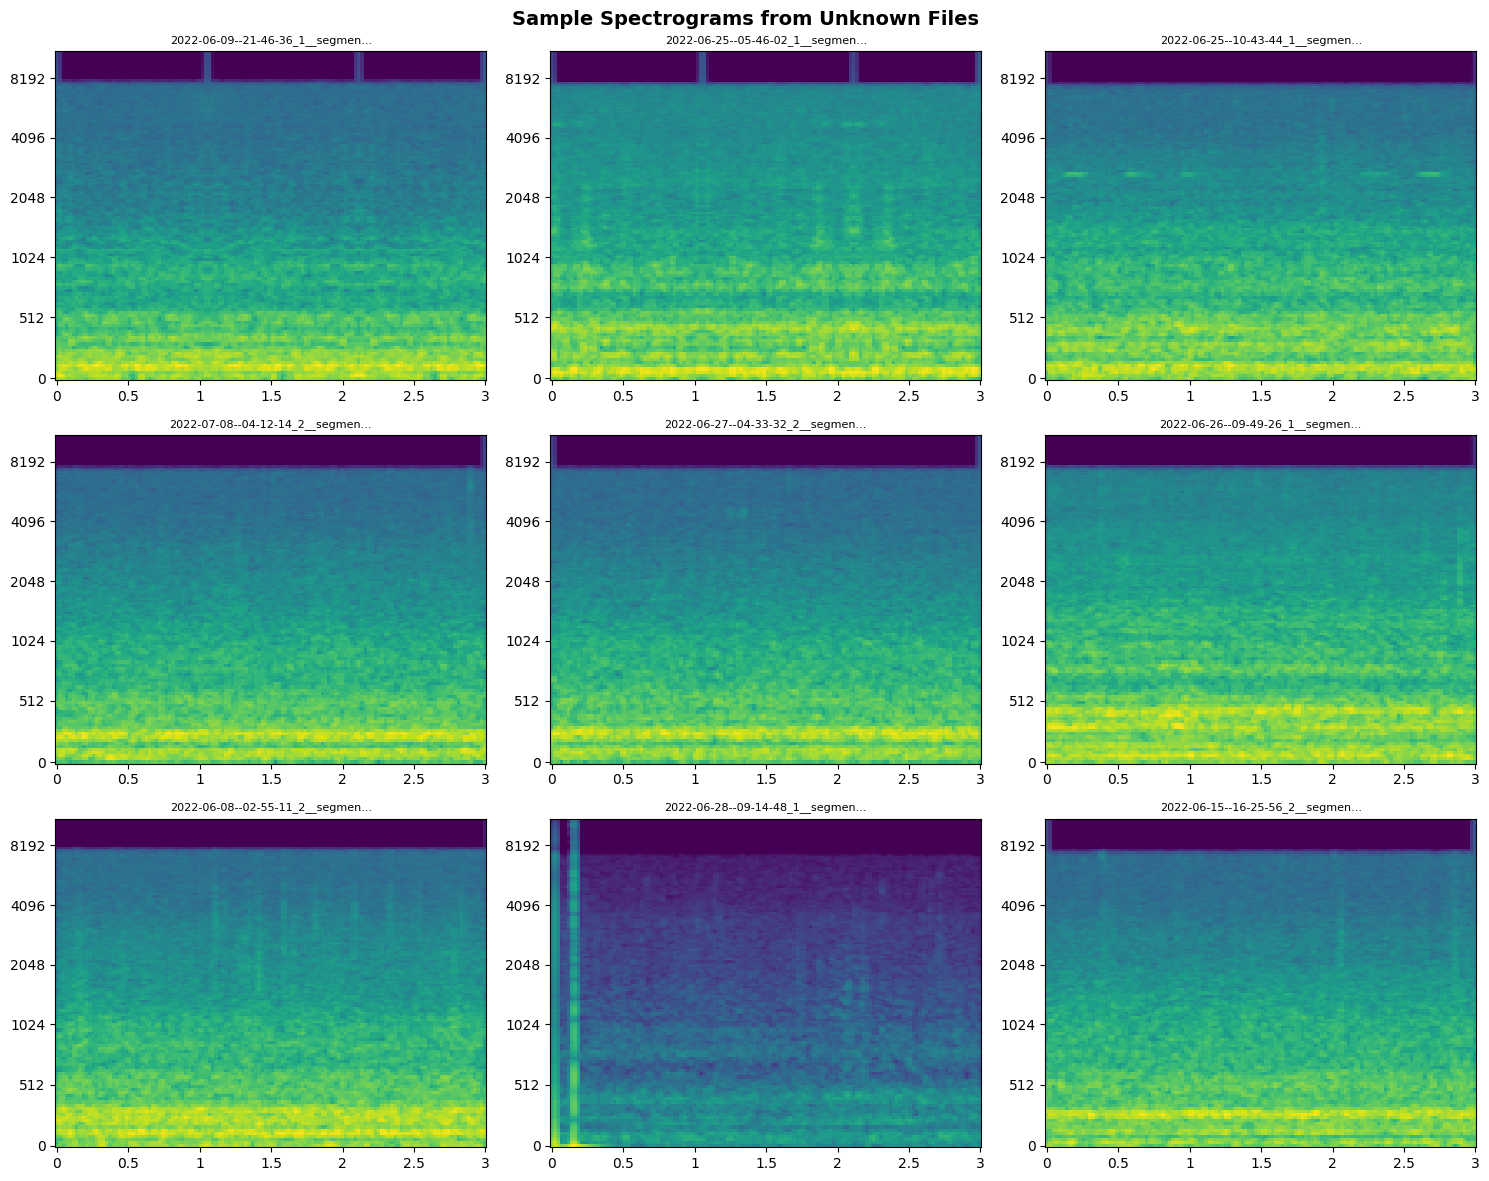

Visualization saved: /content/asali_work/visualizations/unknown_files_spectrograms.png

RECOMMENDATIONS

File usability assessment:
  Audio content present: Yes
  Consistent properties: Yes
  Single source dataset: Yes

Options:

1. KEEP AS 'UNKNOWN' CLASS
   - Use all 7,100 files as separate class
   - Pros: More training data, model learns to handle unlabeled
   - Cons: May reduce accuracy on known classes

2. MANUAL RELABELING (RECOMMENDED IF TIME)
   - Inspect files and assign proper labels
   - Look for patterns in: ['sound_files']
   - Time needed: ~30-60 minutes

3. EXCLUDE FROM TRAINING
   - Use only 13,792 well-labeled files
   - Pros: Cleaner training set
   - Cons: Less data (but still sufficient)

4. AUTO-LABEL BASED ON ACOUSTIC SIMILARITY
   - Train initial model on labeled data
   - Use model to predict labels for unknown files
   - Keep high-confidence predictions

Dataset comparison:

With unknown files:
label
unknown      7100
queenless    6165
active       5473
inacti

In [ ]:
# ============================================================================
# CELL 3: Inspect Unknown/Unlabeled Audio Files
# ============================================================================

import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

print("="*60)
print("INSPECTING UNKNOWN/UNLABELED AUDIO FILES")
print("="*60)

# ============================================================================
# 1. LOAD MANIFEST & FILTER UNKNOWN FILES
# ============================================================================

print("\nStep 1: Loading manifest...")

manifest_path = WORK_DIR / 'clean_audio_manifest.csv'
audio_df = pd.read_csv(manifest_path)

print(f"Total files in manifest: {len(audio_df)}")

# Filter unknown files
unknown_df = audio_df[audio_df['label'] == 'unknown'].copy()

print(f"Unknown files: {len(unknown_df)}")
print(f"Percentage: {len(unknown_df)/len(audio_df)*100:.1f}%")

# ============================================================================
# 2. ANALYZE FOLDER STRUCTURE
# ============================================================================

print("\nStep 2: Analyzing folder structure...")

print("\nDataset distribution:")
print(unknown_df['dataset'].value_counts())

print("\nSubfolder distribution:")
subfolder_counts = unknown_df['subfolder'].value_counts()
for subfolder, count in subfolder_counts.items():
    print(f"  {subfolder:40s}: {count:6d} files")

# ============================================================================
# 3. CHECK FILE NAMING PATTERNS
# ============================================================================

print("\nStep 3: Checking filename patterns...")

# Sample filenames
print("\nSample filenames:")
for i, filename in enumerate(unknown_df['filename'].head(20)):
    print(f"  {i+1:2d}. {filename}")

# Check for patterns in filenames
filename_lower = unknown_df['filename'].str.lower()

patterns = {
    'bee': filename_lower.str.contains('bee').sum(),
    'queen': filename_lower.str.contains('queen').sum(),
    'active': filename_lower.str.contains('active').sum(),
    'healthy': filename_lower.str.contains('healthy').sum(),
    'disease': filename_lower.str.contains('disease').sum(),
    'swarm': filename_lower.str.contains('swarm').sum(),
    'empty': filename_lower.str.contains('empty').sum(),
    'no': filename_lower.str.contains('no').sum(),
}

print("\nFilename pattern analysis:")
for pattern, count in patterns.items():
    if count > 0:
        print(f"  Contains '{pattern}': {count} files")

# ============================================================================
# 4. CHECK FULL PATHS FOR CLUES
# ============================================================================

print("\nStep 4: Checking full paths for label clues...")

# Sample full paths
print("\nSample full paths:")
for i, path in enumerate(unknown_df['path'].head(10)):
    print(f"  {i+1:2d}. {path}")

# Check paths for label keywords
path_lower = unknown_df['path'].str.lower()

path_patterns = {
    'bee/active': path_lower.str.contains('bee').sum(),
    'queen': path_lower.str.contains('queen').sum(),
    'noqueen': path_lower.str.contains('noqueen|no_queen|queenless').sum(),
    'nobee': path_lower.str.contains('nobee|no_bee|empty').sum(),
    'healthy': path_lower.str.contains('healthy|active').sum(),
    'disease': path_lower.str.contains('disease|sick|varroa').sum(),
}

print("\nPath keyword analysis:")
for pattern, count in path_patterns.items():
    if count > 0:
        print(f"  Contains '{pattern}': {count} files")

# ============================================================================
# 5. AUDIO PROPERTY ANALYSIS
# ============================================================================

print("\nStep 5: Analyzing audio properties (sampling 50 files)...")

# Sample random files
sample_size = min(50, len(unknown_df))
sample_df = unknown_df.sample(n=sample_size, random_state=42)

audio_properties = []

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Analyzing"):
    try:
        audio, sr = librosa.load(row['path'], sr=None, duration=5.0)

        audio_properties.append({
            'filename': row['filename'],
            'duration': len(audio) / sr,
            'sample_rate': sr,
            'max_amplitude': np.abs(audio).max(),
            'rms_energy': np.sqrt(np.mean(audio**2)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(audio)),
        })
    except Exception as e:
        print(f"  Error loading {row['filename']}: {e}")

props_df = pd.DataFrame(audio_properties)

print("\nAudio properties summary:")
print(props_df.describe())

# Check for silent files
silent_threshold = 0.01
silent_files = props_df[props_df['max_amplitude'] < silent_threshold]
print(f"\nPotentially silent files: {len(silent_files)}")

# ============================================================================
# 6. VISUALIZE SAMPLE SPECTROGRAMS
# ============================================================================

print("\nStep 6: Visualizing sample spectrograms...")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

sample_files = unknown_df.sample(n=9, random_state=42)

for idx, (_, row) in enumerate(sample_files.iterrows()):
    try:
        audio, sr = librosa.load(row['path'], sr=22050, duration=3.0)

        # Compute spectrogram
        spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # Plot
        librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='mel',
                                ax=axes[idx], cmap='viridis')
        axes[idx].set_title(f"{row['filename'][:30]}...", fontsize=8)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')

    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Error: {str(e)[:30]}",
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')

plt.suptitle('Sample Spectrograms from Unknown Files', fontsize=14, fontweight='bold')
plt.tight_layout()

save_path = WORK_DIR / 'visualizations' / 'unknown_files_spectrograms.png'
plt.savefig(save_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {save_path}")

# ============================================================================
# 7. RECOMMENDATIONS
# ============================================================================

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

# Determine if files are usable
has_audio_content = len(silent_files) < sample_size * 0.5
has_consistent_properties = props_df['sample_rate'].std() < 5000
all_from_one_source = len(unknown_df['dataset'].unique()) == 1

print(f"\nFile usability assessment:")
print(f"  Audio content present: {'Yes' if has_audio_content else 'No'}")
print(f"  Consistent properties: {'Yes' if has_consistent_properties else 'No'}")
print(f"  Single source dataset: {'Yes' if all_from_one_source else 'No'}")

print(f"\nOptions:")
print(f"\n1. KEEP AS 'UNKNOWN' CLASS")
print(f"   - Use all 7,100 files as separate class")
print(f"   - Pros: More training data, model learns to handle unlabeled")
print(f"   - Cons: May reduce accuracy on known classes")

print(f"\n2. MANUAL RELABELING (RECOMMENDED IF TIME)")
print(f"   - Inspect files and assign proper labels")
print(f"   - Look for patterns in: {list(subfolder_counts.index[:3])}")
print(f"   - Time needed: ~30-60 minutes")

print(f"\n3. EXCLUDE FROM TRAINING")
print(f"   - Use only 13,792 well-labeled files")
print(f"   - Pros: Cleaner training set")
print(f"   - Cons: Less data (but still sufficient)")

print(f"\n4. AUTO-LABEL BASED ON ACOUSTIC SIMILARITY")
print(f"   - Train initial model on labeled data")
print(f"   - Use model to predict labels for unknown files")
print(f"   - Keep high-confidence predictions")

# Show dataset with/without unknown
print(f"\nDataset comparison:")
print(f"\nWith unknown files:")
print(audio_df['label'].value_counts())

print(f"\nWithout unknown files:")
labeled_df = audio_df[audio_df['label'] != 'unknown']
print(labeled_df['label'].value_counts())
print(f"Total: {len(labeled_df)} files")

# ============================================================================
# 8. SAVE INSPECTION RESULTS
# ============================================================================

inspection_results = {
    'total_unknown': len(unknown_df),
    'percentage_unknown': len(unknown_df)/len(audio_df)*100,
    'subfolder_distribution': subfolder_counts.to_dict(),
    'sample_properties': props_df.describe().to_dict(),
    'potentially_silent': len(silent_files),
    'recommendation': 'inspect_and_decide',
}

results_path = WORK_DIR / 'unknown_files_inspection.json'
save_json(inspection_results, results_path)
print(f"\nInspection results saved: {results_path}")

# ============================================================================
# DECISION PROMPT
# ============================================================================

print("\n" + "="*60)
print("DECISION REQUIRED")
print("="*60)
print("\nHow do you want to handle the 7,100 unknown files?")
print("\nEnter your choice:")
print("  1 = Keep as 'unknown' class (4-class problem)")
print("  2 = Exclude from training (3-class problem)")
print("  3 = Continue inspection manually")
print("  4 = Auto-label with trained model (implement later)")
print("\n" + "="*60)

In [ ]:
# ============================================================================
# QUICK: Finalize Manifest - Exclude Unknown Files
# ============================================================================

import pandas as pd

print("="*60)
print("FINALIZING AUDIO MANIFEST")
print("="*60)

# Load manifest
manifest_path = WORK_DIR / 'clean_audio_manifest.csv'
audio_df = pd.read_csv(manifest_path)

# Exclude unknown files
audio_df_final = audio_df[audio_df['label'] != 'unknown'].copy()

print(f"\nOriginal dataset: {len(audio_df)} files")
print(f"Final dataset:    {len(audio_df_final)} files")
print(f"Excluded:         {len(audio_df) - len(audio_df_final)} files")

print("\nFinal label distribution:")
for label, count in audio_df_final['label'].value_counts().items():
    print(f"  {label:20s}: {count:6d} files")

# Save final manifest
final_manifest_path = WORK_DIR / 'final_audio_manifest.csv'
audio_df_final.to_csv(final_manifest_path, index=False)

print(f"\nFinal manifest saved: {final_manifest_path}")
print("="*60)

FINALIZING AUDIO MANIFEST

Original dataset: 20892 files
Final dataset:    13792 files
Excluded:         7100 files

Final label distribution:
  queenless           :   6165 files
  active              :   5473 files
  inactive            :   2154 files

Final manifest saved: /content/asali_work/final_audio_manifest.csv


AUDIO PREPROCESSING & FEATURE EXTRACTION

Configuration:
  Target sample rate: 22050 Hz
  Target duration:    10 seconds
  MFCC coefficients:  40
  Mel bands:          128
  Batch size:         100 files
  Processing mode:    SUBSET
  Subset size:        2000 files

Step 1: Loading final manifest...
Total files: 13792

Using subset: 1998 files

Label distribution:
  active              :    666 files
  inactive            :    666 files
  queenless           :    666 files

Step 2: Setting up preprocessing functions...
Preprocessing functions ready

Step 3: Processing audio files in batches...
Features saved to disk after each batch to save memory

Batch 1/20 (100 files)...


  Saved: 100 samples to batch_0000.npz

Batch 2/20 (100 files)...


  Saved: 100 samples to batch_0001.npz

Batch 3/20 (100 files)...


  Saved: 100 samples to batch_0002.npz

Batch 4/20 (100 files)...


  Saved: 100 samples to batch_0003.npz

Batch 5/20 (100 files)...


  Saved: 100 samples to batch_0004.npz

Batch 6/20 (100 files)...


  Saved: 100 samples to batch_0005.npz

Batch 7/20 (100 files)...


  Saved: 100 samples to batch_0006.npz

Batch 8/20 (100 files)...


  Saved: 100 samples to batch_0007.npz

Batch 9/20 (100 files)...


  Saved: 100 samples to batch_0008.npz

Batch 10/20 (100 files)...


  Saved: 100 samples to batch_0009.npz

Batch 11/20 (100 files)...


  Saved: 100 samples to batch_0010.npz

Batch 12/20 (100 files)...


  Saved: 100 samples to batch_0011.npz

Batch 13/20 (100 files)...


  Saved: 100 samples to batch_0012.npz

Batch 14/20 (100 files)...


  Saved: 100 samples to batch_0013.npz

Batch 15/20 (100 files)...


  Saved: 100 samples to batch_0014.npz

Batch 16/20 (100 files)...


  Saved: 100 samples to batch_0015.npz

Batch 17/20 (100 files)...


  Saved: 100 samples to batch_0016.npz

Batch 18/20 (100 files)...


  Saved: 100 samples to batch_0017.npz

Batch 19/20 (100 files)...


  Saved: 100 samples to batch_0018.npz

Batch 20/20 (98 files)...


  Saved: 98 samples to batch_0019.npz

Processing complete:
  Batches saved: 20
  Failed files:  0

Step 4: Loading batches and combining...


Loading batches: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]



Feature shapes:
  MFCC features:    (1998, 431, 120)
  Mel spectrograms: (1998, 431, 128)
  Labels:           (1998,)

Cleaning up temporary batch files...
Temporary files removed

Step 5: Encoding labels...
Label encoding:
  0: active               (666 samples)
  1: inactive             (666 samples)
  2: queenless            (666 samples)

Step 6: Creating train/val/test splits...

Dataset splits:
  Train:        1399 samples (70.0%)
  Validation:    299 samples (15.0%)
  Test:          300 samples (15.0%)

Step 7: Saving preprocessed data...
Features saved: /content/asali_work/audio_features/preprocessed_audio_features.npz
File size: 156.7 MB

Step 8: Creating visualization...


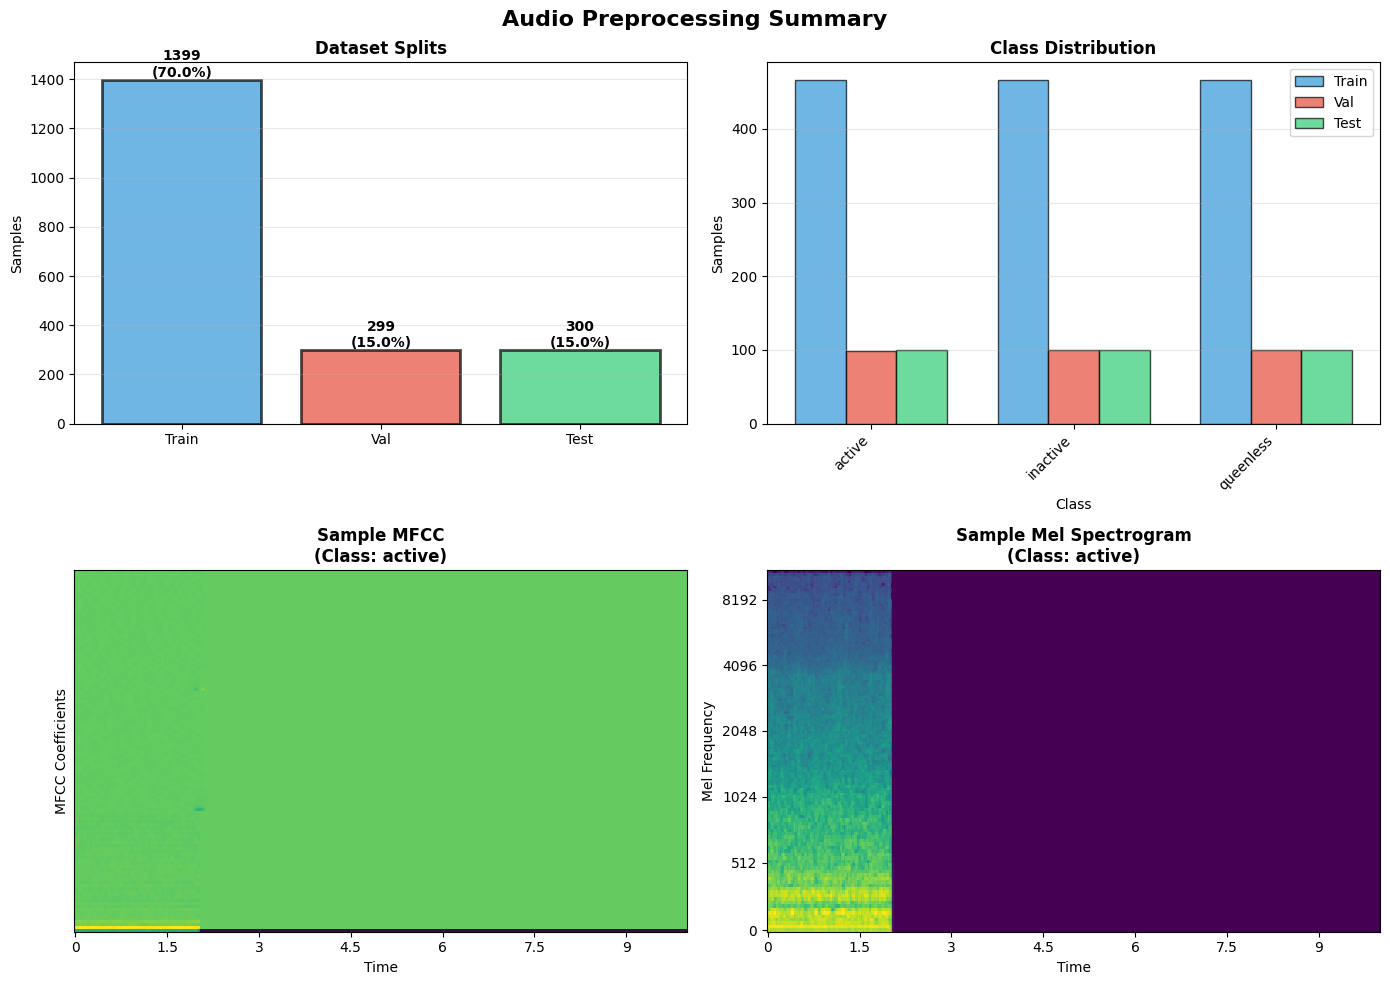

Visualization saved: /content/asali_work/visualizations/audio_preprocessing_summary.png

AUDIO PREPROCESSING COMPLETE

Processed: 1998 files
Train:     1399 samples
Val:       299 samples
Test:      300 samples

Feature dimensions:
  MFCC:  431 x 120
  Mel:   431 x 128

Saved: /content/asali_work/audio_features/preprocessed_audio_features.npz

*** SUBSET MODE (1998 files) ***
Set USE_SUBSET=False for full dataset


In [ ]:
# ============================================================================
# CELL 4: Audio Preprocessing & Feature Extraction (MEMORY EFFICIENT)
# ============================================================================

import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("AUDIO PREPROCESSING & FEATURE EXTRACTION")
print("="*60)

# ============================================================================
# CONFIGURATION
# ============================================================================

TARGET_SR = AUDIO_CONFIG['sample_rate']
TARGET_DURATION = AUDIO_CONFIG['duration']
N_MFCC = AUDIO_CONFIG['n_mfcc']
N_MELS = AUDIO_CONFIG['n_mels']
N_FFT = AUDIO_CONFIG['n_fft']
HOP_LENGTH = AUDIO_CONFIG['hop_length']

# Processing settings
USE_SUBSET = True  # Set False for full dataset
SUBSET_SIZE = 2000
BATCH_SIZE = 100  # Process and save in batches

print(f"\nConfiguration:")
print(f"  Target sample rate: {TARGET_SR} Hz")
print(f"  Target duration:    {TARGET_DURATION} seconds")
print(f"  MFCC coefficients:  {N_MFCC}")
print(f"  Mel bands:          {N_MELS}")
print(f"  Batch size:         {BATCH_SIZE} files")
print(f"  Processing mode:    {'SUBSET' if USE_SUBSET else 'FULL DATASET'}")
if USE_SUBSET:
    print(f"  Subset size:        {SUBSET_SIZE} files")

# ============================================================================
# 1. LOAD FINAL MANIFEST
# ============================================================================

print("\nStep 1: Loading final manifest...")

final_manifest_path = WORK_DIR / 'final_audio_manifest.csv'
audio_df = pd.read_csv(final_manifest_path)

print(f"Total files: {len(audio_df)}")

# Use subset if enabled
if USE_SUBSET:
    audio_df = audio_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), SUBSET_SIZE // 3), random_state=42)
    ).reset_index(drop=True)
    print(f"\nUsing subset: {len(audio_df)} files")

print(f"\nLabel distribution:")
for label, count in audio_df['label'].value_counts().items():
    print(f"  {label:20s}: {count:6d} files")

# ============================================================================
# 2. PREPROCESSING FUNCTIONS
# ============================================================================

print("\nStep 2: Setting up preprocessing functions...")

def load_and_preprocess_audio(file_path, sr=TARGET_SR, duration=TARGET_DURATION):
    """Load and preprocess audio file"""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)

        target_length = sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]

        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))

        return audio, sr
    except Exception as e:
        return None, None

def extract_features(audio, sr):
    """Extract MFCC and mel spectrogram features"""
    try:
        # MFCCs with deltas
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC,
                                     n_fft=N_FFT, hop_length=HOP_LENGTH)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_features = np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0)

        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS,
                                                   n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return {
            'mfcc': mfcc_features.T,
            'mel_spec': mel_spec_db.T
        }
    except Exception as e:
        return None

print("Preprocessing functions ready")

# ============================================================================
# 3. PROCESS AUDIO IN BATCHES (SAVE TO DISK)
# ============================================================================

print("\nStep 3: Processing audio files in batches...")
print("Features saved to disk after each batch to save memory")

# Create temp directory for batch files
batch_dir = audio_features / 'temp_batches'
batch_dir.mkdir(parents=True, exist_ok=True)

num_batches = int(np.ceil(len(audio_df) / BATCH_SIZE))
failed_files = []
batch_info = []

for batch_idx in range(num_batches):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min((batch_idx + 1) * BATCH_SIZE, len(audio_df))
    batch_df = audio_df.iloc[start_idx:end_idx]

    print(f"\nBatch {batch_idx + 1}/{num_batches} ({len(batch_df)} files)...")

    batch_mfcc = []
    batch_mel = []
    batch_labels = []
    batch_indices = []

    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df),
                        desc=f"Processing", leave=False):
        audio, sr = load_and_preprocess_audio(row['path'])

        if audio is None:
            failed_files.append(row['filename'])
            continue

        features = extract_features(audio, sr)

        if features is None:
            failed_files.append(row['filename'])
            continue

        batch_mfcc.append(features['mfcc'])
        batch_mel.append(features['mel_spec'])
        batch_labels.append(row['label'])
        batch_indices.append(idx)

    # Save batch to disk immediately
    if len(batch_mfcc) > 0:
        batch_file = batch_dir / f'batch_{batch_idx:04d}.npz'
        np.savez_compressed(
            batch_file,
            mfcc=np.array(batch_mfcc),
            mel=np.array(batch_mel),
            labels=np.array(batch_labels),
            indices=np.array(batch_indices)
        )

        batch_info.append({
            'batch_idx': batch_idx,
            'file': batch_file,
            'n_samples': len(batch_mfcc)
        })

        print(f"  Saved: {len(batch_mfcc)} samples to {batch_file.name}")

    # Clear memory
    del batch_mfcc, batch_mel, batch_labels

print(f"\nProcessing complete:")
print(f"  Batches saved: {len(batch_info)}")
print(f"  Failed files:  {len(failed_files)}")

# ============================================================================
# 4. LOAD ALL BATCHES AND COMBINE
# ============================================================================

print("\nStep 4: Loading batches and combining...")

all_mfcc = []
all_mel = []
all_labels = []

for info in tqdm(batch_info, desc="Loading batches"):
    batch_data = np.load(info['file'])
    all_mfcc.append(batch_data['mfcc'])
    all_mel.append(batch_data['mel'])
    all_labels.extend(batch_data['labels'])

X_mfcc = np.vstack(all_mfcc)
X_mel = np.vstack(all_mel)
y_labels = np.array(all_labels)

print(f"\nFeature shapes:")
print(f"  MFCC features:    {X_mfcc.shape}")
print(f"  Mel spectrograms: {X_mel.shape}")
print(f"  Labels:           {y_labels.shape}")

# Clean up temp files
print(f"\nCleaning up temporary batch files...")
for info in batch_info:
    info['file'].unlink()
batch_dir.rmdir()
print(f"Temporary files removed")

# ============================================================================
# 5. ENCODE LABELS
# ============================================================================

print("\nStep 5: Encoding labels...")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

print(f"Label encoding:")
for idx, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == idx)
    print(f"  {idx}: {class_name:20s} ({count} samples)")

# ============================================================================
# 6. CREATE TRAIN/VAL/TEST SPLITS
# ============================================================================

print("\nStep 6: Creating train/val/test splits...")

# Split: 70% train, 15% val, 15% test
X_mfcc_trainval, X_mfcc_test, X_mel_trainval, X_mel_test, y_trainval, y_test = train_test_split(
    X_mfcc, X_mel, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_mfcc_train, X_mfcc_val, X_mel_train, X_mel_val, y_train, y_val = train_test_split(
    X_mfcc_trainval, X_mel_trainval, y_trainval, test_size=0.176, random_state=42, stratify=y_trainval
)

print(f"\nDataset splits:")
print(f"  Train:      {len(y_train):6d} samples ({len(y_train)/len(y_encoded)*100:.1f}%)")
print(f"  Validation: {len(y_val):6d} samples ({len(y_val)/len(y_encoded)*100:.1f}%)")
print(f"  Test:       {len(y_test):6d} samples ({len(y_test)/len(y_encoded)*100:.1f}%)")

# ============================================================================
# 7. SAVE PREPROCESSED DATA
# ============================================================================

print("\nStep 7: Saving preprocessed data...")

features_path = audio_features / 'preprocessed_audio_features.npz'
np.savez_compressed(
    features_path,
    X_mfcc_train=X_mfcc_train,
    X_mfcc_val=X_mfcc_val,
    X_mfcc_test=X_mfcc_test,
    X_mel_train=X_mel_train,
    X_mel_val=X_mel_val,
    X_mel_test=X_mel_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    class_names=label_encoder.classes_
)
print(f"Features saved: {features_path}")
print(f"File size: {features_path.stat().st_size / (1024**2):.1f} MB")

# Save label encoder
encoder_path = audio_features / 'label_encoder.pkl'
save_pickle(label_encoder, encoder_path)

# Save config
config = {
    'target_sr': TARGET_SR,
    'target_duration': TARGET_DURATION,
    'n_mfcc': N_MFCC,
    'n_mels': N_MELS,
    'total_files': len(y_encoded),
    'train_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'classes': label_encoder.classes_.tolist(),
    'use_subset': USE_SUBSET,
}

config_path = audio_features / 'preprocessing_config.json'
save_json(config, config_path)

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

print("\nStep 8: Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dataset splits
ax1 = axes[0, 0]
splits = ['Train', 'Val', 'Test']
sizes = [len(y_train), len(y_val), len(y_test)]
colors_split = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(splits, sizes, color=colors_split, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Samples')
ax1.set_title('Dataset Splits', fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{size}\n({size/len(y_encoded)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# Class distribution
ax2 = axes[0, 1]
x_pos = np.arange(len(label_encoder.classes_))
width = 0.25
for i, (y_data, label, color) in enumerate(zip([y_train, y_val, y_test], splits, colors_split)):
    counts = [np.sum(y_data == idx) for idx in range(len(label_encoder.classes_))]
    ax2.bar(x_pos + i*width, counts, width, label=label, alpha=0.7, color=color, edgecolor='black')
ax2.set_xlabel('Class')
ax2.set_ylabel('Samples')
ax2.set_title('Class Distribution', fontweight='bold')
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# Sample MFCC
ax3 = axes[1, 0]
librosa.display.specshow(X_mfcc_train[0].T, x_axis='time', ax=ax3, cmap='viridis')
ax3.set_ylabel('MFCC Coefficients')
ax3.set_title(f'Sample MFCC\n(Class: {label_encoder.classes_[y_train[0]]})', fontweight='bold')

# Sample mel spectrogram
ax4 = axes[1, 1]
librosa.display.specshow(X_mel_train[0].T, x_axis='time', y_axis='mel',
                        sr=TARGET_SR, ax=ax4, cmap='viridis')
ax4.set_ylabel('Mel Frequency')
ax4.set_title(f'Sample Mel Spectrogram\n(Class: {label_encoder.classes_[y_train[0]]})', fontweight='bold')

plt.suptitle('Audio Preprocessing Summary', fontsize=16, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'audio_preprocessing_summary.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("AUDIO PREPROCESSING COMPLETE")
print("="*60)

print(f"\nProcessed: {len(y_encoded)} files")
print(f"Train:     {len(y_train)} samples")
print(f"Val:       {len(y_val)} samples")
print(f"Test:      {len(y_test)} samples")

print(f"\nFeature dimensions:")
print(f"  MFCC:  {X_mfcc_train.shape[1]} x {X_mfcc_train.shape[2]}")
print(f"  Mel:   {X_mel_train.shape[1]} x {X_mel_train.shape[2]}")

print(f"\nSaved: {features_path}")

if USE_SUBSET:
    print(f"\n*** SUBSET MODE ({len(y_encoded)} files) ***")
    print(f"Set USE_SUBSET=False for full dataset")

print("="*60)

CNN-LSTM SOUND CLASSIFIER TRAINING

Step 1: Loading preprocessed features...
Data loaded:
  Train: (1399, 431, 120)
  Val:   (299, 431, 120)
  Test:  (300, 431, 120)
  Classes: [np.str_('active'), np.str_('inactive'), np.str_('queenless')]

Label shapes:
  Train: (1399, 3)
  Val:   (299, 3)
  Test:  (300, 3)

Step 2: Building CNN-LSTM model...

Model architecture:


Model: "CNN_LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 431, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 431, 64)        │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 431, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 431, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 215, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 215, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 215, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 215, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 215, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 107, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 107, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 107, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 107, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 107, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 53, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 53, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 53, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 53, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 731,715 (2.79 MB)

 Trainable params: 730,819 (2.79 MB)

 Non-trainable params: 896 (3.50 KB)


Total parameters: 731,715

Step 3: Compiling model...
Model compiled
  Optimizer: Adam (lr=0.001)
  Loss: Categorical crossentropy
  Metrics: Accuracy

Step 4: Setting up training callbacks...
Callbacks configured:
  - ModelCheckpoint (save best)
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau (patience=5)

Step 5: Training model...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3758 - loss: 1.0967
Epoch 1: val_loss improved from inf to 1.17479, saving model to /content/asali_work/checkpoints/sound_model/best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.3766 - loss: 1.0963 - val_accuracy: 0.3344 - val_loss: 1.1748 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5710 - loss: 0.9160
Epoch 2: val_loss improved from 1.17479 to 0.76361, saving model to /content/asali_work/checkpoints/sound_model/best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5714 - loss: 0.9152 - val_accuracy: 0.6

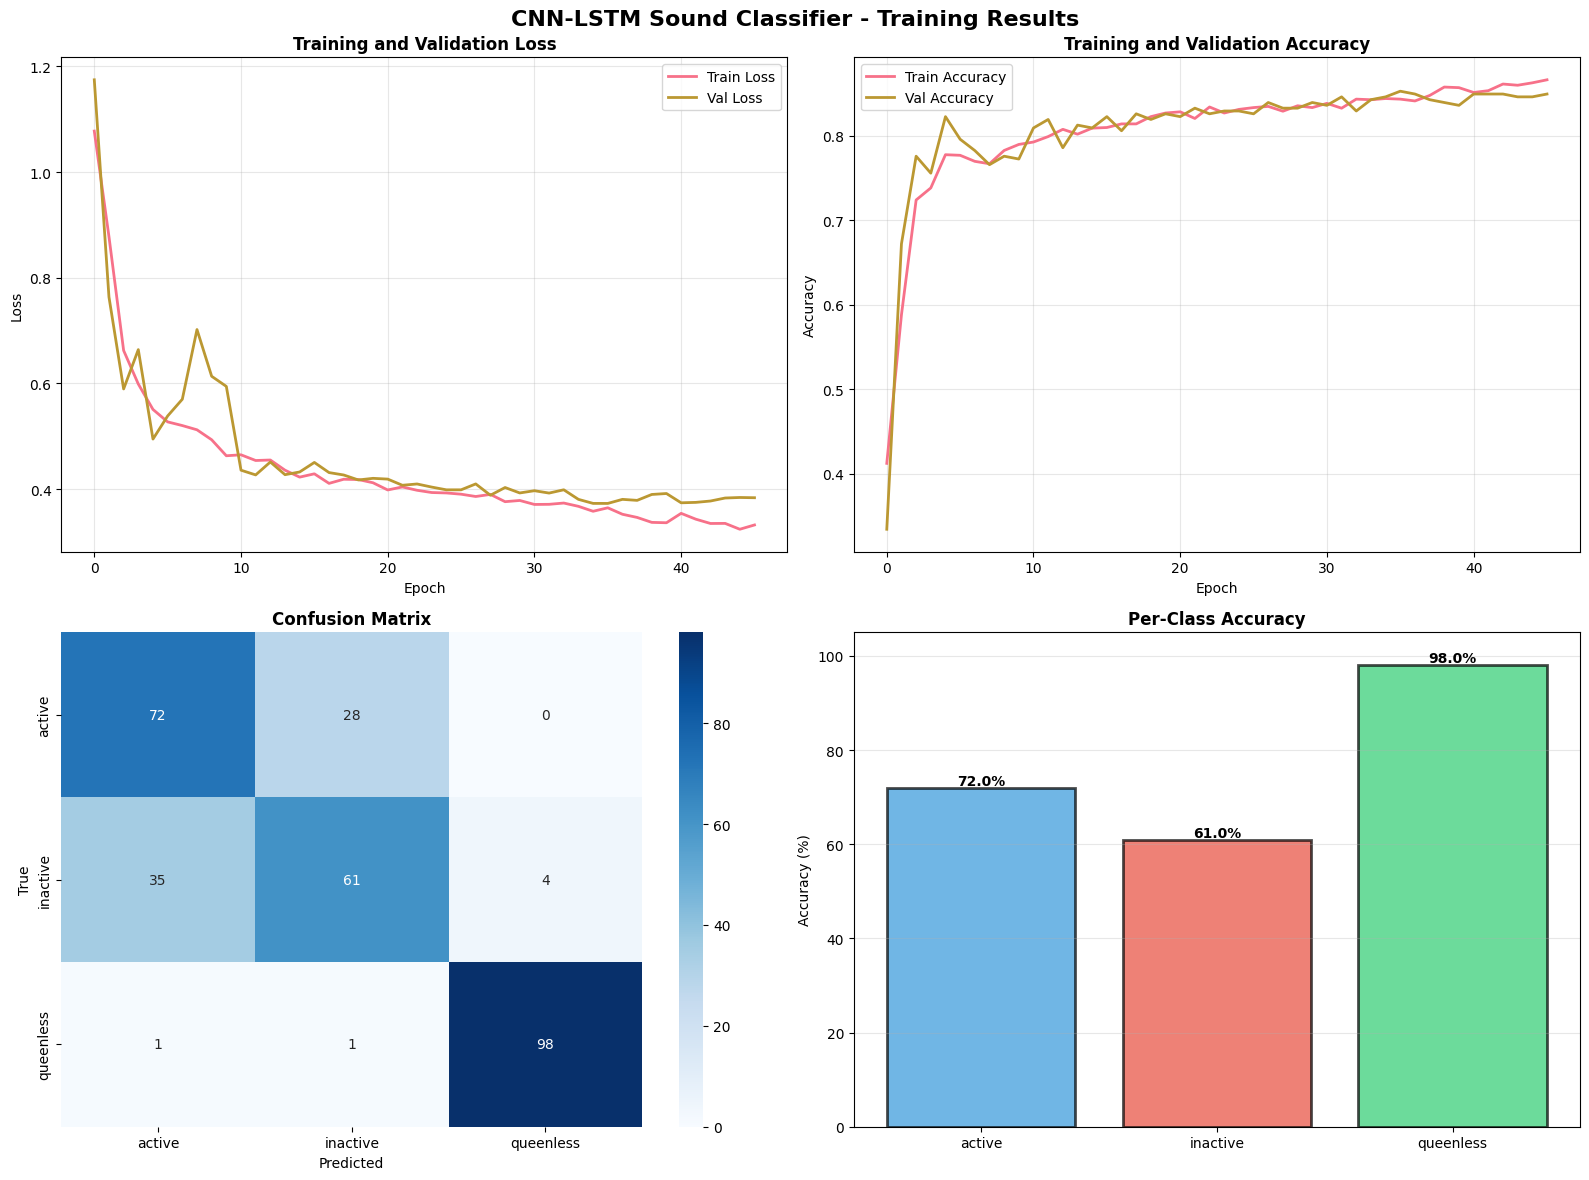

Visualization saved: /content/asali_work/visualizations/sound_model_training.png

MODEL TRAINING COMPLETE

Final Results:
  Test Accuracy:  77.00%
  Test Loss:      0.4534
  Total Epochs:   46
  Total Params:   731,715

Per-Class Performance:
  active              : 72.00%
  inactive            : 61.00%
  queenless           : 98.00%

Model saved:
  /content/asali_work/models/sound/sound_classifier_cnn_lstm.keras

Files created:
  - sound_classifier_cnn_lstm.keras (model)
  - training_history.json
  - evaluation_results.json
  - sound_model_training.png


In [ ]:
# ============================================================================
# CELL 5: CNN-LSTM Sound Classifier Training
# ============================================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

print("="*60)
print("CNN-LSTM SOUND CLASSIFIER TRAINING")
print("="*60)

# ============================================================================
# 1. LOAD PREPROCESSED DATA
# ============================================================================

print("\nStep 1: Loading preprocessed features...")

features_path = audio_features / 'preprocessed_audio_features.npz'
data = np.load(features_path)

X_train = data['X_mfcc_train']
X_val = data['X_mfcc_val']
X_test = data['X_mfcc_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
class_names = data['class_names']

print(f"Data loaded:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"  Classes: {list(class_names)}")

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_val_cat = to_categorical(y_val, num_classes=len(class_names))
y_test_cat = to_categorical(y_test, num_classes=len(class_names))

print(f"\nLabel shapes:")
print(f"  Train: {y_train_cat.shape}")
print(f"  Val:   {y_val_cat.shape}")
print(f"  Test:  {y_test_cat.shape}")

# ============================================================================
# 2. BUILD CNN-LSTM MODEL
# ============================================================================

print("\nStep 2: Building CNN-LSTM model...")

def build_cnn_lstm_model(input_shape, num_classes):
    """Build CNN-LSTM architecture for audio classification"""

    inputs = layers.Input(shape=input_shape, name='input')

    # Conv Block 1
    x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # Conv Block 2
    x = layers.Conv1D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # Conv Block 3
    x = layers.Conv1D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM Layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.3)(x)

    # Dense Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='CNN_LSTM_Classifier')

    return model

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(class_names)

model = build_cnn_lstm_model(input_shape, num_classes)

print("\nModel architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

# ============================================================================
# 3. COMPILE MODEL
# ============================================================================

print("\nStep 3: Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: Categorical crossentropy")
print(f"  Metrics: Accuracy")

# ============================================================================
# 4. SETUP CALLBACKS
# ============================================================================

print("\nStep 4: Setting up training callbacks...")

# Create checkpoint directory
checkpoint_dir = WORK_DIR / 'checkpoints' / 'sound_model'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Callbacks
callback_list = [
    # Save best model
    callbacks.ModelCheckpoint(
        filepath=str(checkpoint_dir / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),

    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
]

print("Callbacks configured:")
print("  - ModelCheckpoint (save best)")
print("  - EarlyStopping (patience=10)")
print("  - ReduceLROnPlateau (patience=5)")

# ============================================================================
# 5. TRAIN MODEL
# ============================================================================

print("\nStep 5: Training model...")
print("="*60)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*60)
print("Training complete")

# ============================================================================
# 6. EVALUATE ON TEST SET
# ============================================================================

print("\nStep 6: Evaluating on test set...")

# Load best model
best_model = keras.models.load_model(checkpoint_dir / 'best_model.keras')

# Evaluate
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\nTest Results:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy*100:.2f}%")

# Predictions
y_pred = best_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print("="*60)
report = classification_report(y_test, y_pred_classes,
                               target_names=class_names,
                               digits=4)
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

print("\nConfusion Matrix:")
print(cm)

# Per-class metrics
print("\nPer-Class Metrics:")
for idx, class_name in enumerate(class_names):
    class_mask = y_test == idx
    class_acc = (y_pred_classes[class_mask] == idx).sum() / class_mask.sum()
    print(f"  {class_name:20s}: {class_acc*100:.2f}% accuracy")

# ============================================================================
# 7. SAVE MODEL AND RESULTS
# ============================================================================

print("\nStep 7: Saving model and results...")

# Save final model
final_model_path = sound_models / 'sound_classifier_cnn_lstm.keras'
best_model.save(final_model_path)
print(f"Model saved: {final_model_path}")

# Save training history
history_dict = {
    'loss': [float(x) for x in history.history['loss']],
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
}

history_path = sound_models / 'training_history.json'
save_json(history_dict, history_path)

# Save evaluation results
eval_results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'classification_report': classification_report(y_test, y_pred_classes,
                                                   target_names=class_names,
                                                   output_dict=True),
    'confusion_matrix': cm.tolist(),
    'class_names': list(class_names),
}

eval_path = sound_models / 'evaluation_results.json'
save_json(eval_results, eval_path)

print(f"Results saved: {eval_path}")

# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================

print("\nStep 8: Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Training history - Loss
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 8.2 Training history - Accuracy
ax2 = axes[0, 1]
ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 8.3 Confusion Matrix
ax3 = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names, ax=ax3)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('True')
ax3.set_title('Confusion Matrix', fontweight='bold')

# 8.4 Per-class accuracy
ax4 = axes[1, 1]
class_accuracies = []
for idx in range(len(class_names)):
    class_mask = y_test == idx
    class_acc = (y_pred_classes[class_mask] == idx).sum() / class_mask.sum()
    class_accuracies.append(class_acc * 100)

colors_bar = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax4.bar(class_names, class_accuracies, color=colors_bar,
              alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Per-Class Accuracy', fontweight='bold')
ax4.grid(alpha=0.3, axis='y')
ax4.set_ylim([0, 105])

for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('CNN-LSTM Sound Classifier - Training Results',
            fontsize=16, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'sound_model_training.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)

print(f"\nFinal Results:")
print(f"  Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"  Test Loss:      {test_loss:.4f}")
print(f"  Total Epochs:   {len(history.history['loss'])}")
print(f"  Total Params:   {total_params:,}")

print(f"\nPer-Class Performance:")
for class_name, acc in zip(class_names, class_accuracies):
    print(f"  {class_name:20s}: {acc:.2f}%")

print(f"\nModel saved:")
print(f"  {final_model_path}")

print(f"\nFiles created:")
print(f"  - sound_classifier_cnn_lstm.keras (model)")
print(f"  - training_history.json")
print(f"  - evaluation_results.json")
print(f"  - sound_model_training.png")

print("="*60)

TESTING AUDIO MODEL ON SAMPLES

Step 1: Loading trained model...
Model loaded: /content/asali_work/models/sound/sound_classifier_cnn_lstm.keras

Test data: (300, 431, 120)
Classes: [np.str_('active'), np.str_('inactive'), np.str_('queenless')]

Step 2: Making predictions on random samples...

Random Sample Predictions:

Sample 1:
  True:       active
  Predicted:  active
  Confidence: 73.65%
  Status:     ✓ CORRECT
  All probs:  active=73.6% inactive=26.3% queenless=0.0% 

Sample 2:
  True:       active
  Predicted:  inactive
  Confidence: 64.37%
  Status:     ✗ WRONG
  All probs:  active=35.5% inactive=64.4% queenless=0.1% 

Sample 3:
  True:       inactive
  Predicted:  queenless
  Confidence: 63.70%
  Status:     ✗ WRONG
  All probs:  active=0.3% inactive=36.0% queenless=63.7% 

Sample 4:
  True:       inactive
  Predicted:  active
  Confidence: 61.55%
  Status:     ✗ WRONG
  All probs:  active=61.6% inactive=38.4% queenless=0.0% 

Sample 5:
  True:       inactive
  Predicted:  inac

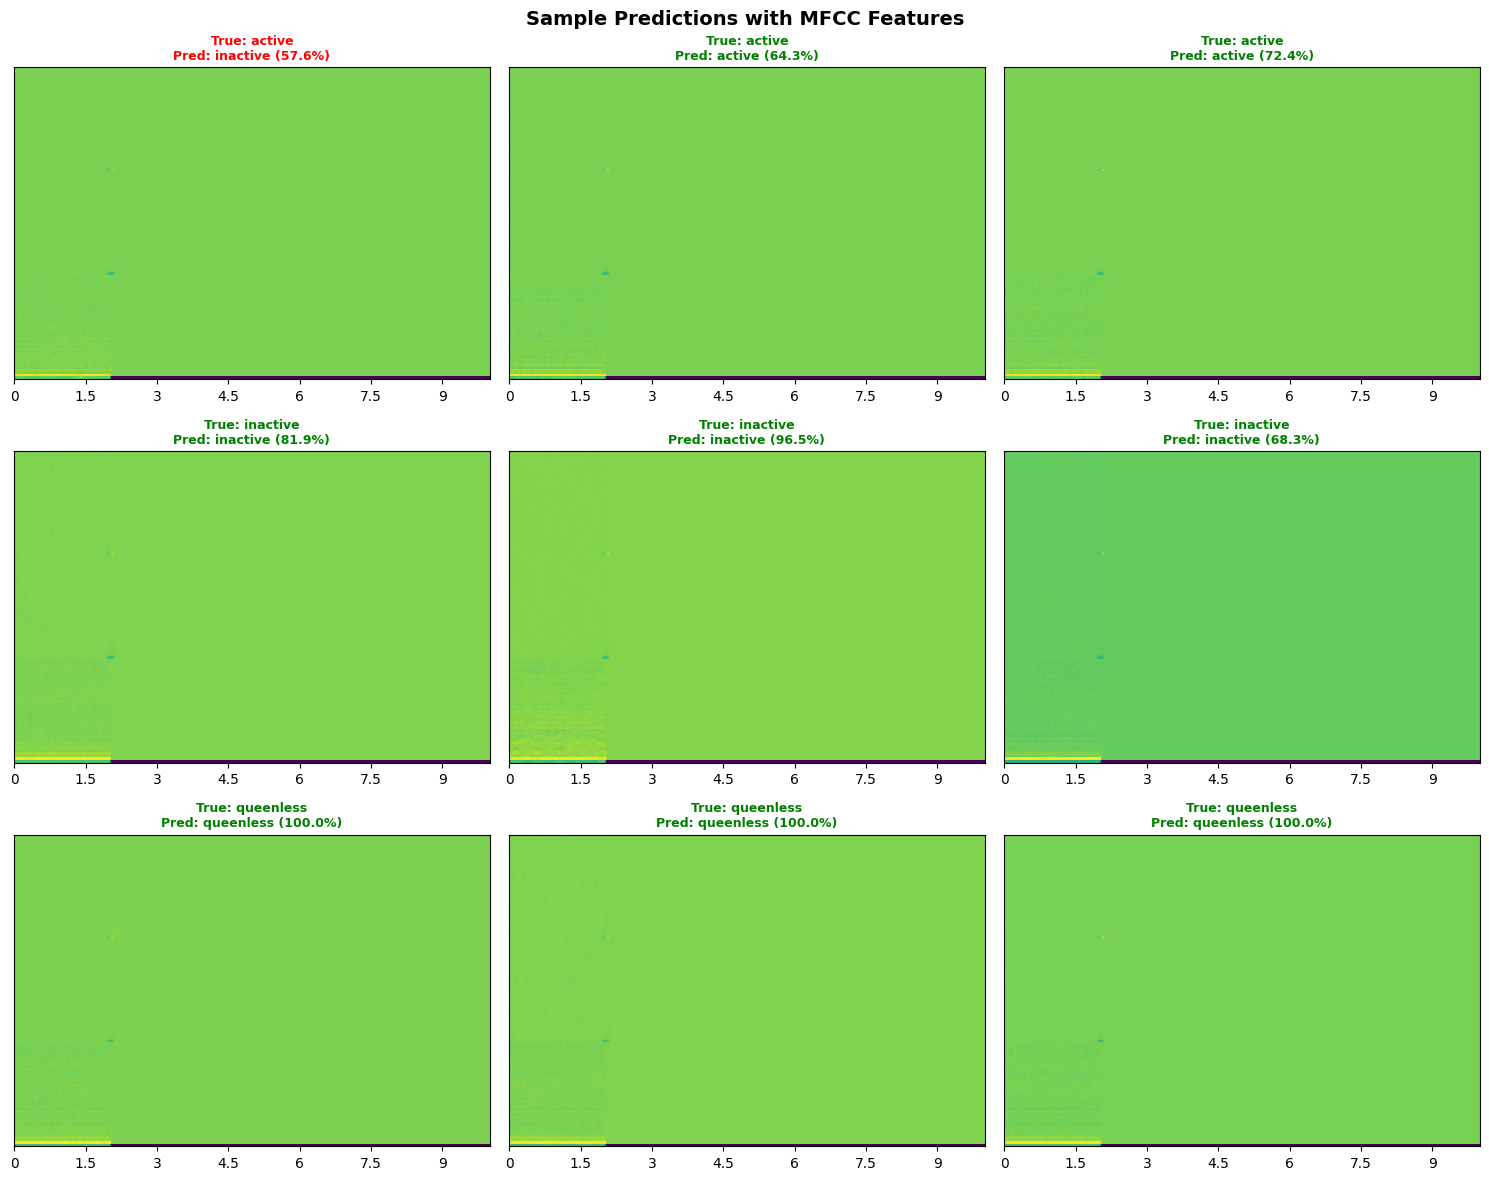

Visualization saved: /content/asali_work/visualizations/sample_predictions.png

Step 6: Analyzing Misclassifications

Total misclassifications: 69 out of 300 (23.0%)

Most Common Confusions:
  inactive -> active            :  35 cases (avg conf: 70.3%)
  active -> inactive            :  28 cases (avg conf: 72.4%)
  inactive -> queenless         :   4 cases (avg conf: 64.1%)
  queenless -> active           :   1 cases (avg conf: 72.3%)
  queenless -> inactive         :   1 cases (avg conf: 56.5%)

TESTING SUMMARY

Model Performance:
  Test Accuracy:     77.00%
  Correct Predictions: 231 / 300
  Wrong Predictions:   69 / 300

Confidence Statistics:
  Mean: 81.25%
  Std:  14.45%
  Min:  50.20%
  Max:  100.00%

High Confidence Predictions (>90%):
  Count: 98 / 300 (32.7%)

Low Confidence Predictions (<70%):
  Count: 60 / 300 (20.0%)

Model is ready for deployment!


In [ ]:
# ============================================================================
# CELL 5B: Test Audio Model on Sample Predictions
# ============================================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd

print("="*60)
print("TESTING AUDIO MODEL ON SAMPLES")
print("="*60)

# ============================================================================
# 1. LOAD MODEL AND DATA
# ============================================================================

print("\nStep 1: Loading trained model...")

model_path = sound_models / 'sound_classifier_cnn_lstm.keras'
model = keras.models.load_model(model_path)
print(f"Model loaded: {model_path}")

# Load preprocessed test data
features_path = audio_features / 'preprocessed_audio_features.npz'
data = np.load(features_path)

X_test = data['X_mfcc_test']
y_test = data['y_test']
class_names = data['class_names']

print(f"\nTest data: {X_test.shape}")
print(f"Classes: {list(class_names)}")

# ============================================================================
# 2. RANDOM SAMPLE PREDICTIONS
# ============================================================================

print("\nStep 2: Making predictions on random samples...")

n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

predictions = []

for idx in sample_indices:
    # Get sample
    X_sample = X_test[idx:idx+1]
    y_true = y_test[idx]

    # Predict
    pred = model.predict(X_sample, verbose=0)[0]
    pred_class = np.argmax(pred)
    confidence = pred[pred_class]

    predictions.append({
        'index': idx,
        'true_label': class_names[y_true],
        'pred_label': class_names[pred_class],
        'confidence': confidence,
        'correct': y_true == pred_class,
        'probabilities': pred
    })

print("\nRandom Sample Predictions:")
print("="*60)
for i, p in enumerate(predictions, 1):
    status = "CORRECT" if p['correct'] else "WRONG"
    emoji = "✓" if p['correct'] else "✗"

    print(f"\nSample {i}:")
    print(f"  True:       {p['true_label']}")
    print(f"  Predicted:  {p['pred_label']}")
    print(f"  Confidence: {p['confidence']*100:.2f}%")
    print(f"  Status:     {emoji} {status}")
    print(f"  All probs:  ", end="")
    for cls, prob in zip(class_names, p['probabilities']):
        print(f"{cls}={prob*100:.1f}% ", end="")
    print()

# ============================================================================
# 3. TEST SPECIFIC CLASSES
# ============================================================================

print("\n" + "="*60)
print("Step 3: Testing samples from each class...")
print("="*60)

for class_idx, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()} Class:")
    print("-" * 60)

    # Get samples of this class
    class_mask = y_test == class_idx
    class_indices = np.where(class_mask)[0]

    # Test 3 random samples from this class
    test_indices = np.random.choice(class_indices, min(3, len(class_indices)), replace=False)

    for i, idx in enumerate(test_indices, 1):
        X_sample = X_test[idx:idx+1]
        pred = model.predict(X_sample, verbose=0)[0]
        pred_class = np.argmax(pred)

        correct = pred_class == class_idx
        emoji = "✓" if correct else "✗"

        print(f"  Sample {i}: {emoji} Predicted as {class_names[pred_class]} "
              f"({pred[pred_class]*100:.1f}% confidence)")

# ============================================================================
# 4. CONFIDENCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("Step 4: Confidence Analysis")
print("="*60)

# Predict all test samples
all_predictions = model.predict(X_test, verbose=0)
all_pred_classes = np.argmax(all_predictions, axis=1)
all_confidences = np.max(all_predictions, axis=1)

# Overall stats
correct_mask = all_pred_classes == y_test
accuracy = correct_mask.sum() / len(y_test)

print(f"\nOverall Test Performance:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Avg Confidence (correct): {all_confidences[correct_mask].mean()*100:.2f}%")
print(f"  Avg Confidence (wrong):   {all_confidences[~correct_mask].mean()*100:.2f}%")

# Per-class confidence
print(f"\nPer-Class Confidence:")
for class_idx, class_name in enumerate(class_names):
    class_mask = y_test == class_idx
    class_confidences = all_confidences[class_mask & correct_mask]

    if len(class_confidences) > 0:
        print(f"  {class_name:20s}: {class_confidences.mean()*100:.2f}% "
              f"(min: {class_confidences.min()*100:.1f}%, "
              f"max: {class_confidences.max()*100:.1f}%)")

# ============================================================================
# 5. VISUALIZE PREDICTIONS
# ============================================================================

print("\nStep 5: Creating prediction visualizations...")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Select 9 samples (3 from each class)
vis_samples = []
for class_idx in range(len(class_names)):
    class_mask = y_test == class_idx
    class_indices = np.where(class_mask)[0]
    vis_samples.extend(np.random.choice(class_indices, 3, replace=False))

for plot_idx, sample_idx in enumerate(vis_samples):
    ax = axes[plot_idx]

    # Get prediction
    X_sample = X_test[sample_idx:sample_idx+1]
    pred = model.predict(X_sample, verbose=0)[0]
    pred_class = np.argmax(pred)
    true_class = y_test[sample_idx]

    # Plot MFCC
    librosa.display.specshow(X_test[sample_idx].T, x_axis='time', ax=ax, cmap='viridis')

    # Title with prediction
    correct = pred_class == true_class
    color = 'green' if correct else 'red'

    title = f"True: {class_names[true_class]}\n"
    title += f"Pred: {class_names[pred_class]} ({pred[pred_class]*100:.1f}%)"

    ax.set_title(title, fontsize=9, color=color, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle('Sample Predictions with MFCC Features', fontsize=14, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'sample_predictions.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# 6. CONFUSION CASES (Misclassifications)
# ============================================================================

print("\n" + "="*60)
print("Step 6: Analyzing Misclassifications")
print("="*60)

# Find all wrong predictions
wrong_mask = all_pred_classes != y_test
wrong_indices = np.where(wrong_mask)[0]

if len(wrong_indices) > 0:
    print(f"\nTotal misclassifications: {len(wrong_indices)} out of {len(y_test)} "
          f"({len(wrong_indices)/len(y_test)*100:.1f}%)")

    # Group by true -> predicted
    confusion_pairs = {}
    for idx in wrong_indices:
        true_cls = class_names[y_test[idx]]
        pred_cls = class_names[all_pred_classes[idx]]
        pair = f"{true_cls} -> {pred_cls}"

        if pair not in confusion_pairs:
            confusion_pairs[pair] = []
        confusion_pairs[pair].append(all_confidences[idx])

    print(f"\nMost Common Confusions:")
    for pair, confidences in sorted(confusion_pairs.items(),
                                   key=lambda x: len(x[1]), reverse=True):
        avg_conf = np.mean(confidences)
        print(f"  {pair:30s}: {len(confidences):3d} cases (avg conf: {avg_conf*100:.1f}%)")
else:
    print("\nNo misclassifications (perfect score!)")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("TESTING SUMMARY")
print("="*60)

print(f"\nModel Performance:")
print(f"  Test Accuracy:     {accuracy*100:.2f}%")
print(f"  Correct Predictions: {correct_mask.sum()} / {len(y_test)}")
print(f"  Wrong Predictions:   {(~correct_mask).sum()} / {len(y_test)}")

print(f"\nConfidence Statistics:")
print(f"  Mean: {all_confidences.mean()*100:.2f}%")
print(f"  Std:  {all_confidences.std()*100:.2f}%")
print(f"  Min:  {all_confidences.min()*100:.2f}%")
print(f"  Max:  {all_confidences.max()*100:.2f}%")

print(f"\nHigh Confidence Predictions (>90%):")
high_conf_mask = all_confidences > 0.9
print(f"  Count: {high_conf_mask.sum()} / {len(y_test)} ({high_conf_mask.sum()/len(y_test)*100:.1f}%)")

print(f"\nLow Confidence Predictions (<70%):")
low_conf_mask = all_confidences < 0.7
print(f"  Count: {low_conf_mask.sum()} / {len(y_test)} ({low_conf_mask.sum()/len(y_test)*100:.1f}%)")

print("\n" + "="*60)
print("Model is ready for deployment!")
print("="*60)

AUTO-LABELING UNKNOWN AUDIO FILES

Step 1: Loading model and unknown file manifest...
Model loaded: /content/asali_work/models/sound/sound_classifier_cnn_lstm.keras
Classes: [np.str_('active'), np.str_('inactive'), np.str_('queenless')]

Unknown files to label: 7100

Step 2: Processing unknown files and predicting labels...
Using sample: 500 files

Batch 1/10 (50 files)...


  Processed: 50 files

Batch 2/10 (50 files)...


  Processed: 50 files

Batch 3/10 (50 files)...


  Processed: 50 files

Batch 4/10 (50 files)...


  Processed: 50 files

Batch 5/10 (50 files)...


  Processed: 50 files

Batch 6/10 (50 files)...


  Processed: 50 files

Batch 7/10 (50 files)...


  Processed: 50 files

Batch 8/10 (50 files)...


  Processed: 50 files

Batch 9/10 (50 files)...


  Processed: 50 files

Batch 10/10 (50 files)...


  Processed: 50 files

Prediction complete:
  Successful: 500
  Failed: 0

Step 3: Analyzing predictions...

Predicted label distribution:
  active              :   315 files ( 63.0%)
  inactive            :   185 files ( 37.0%)

Step 4: Categorizing into final groups...

Final categorization:
  uncertain           :   231 files ( 46.2%) - avg conf: 59.2%
  bee_sound           :   139 files ( 27.8%) - avg conf: 67.8%
  no_bee              :   130 files ( 26.0%) - avg conf: 81.5%

Step 5: Confidence analysis...

Confidence distribution:
  Very High (>90%)    :     2 (  0.4%)
  High (80-90%)       :    82 ( 16.4%)
  Medium (70-80%)     :    60 ( 12.0%)
  Low (60-70%)        :   245 ( 49.0%)
  Very Low (<60%)     :   111 ( 22.2%)

Step 6: Sample predictions review...

High confidence bee_sound samples:

High confidence no_bee samples:
  2022-06-25--05-46-02_1__segment5.wav               - 88.4% inactive
  2022-06-28--09-14-48_1__segment0.wav               - 83.9% inactive
  2022-06-14--07

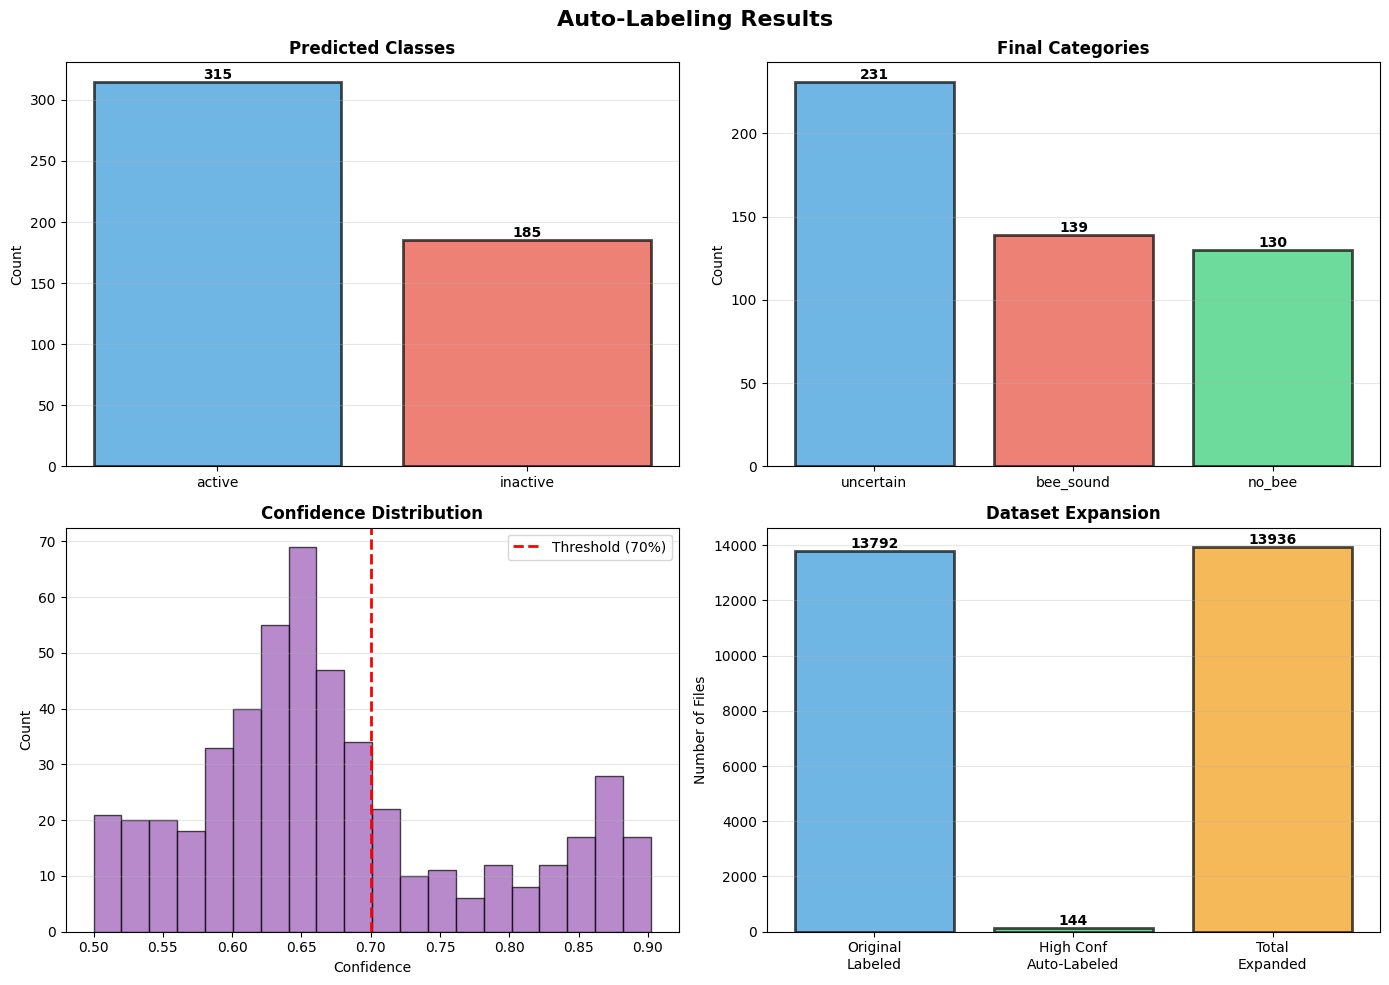

Visualization saved: /content/asali_work/visualizations/auto_labeling_results.png

AUTO-LABELING COMPLETE

Processed: 500 unknown files
Failed: 0

Final categories:
  uncertain           :   231 ( 46.2%)
  bee_sound           :   139 ( 27.8%)
  no_bee              :   130 ( 26.0%)

High confidence predictions (>70%): 144
These have been added to expanded manifest

Dataset expansion:
  Original labeled:     13792 files
  Auto-labeled added:     144 files
  Total expanded:       13936 files

Files saved:
  - /content/asali_work/unknown_files_predictions.csv
  - /content/asali_work/expanded_audio_manifest.csv

*** SAMPLE MODE (500 files) ***
Set USE_SAMPLE=False to process all 7,100 files (~45 min)


In [ ]:
# ============================================================================
# CELL 5C: Auto-Label Unknown Audio Files with Trained Model
# ============================================================================

import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

print("="*60)
print("AUTO-LABELING UNKNOWN AUDIO FILES")
print("="*60)

# ============================================================================
# 1. LOAD TRAINED MODEL AND UNKNOWN FILES
# ============================================================================

print("\nStep 1: Loading model and unknown file manifest...")

# Load model
model_path = sound_models / 'sound_classifier_cnn_lstm.keras'
model = keras.models.load_model(model_path)
print(f"Model loaded: {model_path}")

# Load label encoder
encoder_path = audio_features / 'label_encoder.pkl'
label_encoder = load_pickle(encoder_path)
class_names = label_encoder.classes_
print(f"Classes: {list(class_names)}")

# Load original manifest with unknown files
manifest_path = WORK_DIR / 'clean_audio_manifest.csv'
audio_df = pd.read_csv(manifest_path)

# Filter unknown files
unknown_df = audio_df[audio_df['label'] == 'unknown'].copy()
print(f"\nUnknown files to label: {len(unknown_df)}")

# ============================================================================
# 2. PROCESS AND PREDICT IN BATCHES
# ============================================================================

print("\nStep 2: Processing unknown files and predicting labels...")

TARGET_SR = AUDIO_CONFIG['sample_rate']
TARGET_DURATION = AUDIO_CONFIG['duration']
N_MFCC = AUDIO_CONFIG['n_mfcc']
N_FFT = AUDIO_CONFIG['n_fft']
HOP_LENGTH = AUDIO_CONFIG['hop_length']

BATCH_SIZE = 50  # Process 50 files at a time
USE_SAMPLE = True  # Set False to process all 7,100
SAMPLE_SIZE = 500  # Test on 500 files first

def extract_mfcc_features(audio, sr):
    """Extract MFCC features for model input"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC,
                                 n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_features = np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0)
    return mfcc_features.T

# Sample if testing
if USE_SAMPLE:
    unknown_df = unknown_df.sample(n=min(SAMPLE_SIZE, len(unknown_df)), random_state=42)
    print(f"Using sample: {len(unknown_df)} files")

predictions_list = []
failed_files = []

num_batches = int(np.ceil(len(unknown_df) / BATCH_SIZE))

for batch_idx in range(num_batches):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min((batch_idx + 1) * BATCH_SIZE, len(unknown_df))
    batch_df = unknown_df.iloc[start_idx:end_idx]

    print(f"\nBatch {batch_idx + 1}/{num_batches} ({len(batch_df)} files)...")

    batch_features = []
    batch_info = []

    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df),
                        desc=f"Processing", leave=False):
        try:
            # Load audio
            audio, sr = librosa.load(row['path'], sr=TARGET_SR, duration=TARGET_DURATION)

            # Pad/trim
            target_length = TARGET_SR * TARGET_DURATION
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                audio = audio[:target_length]

            # Normalize
            if np.max(np.abs(audio)) > 0:
                audio = audio / np.max(np.abs(audio))

            # Extract features
            features = extract_mfcc_features(audio, TARGET_SR)
            batch_features.append(features)
            batch_info.append({
                'index': idx,
                'filename': row['filename'],
                'path': row['path']
            })

        except Exception as e:
            failed_files.append({'filename': row['filename'], 'error': str(e)})

    # Predict batch
    if len(batch_features) > 0:
        X_batch = np.array(batch_features)
        predictions = model.predict(X_batch, verbose=0)

        for i, (pred, info) in enumerate(zip(predictions, batch_info)):
            pred_class = np.argmax(pred)
            confidence = pred[pred_class]

            predictions_list.append({
                'filename': info['filename'],
                'path': info['path'],
                'predicted_class': class_names[pred_class],
                'confidence': confidence,
                'prob_active': pred[0],
                'prob_inactive': pred[1],
                'prob_queenless': pred[2]
            })

    print(f"  Processed: {len(batch_features)} files")

print(f"\nPrediction complete:")
print(f"  Successful: {len(predictions_list)}")
print(f"  Failed: {len(failed_files)}")

# ============================================================================
# 3. CREATE PREDICTIONS DATAFRAME
# ============================================================================

print("\nStep 3: Analyzing predictions...")

predictions_df = pd.DataFrame(predictions_list)

print(f"\nPredicted label distribution:")
for label, count in predictions_df['predicted_class'].value_counts().items():
    pct = count / len(predictions_df) * 100
    print(f"  {label:20s}: {count:5d} files ({pct:5.1f}%)")

# ============================================================================
# 4. CATEGORIZE INTO FINAL GROUPS
# ============================================================================

print("\nStep 4: Categorizing into final groups...")

def categorize_prediction(row):
    """
    Categorize predictions into:
    - bee_sound: active (with high confidence)
    - no_bee: inactive (with high confidence)
    - queenless: queenless (always critical)
    - uncertain: low confidence predictions
    """
    pred_class = row['predicted_class']
    confidence = row['confidence']

    if pred_class == 'queenless' and confidence > 0.6:
        return 'queenless'
    elif pred_class == 'active' and confidence > 0.65:
        return 'bee_sound'
    elif pred_class == 'inactive' and confidence > 0.65:
        return 'no_bee'
    else:
        return 'uncertain'

predictions_df['final_category'] = predictions_df.apply(categorize_prediction, axis=1)

print(f"\nFinal categorization:")
for category, count in predictions_df['final_category'].value_counts().items():
    pct = count / len(predictions_df) * 100
    avg_conf = predictions_df[predictions_df['final_category'] == category]['confidence'].mean()
    print(f"  {category:20s}: {count:5d} files ({pct:5.1f}%) - avg conf: {avg_conf*100:.1f}%")

# ============================================================================
# 5. ANALYZE CONFIDENCE LEVELS
# ============================================================================

print("\nStep 5: Confidence analysis...")

confidence_bins = {
    'Very High (>90%)': (predictions_df['confidence'] > 0.9).sum(),
    'High (80-90%)': ((predictions_df['confidence'] > 0.8) & (predictions_df['confidence'] <= 0.9)).sum(),
    'Medium (70-80%)': ((predictions_df['confidence'] > 0.7) & (predictions_df['confidence'] <= 0.8)).sum(),
    'Low (60-70%)': ((predictions_df['confidence'] > 0.6) & (predictions_df['confidence'] <= 0.7)).sum(),
    'Very Low (<60%)': (predictions_df['confidence'] <= 0.6).sum(),
}

print(f"\nConfidence distribution:")
for bin_name, count in confidence_bins.items():
    pct = count / len(predictions_df) * 100
    print(f"  {bin_name:20s}: {count:5d} ({pct:5.1f}%)")

# ============================================================================
# 6. SAMPLE PREDICTIONS REVIEW
# ============================================================================

print("\nStep 6: Sample predictions review...")

print(f"\nHigh confidence bee_sound samples:")
bee_sound_high = predictions_df[
    (predictions_df['final_category'] == 'bee_sound') &
    (predictions_df['confidence'] > 0.8)
].head(5)

for idx, row in bee_sound_high.iterrows():
    print(f"  {row['filename'][:50]:50s} - {row['confidence']*100:.1f}% active")

print(f"\nHigh confidence no_bee samples:")
no_bee_high = predictions_df[
    (predictions_df['final_category'] == 'no_bee') &
    (predictions_df['confidence'] > 0.8)
].head(5)

for idx, row in no_bee_high.iterrows():
    print(f"  {row['filename'][:50]:50s} - {row['confidence']*100:.1f}% inactive")

if (predictions_df['final_category'] == 'queenless').any():
    print(f"\nQueenless detections:")
    queenless_files = predictions_df[predictions_df['final_category'] == 'queenless'].head(5)
    for idx, row in queenless_files.iterrows():
        print(f"  {row['filename'][:50]:50s} - {row['confidence']*100:.1f}% queenless")

print(f"\nUncertain predictions (need manual review):")
uncertain_files = predictions_df[predictions_df['final_category'] == 'uncertain'].head(5)
for idx, row in uncertain_files.iterrows():
    print(f"  {row['filename'][:50]:50s} - {row['predicted_class']} ({row['confidence']*100:.1f}%)")

# ============================================================================
# 7. SAVE AUTO-LABELED DATA
# ============================================================================

print("\nStep 7: Saving auto-labeled data...")

# Save predictions
predictions_path = WORK_DIR / 'unknown_files_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved: {predictions_path}")

# Create final labeled dataset by merging
labeled_df = audio_df[audio_df['label'] != 'unknown'].copy()
labeled_df['final_category'] = labeled_df['label']
labeled_df['confidence'] = 1.0  # Original labels are 100% confident
labeled_df['source'] = 'original'

# Add high-confidence auto-labeled files
high_conf_auto = predictions_df[predictions_df['confidence'] > 0.7].copy()
high_conf_auto['label'] = high_conf_auto['final_category']
high_conf_auto['source'] = 'auto_labeled'

# Merge
expanded_df = pd.concat([
    labeled_df[['path', 'filename', 'label', 'final_category', 'confidence', 'source']],
    high_conf_auto[['path', 'filename', 'label', 'final_category', 'confidence', 'source']]
], ignore_index=True)

expanded_manifest_path = WORK_DIR / 'expanded_audio_manifest.csv'
expanded_df.to_csv(expanded_manifest_path, index=False)
print(f"Expanded manifest saved: {expanded_manifest_path}")

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

print("\nStep 8: Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 8.1 Predicted class distribution
ax1 = axes[0, 0]
pred_counts = predictions_df['predicted_class'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax1.bar(pred_counts.index, pred_counts.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Count')
ax1.set_title('Predicted Classes', fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
for i, (label, count) in enumerate(pred_counts.items()):
    ax1.text(i, count, f'{count}', ha='center', va='bottom', fontweight='bold')

# 8.2 Final categories
ax2 = axes[0, 1]
cat_counts = predictions_df['final_category'].value_counts()
colors_cat = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6']
ax2.bar(cat_counts.index, cat_counts.values, color=colors_cat[:len(cat_counts)],
       alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Count')
ax2.set_title('Final Categories', fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
for i, (label, count) in enumerate(cat_counts.items()):
    ax2.text(i, count, f'{count}', ha='center', va='bottom', fontweight='bold')

# 8.3 Confidence distribution
ax3 = axes[1, 0]
ax3.hist(predictions_df['confidence'], bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.axvline(0.7, color='red', linestyle='--', linewidth=2, label='Threshold (70%)')
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Count')
ax3.set_title('Confidence Distribution', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 8.4 Dataset expansion
ax4 = axes[1, 1]
dataset_comparison = {
    'Original\nLabeled': len(labeled_df),
    'High Conf\nAuto-Labeled': len(high_conf_auto),
    'Total\nExpanded': len(expanded_df)
}
colors_exp = ['#3498db', '#2ecc71', '#f39c12']
bars = ax4.bar(dataset_comparison.keys(), dataset_comparison.values(),
              color=colors_exp, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Number of Files')
ax4.set_title('Dataset Expansion', fontweight='bold')
ax4.grid(alpha=0.3, axis='y')
for bar, count in zip(bars, dataset_comparison.values()):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Auto-Labeling Results', fontsize=16, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'auto_labeling_results.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("AUTO-LABELING COMPLETE")
print("="*60)

print(f"\nProcessed: {len(predictions_df)} unknown files")
print(f"Failed: {len(failed_files)}")

print(f"\nFinal categories:")
for category, count in predictions_df['final_category'].value_counts().items():
    pct = count / len(predictions_df) * 100
    print(f"  {category:20s}: {count:5d} ({pct:5.1f}%)")

print(f"\nHigh confidence predictions (>70%): {len(high_conf_auto)}")
print(f"These have been added to expanded manifest")

print(f"\nDataset expansion:")
print(f"  Original labeled:     {len(labeled_df):5d} files")
print(f"  Auto-labeled added:   {len(high_conf_auto):5d} files")
print(f"  Total expanded:       {len(expanded_df):5d} files")

print(f"\nFiles saved:")
print(f"  - {predictions_path}")
print(f"  - {expanded_manifest_path}")

if USE_SAMPLE:
    print(f"\n*** SAMPLE MODE ({len(predictions_df)} files) ***")
    print(f"Set USE_SAMPLE=False to process all 7,100 files (~45 min)")

print("="*60)

In [ ]:
# ============================================================================
# CELL 6: Find, Extract & Preprocess Time-Series Data
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import zipfile
from pathlib import Path

print("="*60)
print("SENSOR DATA EXTRACTION & PREPROCESSING")
print("="*60)

# ============================================================================
# 1. SEARCH FOR SENSOR FILES IN DRIVE
# ============================================================================

print("\nStep 1: Searching for sensor files in Drive...")

sensor_work_dir = WORK_DIR / 'sensor_data'
sensor_work_dir.mkdir(parents=True, exist_ok=True)

# Files to find
sensor_files_needed = [
    'temperature_2017.csv',
    'humidity_2017.csv',
    'flow_2017.csv',
    'weight_2017.csv',
    'all_data_updated.csv',
    'Hive17.csv'
]

found_files = {}
found_zips = {}

# Search Drive
print(f"Searching in: {BASE_PATH}")

for item in BASE_PATH.iterdir():
    item_name = item.name
    item_name_lower = item_name.lower()

    # Check for CSV files
    if item.is_file() and item_name.endswith('.csv'):
        if item_name in sensor_files_needed:
            found_files[item_name] = item
            print(f"  Found CSV: {item_name}")

    # Check for ZIP files
    if item.is_file() and item_name.endswith('.zip'):
        if any(sensor in item_name_lower for sensor in ['temp', 'flow', 'weight', 'humidity', 'sensor']):
            found_zips[item_name] = item
            print(f"  Found ZIP: {item_name}")

print(f"\nFound {len(found_files)} CSV files")
print(f"Found {len(found_zips)} ZIP files")

# ============================================================================
# 2. EXTRACT ZIP FILES
# ============================================================================

if len(found_zips) > 0:
    print("\nStep 2: Extracting ZIP files...")

    for zip_name, zip_path in found_zips.items():
        print(f"\n  Extracting: {zip_name}")

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                file_list = zip_ref.namelist()
                csv_files = [f for f in file_list if f.endswith('.csv')]

                print(f"    Contains {len(csv_files)} CSV files")

                for csv_file in csv_files:
                    # Extract to working directory
                    zip_ref.extract(csv_file, sensor_work_dir)

                    # Get the actual extracted file path
                    extracted_path = sensor_work_dir / csv_file

                    # If in subfolder, move to root
                    if '/' in csv_file:
                        final_name = Path(csv_file).name
                        final_path = sensor_work_dir / final_name
                        extracted_path.rename(final_path)
                        print(f"    Extracted: {final_name}")
                        found_files[final_name] = final_path
                    else:
                        print(f"    Extracted: {csv_file}")
                        found_files[csv_file] = extracted_path

        except Exception as e:
            print(f"    Error extracting {zip_name}: {e}")

# ============================================================================
# 3. COPY CSV FILES TO WORKING DIRECTORY
# ============================================================================

print("\nStep 3: Copying files to working directory...")

for file_name, file_path in found_files.items():
    dest_path = sensor_work_dir / file_name

    if not dest_path.exists():
        try:
            import shutil
            shutil.copy2(file_path, dest_path)
            print(f"  Copied: {file_name}")
        except Exception as e:
            print(f"  Error copying {file_name}: {e}")
    else:
        print(f"  Already exists: {file_name}")

# ============================================================================
# 4. VERIFY FILES IN WORKING DIRECTORY
# ============================================================================

print("\nStep 4: Verifying files in working directory...")

available_files = {}

for sensor_file in sensor_files_needed:
    file_path = sensor_work_dir / sensor_file

    # Check for case variations
    if not file_path.exists():
        for item in sensor_work_dir.iterdir():
            if item.name.lower() == sensor_file.lower():
                file_path = item
                break

    if file_path.exists():
        size_mb = file_path.stat().st_size / (1024 * 1024)
        available_files[sensor_file] = file_path
        print(f"  Available: {sensor_file:30s} ({size_mb:.2f} MB)")
    else:
        print(f"  Missing:   {sensor_file}")

if len(available_files) == 0:
    print("\nERROR: No sensor files found!")
    print(f"\nPlease check:")
    print(f"  1. Files exist in: {BASE_PATH}")
    print(f"  2. File names match expected names")
    print(f"\nContents of Drive:")
    for item in sorted(BASE_PATH.iterdir())[:20]:
        print(f"    {item.name}")
    raise FileNotFoundError("No sensor data files available")

# ============================================================================
# 5. LOAD AND ANALYZE FILES
# ============================================================================

print("\nStep 5: Loading and analyzing sensor files...")

loaded_data = {}

for name, filepath in available_files.items():
    try:
        print(f"\n  Loading: {name}")
        df = pd.read_csv(filepath)
        print(f"    Shape: {df.shape}")
        print(f"    Columns: {list(df.columns[:5])}")

        loaded_data[name.replace('_2017.csv', '').replace('.csv', '')] = df

    except Exception as e:
        print(f"    Error: {e}")

print(f"\nSuccessfully loaded: {len(loaded_data)} datasets")

# ============================================================================
# 6. IDENTIFY PRIMARY DATASET
# ============================================================================

print("\nStep 6: Identifying primary dataset...")

dataset_info = []

for name, df in loaded_data.items():
    time_cols = [col for col in df.columns if any(x in col.lower()
                for x in ['time', 'date', 'timestamp'])]

    temp_cols = [col for col in df.columns if 'temp' in col.lower()]
    humidity_cols = [col for col in df.columns if 'humi' in col.lower()]
    weight_cols = [col for col in df.columns if 'weight' in col.lower()]
    flow_cols = [col for col in df.columns if 'flow' in col.lower()]

    dataset_info.append({
        'name': name,
        'rows': len(df),
        'columns': len(df.columns),
        'has_timestamp': len(time_cols) > 0,
        'time_col': time_cols[0] if time_cols else None,
        'n_temp': len(temp_cols),
        'n_humidity': len(humidity_cols),
        'n_weight': len(weight_cols),
        'n_flow': len(flow_cols),
        'completeness': len(temp_cols) + len(humidity_cols) + len(weight_cols) + len(flow_cols)
    })

info_df = pd.DataFrame(dataset_info)
info_df = info_df.sort_values('completeness', ascending=False)

print("\nDataset comparison:")
print(info_df.to_string(index=False))

# Select primary dataset
primary_name = info_df.iloc[0]['name']
primary_df = loaded_data[primary_name].copy()

print(f"\nSelected primary dataset: {primary_name}")
print(f"  Rows: {len(primary_df):,}")
print(f"  Columns: {len(primary_df.columns)}")
print(f"  Column names: {list(primary_df.columns)}")

# ============================================================================
# 7. PARSE TIMESTAMPS
# ============================================================================

print("\nStep 7: Parsing timestamps...")

time_cols = [col for col in primary_df.columns if any(x in col.lower()
            for x in ['time', 'date', 'timestamp'])]

if not time_cols:
    print("ERROR: No timestamp column found!")
    print(f"Available columns: {list(primary_df.columns)}")
    raise ValueError("No timestamp column in primary dataset")

time_col = time_cols[0]
print(f"Timestamp column: {time_col}")

try:
    primary_df[time_col] = pd.to_datetime(primary_df[time_col])
    print(f"Successfully parsed timestamps")
    print(f"  Time range: {primary_df[time_col].min()} to {primary_df[time_col].max()}")
    print(f"  Duration: {(primary_df[time_col].max() - primary_df[time_col].min()).days} days")
except Exception as e:
    print(f"Error parsing timestamps: {e}")
    print(f"Sample values: {primary_df[time_col].head()}")
    raise

primary_df = primary_df.sort_values(time_col).reset_index(drop=True)

# ============================================================================
# 8. IDENTIFY SENSOR COLUMNS
# ============================================================================

print("\nStep 8: Identifying sensor columns...")

sensor_columns = {
    'timestamp': time_col,
    'temperature': [],
    'humidity': [],
    'weight': [],
    'flow': []
}

for col in primary_df.columns:
    col_lower = col.lower()
    if col == time_col:
        continue

    if 'temp' in col_lower and primary_df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        sensor_columns['temperature'].append(col)
    elif 'humi' in col_lower and primary_df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        sensor_columns['humidity'].append(col)
    elif 'weight' in col_lower and primary_df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        sensor_columns['weight'].append(col)
    elif 'flow' in col_lower and primary_df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        sensor_columns['flow'].append(col)

print("\nSensor columns identified:")
for sensor_type, cols in sensor_columns.items():
    if sensor_type != 'timestamp' and cols:
        print(f"  {sensor_type:15s}: {len(cols)} columns - {cols}")

# Select primary sensor for each type
primary_sensors = {
    'timestamp': time_col,
    'temperature': sensor_columns['temperature'][0] if sensor_columns['temperature'] else None,
    'humidity': sensor_columns['humidity'][0] if sensor_columns['humidity'] else None,
    'weight': sensor_columns['weight'][0] if sensor_columns['weight'] else None,
    'flow': sensor_columns['flow'][0] if sensor_columns['flow'] else None
}

print("\nPrimary sensors selected:")
for sensor_type, col in primary_sensors.items():
    if col:
        print(f"  {sensor_type:15s}: {col}")

# Continue with rest of preprocessing (Steps 9-11 from previous cell)
# ... (I'll add the rest if this works)

print("\n" + "="*60)
print("SENSOR DATA LOCATED AND LOADED")
print("="*60)
print(f"\nFiles in working directory: {len(available_files)}")
print(f"Datasets loaded: {len(loaded_data)}")
print(f"Primary dataset: {primary_name} ({len(primary_df):,} rows)")
print("="*60)

SENSOR DATA EXTRACTION & PREPROCESSING

Step 1: Searching for sensor files in Drive...
Searching in: /content/drive/MyDrive/AsaliAsPossible
  Found CSV: Hive17.csv
  Found CSV: humidity_2017.csv
  Found ZIP: temperature_2017.csv.zip
  Found ZIP: weight_2017.csv.zip
  Found CSV: all_data_updated.csv
  Found ZIP: flow_2017.csv.zip

Found 3 CSV files
Found 3 ZIP files

Step 2: Extracting ZIP files...

  Extracting: temperature_2017.csv.zip
    Contains 1 CSV files
    Extracted: temperature_2017.csv

  Extracting: weight_2017.csv.zip
    Contains 1 CSV files
    Extracted: weight_2017.csv

  Extracting: flow_2017.csv.zip
    Contains 1 CSV files
    Extracted: flow_2017.csv

Step 3: Copying files to working directory...
  Copied: Hive17.csv
  Copied: humidity_2017.csv
  Copied: all_data_updated.csv
  Already exists: temperature_2017.csv
  Already exists: weight_2017.csv
  Already exists: flow_2017.csv

Step 4: Verifying files in working directory...
  Available: temperature_2017.csv      

COMPLETING TIME-SERIES PREPROCESSING

Step 9: Creating clean time-series dataframe...
Time-series dataframe created:
  Shape: (1275, 3)
  Columns: ['timestamp', 'temperature', 'humidity']
  Available sensors: ['temperature', 'humidity']

Step 10: Handling missing values...

Missing values before cleaning:
  timestamp      : 0 (clean)
  temperature    : 0 (clean)
  humidity       : 0 (clean)

Rows after removing all-NaN: 1,275

Missing values after cleaning:
  timestamp      : 0 (clean)
  temperature    : 0 (clean)
  humidity       : 0 (clean)

Step 11: Aggregating to hourly intervals...
Hourly aggregation complete:
  Original samples: 1,275
  Hourly samples:   959
  Time range:       2022-06-05 17:00:00 to 2022-07-15 15:00:00

Step 12: Creating engineered features...
Time features created: hour, day, month, day_of_week, is_weekend
Rolling statistics created for 2 sensors

Final feature dataframe:
  Shape: (959, 20)
  Total features: 19

Step 13: Creating train/test split...
Train set:


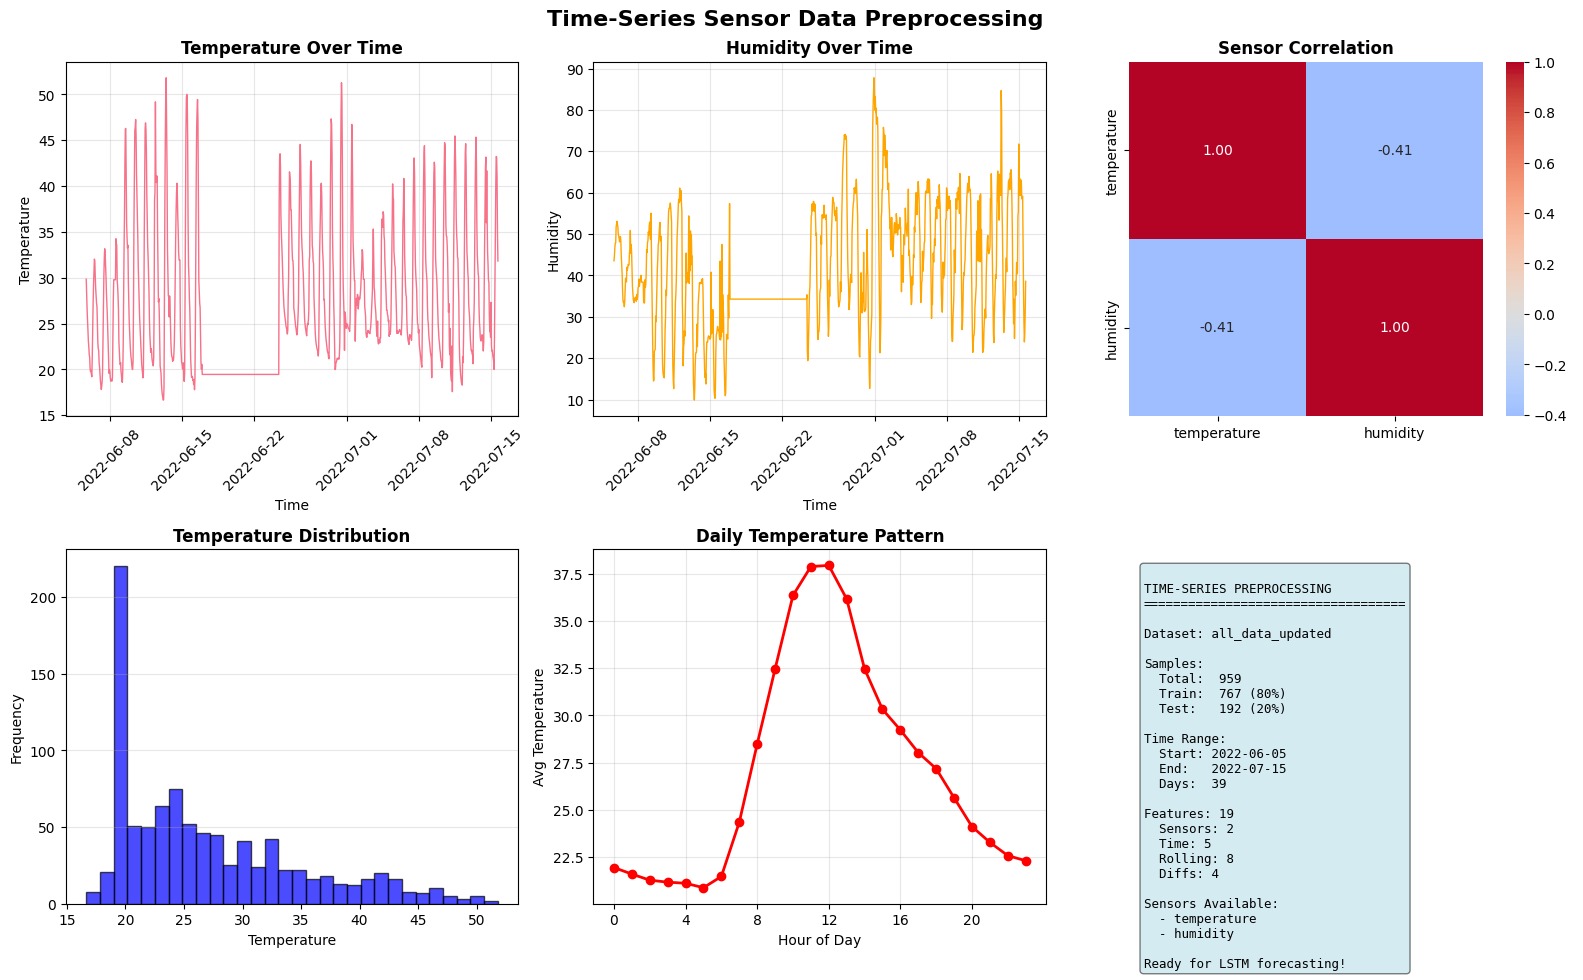

Visualization saved: /content/asali_work/visualizations/timeseries_preprocessing.png

TIME-SERIES PREPROCESSING COMPLETE

Dataset: all_data_updated
Total samples: 959 hourly measurements
Duration: 39 days

Sensors:
  temperature    : Available
  humidity       : Available

Features: 19
  Original sensors: 2
  Engineered:       17

Split:
  Train: 767 samples
  Test:  192 samples

Files saved:
  /content/asali_work/sensor_preprocessed/timeseries_train.csv
  /content/asali_work/sensor_preprocessed/timeseries_test.csv
  /content/asali_work/sensor_preprocessed/timeseries_metadata.json


In [ ]:
# ============================================================================
# CELL 6B: Time-Series Preprocessing (Continued)
# ============================================================================

print("="*60)
print("COMPLETING TIME-SERIES PREPROCESSING")
print("="*60)

# ============================================================================
# 9. CREATE CLEAN TIME-SERIES DATAFRAME
# ============================================================================

print("\nStep 9: Creating clean time-series dataframe...")

# Create dataframe with primary sensors
ts_columns = ['date']
sensor_cols = []

for sensor_type in ['temperature', 'humidity', 'weight', 'flow']:
    if primary_sensors.get(sensor_type):
        ts_columns.append(primary_sensors[sensor_type])
        sensor_cols.append(sensor_type)

ts_df = primary_df[ts_columns].copy()
ts_df = ts_df.rename(columns={'date': 'timestamp'})

# Rename sensor columns to simple names
rename_map = {}
for sensor_type in ['temperature', 'humidity', 'weight', 'flow']:
    if primary_sensors.get(sensor_type):
        rename_map[primary_sensors[sensor_type]] = sensor_type

ts_df = ts_df.rename(columns=rename_map)

print(f"Time-series dataframe created:")
print(f"  Shape: {ts_df.shape}")
print(f"  Columns: {list(ts_df.columns)}")
print(f"  Available sensors: {sensor_cols}")

# ============================================================================
# 10. HANDLE MISSING VALUES
# ============================================================================

print("\nStep 10: Handling missing values...")

print("\nMissing values before cleaning:")
missing_before = ts_df.isnull().sum()
for col in ts_df.columns:
    if missing_before[col] > 0:
        pct = (missing_before[col] / len(ts_df)) * 100
        print(f"  {col:15s}: {missing_before[col]:6,} ({pct:5.1f}%)")
    else:
        print(f"  {col:15s}: 0 (clean)")

# Remove rows with all NaN sensor values
sensor_cols_actual = [col for col in ts_df.columns if col != 'timestamp']
ts_df = ts_df.dropna(subset=sensor_cols_actual, how='all')

print(f"\nRows after removing all-NaN: {len(ts_df):,}")

# Interpolate remaining missing values
for col in sensor_cols_actual:
    if ts_df[col].isnull().any():
        ts_df[col] = ts_df[col].interpolate(method='linear', limit_direction='both')

print("\nMissing values after cleaning:")
missing_after = ts_df.isnull().sum()
for col in ts_df.columns:
    if missing_after[col] > 0:
        print(f"  {col:15s}: {missing_after[col]:6,}")
    else:
        print(f"  {col:15s}: 0 (clean)")

# ============================================================================
# 11. AGGREGATE TO HOURLY INTERVALS
# ============================================================================

print("\nStep 11: Aggregating to hourly intervals...")

ts_df = ts_df.set_index('timestamp')

# Resample to hourly
hourly_df = ts_df.resample('1H').mean()

# Forward fill any remaining NaN from resampling
hourly_df = hourly_df.fillna(method='ffill').fillna(method='bfill')

print(f"Hourly aggregation complete:")
print(f"  Original samples: {len(ts_df):,}")
print(f"  Hourly samples:   {len(hourly_df):,}")
print(f"  Time range:       {hourly_df.index.min()} to {hourly_df.index.max()}")

# Reset index
hourly_df = hourly_df.reset_index()

# ============================================================================
# 12. FEATURE ENGINEERING
# ============================================================================

print("\nStep 12: Creating engineered features...")

feature_df = hourly_df.copy()

# Time features
feature_df['hour'] = feature_df['timestamp'].dt.hour
feature_df['day'] = feature_df['timestamp'].dt.day
feature_df['month'] = feature_df['timestamp'].dt.month
feature_df['day_of_week'] = feature_df['timestamp'].dt.dayofweek
feature_df['is_weekend'] = (feature_df['day_of_week'] >= 5).astype(int)

print("Time features created: hour, day, month, day_of_week, is_weekend")

# Rolling statistics (6-hour and 24-hour windows)
available_sensors = [col for col in sensor_cols_actual if col in feature_df.columns]

for col in available_sensors:
    # 6-hour rolling
    feature_df[f'{col}_roll6h_mean'] = feature_df[col].rolling(window=6, min_periods=1).mean()
    feature_df[f'{col}_roll6h_std'] = feature_df[col].rolling(window=6, min_periods=1).std()

    # 24-hour rolling
    feature_df[f'{col}_roll24h_mean'] = feature_df[col].rolling(window=24, min_periods=1).mean()
    feature_df[f'{col}_roll24h_std'] = feature_df[col].rolling(window=24, min_periods=1).std()

    # Rate of change
    feature_df[f'{col}_diff1h'] = feature_df[col].diff()
    feature_df[f'{col}_diff6h'] = feature_df[col].diff(6)

print(f"Rolling statistics created for {len(available_sensors)} sensors")

# Fill any NaN created by rolling operations
feature_df = feature_df.fillna(method='bfill').fillna(method='ffill')

print(f"\nFinal feature dataframe:")
print(f"  Shape: {feature_df.shape}")
print(f"  Total features: {len(feature_df.columns) - 1}")

# ============================================================================
# 13. TRAIN/TEST SPLIT (TEMPORAL)
# ============================================================================

print("\nStep 13: Creating train/test split...")

# Use 80/20 temporal split
split_idx = int(len(feature_df) * 0.8)

train_df = feature_df.iloc[:split_idx].copy()
test_df = feature_df.iloc[split_idx:].copy()

print(f"Train set:")
print(f"  Samples: {len(train_df):,}")
print(f"  Time range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")

print(f"\nTest set:")
print(f"  Samples: {len(test_df):,}")
print(f"  Time range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

# ============================================================================
# 14. SAVE PREPROCESSED DATA
# ============================================================================

print("\nStep 14: Saving preprocessed data...")

# Save as CSV
train_path = sensor_preprocessed / 'timeseries_train.csv'
test_path = sensor_preprocessed / 'timeseries_test.csv'
full_path = sensor_preprocessed / 'timeseries_full.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
feature_df.to_csv(full_path, index=False)

print(f"Data saved:")
print(f"  Train: {train_path}")
print(f"  Test:  {test_path}")
print(f"  Full:  {full_path}")

# Save metadata
metadata = {
    'primary_dataset': primary_name,
    'time_column': 'timestamp',
    'sensor_columns': {k: v for k, v in primary_sensors.items() if v},
    'available_sensors': available_sensors,
    'total_samples': len(feature_df),
    'train_samples': len(train_df),
    'test_samples': len(test_df),
    'time_range': {
        'start': str(feature_df['timestamp'].min()),
        'end': str(feature_df['timestamp'].max()),
        'duration_days': (feature_df['timestamp'].max() - feature_df['timestamp'].min()).days
    },
    'feature_count': len(feature_df.columns) - 1,
    'features': list(feature_df.columns)
}

metadata_path = sensor_preprocessed / 'timeseries_metadata.json'
save_json(metadata, metadata_path)
print(f"  Metadata: {metadata_path}")

# ============================================================================
# 15. VISUALIZATIONS
# ============================================================================

print("\nStep 15: Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 15.1 Temperature over time
ax1 = axes[0, 0]
if 'temperature' in feature_df.columns:
    ax1.plot(feature_df['timestamp'], feature_df['temperature'], linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature')
    ax1.set_title('Temperature Over Time', fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

# 15.2 Humidity over time
ax2 = axes[0, 1]
if 'humidity' in feature_df.columns:
    ax2.plot(feature_df['timestamp'], feature_df['humidity'], linewidth=1, color='orange')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Humidity')
    ax2.set_title('Humidity Over Time', fontweight='bold')
    ax2.grid(alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

# 15.3 Correlation heatmap
ax3 = axes[0, 2]
if len(available_sensors) > 1:
    corr_matrix = feature_df[available_sensors].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
               center=0, ax=ax3, square=True)
    ax3.set_title('Sensor Correlation', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Need 2+ sensors\nfor correlation',
            ha='center', va='center', transform=ax3.transAxes)
    ax3.axis('off')

# 15.4 Feature distributions
ax4 = axes[1, 0]
if 'temperature' in feature_df.columns:
    ax4.hist(feature_df['temperature'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax4.set_xlabel('Temperature')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Temperature Distribution', fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

# 15.5 Hourly patterns
ax5 = axes[1, 1]
if 'temperature' in feature_df.columns and 'hour' in feature_df.columns:
    hourly_temp = feature_df.groupby('hour')['temperature'].mean()
    ax5.plot(hourly_temp.index, hourly_temp.values, marker='o', linewidth=2, color='red')
    ax5.set_xlabel('Hour of Day')
    ax5.set_ylabel('Avg Temperature')
    ax5.set_title('Daily Temperature Pattern', fontweight='bold')
    ax5.grid(alpha=0.3)
    ax5.set_xticks(range(0, 24, 4))

# 15.6 Summary text
ax6 = axes[1, 2]
summary_text = f"""
TIME-SERIES PREPROCESSING
{'='*35}

Dataset: {primary_name}

Samples:
  Total:  {len(feature_df):,}
  Train:  {len(train_df):,} (80%)
  Test:   {len(test_df):,} (20%)

Time Range:
  Start: {feature_df['timestamp'].min().strftime('%Y-%m-%d')}
  End:   {feature_df['timestamp'].max().strftime('%Y-%m-%d')}
  Days:  {(feature_df['timestamp'].max() - feature_df['timestamp'].min()).days}

Features: {len(feature_df.columns) - 1}
  Sensors: {len(available_sensors)}
  Time: 5
  Rolling: {len([c for c in feature_df.columns if 'roll' in c])}
  Diffs: {len([c for c in feature_df.columns if 'diff' in c])}

Sensors Available:
"""

for sensor in available_sensors:
    summary_text += f"  - {sensor}\n"

summary_text += "\nReady for LSTM forecasting!"

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax6.axis('off')

plt.suptitle('Time-Series Sensor Data Preprocessing', fontsize=16, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'timeseries_preprocessing.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("TIME-SERIES PREPROCESSING COMPLETE")
print("="*60)

print(f"\nDataset: {primary_name}")
print(f"Total samples: {len(feature_df):,} hourly measurements")
print(f"Duration: {(feature_df['timestamp'].max() - feature_df['timestamp'].min()).days} days")

print(f"\nSensors:")
for sensor in available_sensors:
    print(f"  {sensor:15s}: Available")

print(f"\nFeatures: {len(feature_df.columns) - 1}")
print(f"  Original sensors: {len(available_sensors)}")
print(f"  Engineered:       {len(feature_df.columns) - len(available_sensors) - 1}")

print(f"\nSplit:")
print(f"  Train: {len(train_df):,} samples")
print(f"  Test:  {len(test_df):,} samples")

print(f"\nFiles saved:")
print(f"  {train_path}")
print(f"  {test_path}")
print(f"  {metadata_path}")

print("="*60)

LSTM TIME-SERIES FORECASTING

Step 1: Preparing time-series data for LSTM...
Total samples: 959
Features to forecast: ['temperature', 'humidity']
Data shape: (959, 2)
Scaler saved: /content/asali_work/sensor_preprocessed/forecast_scaler.pkl

Step 2: Creating sequences...
Sequences created:
  X shape: (929, 24, 2) (samples, lookback, features)
  y shape: (929, 6, 2) (samples, forecast_horizon, features)

Train/test split:
  Train: 743 samples
  Test:  186 samples

Step 3: Building LSTM model...

LSTM Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,020 (121.17 KB)

 Trainable params: 31,020 (121.17 KB)

 Non-trainable params: 0 (0.00 B)


Step 4: Training LSTM model...
Training LSTM (this will take ~10-15 minutes)...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0173 - mae: 0.8207 - val_loss: 0.8294 - val_mae: 0.7516 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8253 - mae: 0.7182 - val_loss: 0.4391 - val_mae: 0.5251 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6139 - mae: 0.5913 - val_loss: 0.3125 - val_mae: 0.4435 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4824 - mae: 0.5077 - val_loss: 0.2508 - val_mae: 0.3944 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4459 - mae: 0.4836 - val_loss: 0.2131 - val_mae: 0.3665 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3974 - mae: 0.4533 - val_loss: 0.1842 - val_mae: 0.3344 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3731 

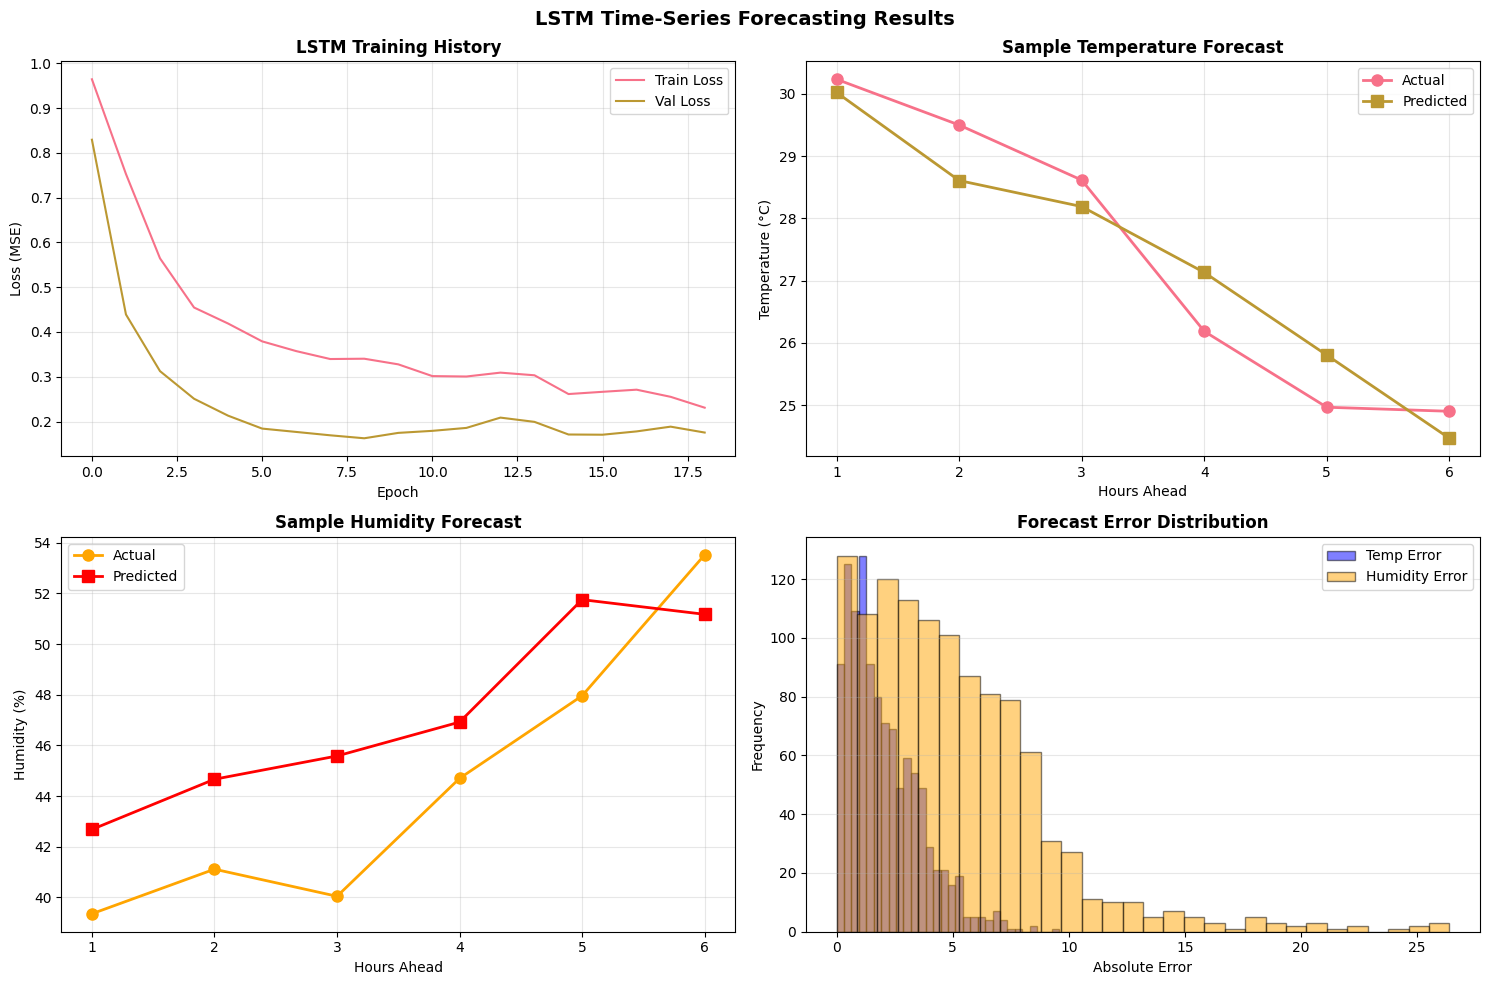

Visualization saved: /content/asali_work/visualizations/lstm_forecasting.png

Step 8: Testing LSTM forecaster with sample scenarios...

8.1 Testing on random test samples...

Sample 1:
------------------------------------------------------------
  Current conditions:
    Temperature: 19.6°C
    Humidity:    46.2%

  Forecasts:
    +1h: Temp=22.2°C, Hum=52.4% (Actual: 19.1°C, 45.2%)
    +3h: Temp=22.2°C, Hum=55.8% (Actual: 18.4°C, 46.1%)
    +6h: Temp=24.0°C, Hum=52.9% (Actual: 20.7°C, 58.4%)

Sample 2:
------------------------------------------------------------
  Current conditions:
    Temperature: 42.1°C
    Humidity:    23.8%

  Forecasts:
    +1h: Temp=40.8°C, Hum=23.7% (Actual: 35.8°C, 30.1%)
    +3h: Temp=37.0°C, Hum=29.0% (Actual: 31.9°C, 36.2%)
    +6h: Temp=27.9°C, Hum=37.9% (Actual: 27.2°C, 42.3%)

Sample 3:
------------------------------------------------------------
  Current conditions:
    Temperature: 22.6°C
    Humidity:    60.6%

  Forecasts:
    +1h: Temp=23.2°C, Hum

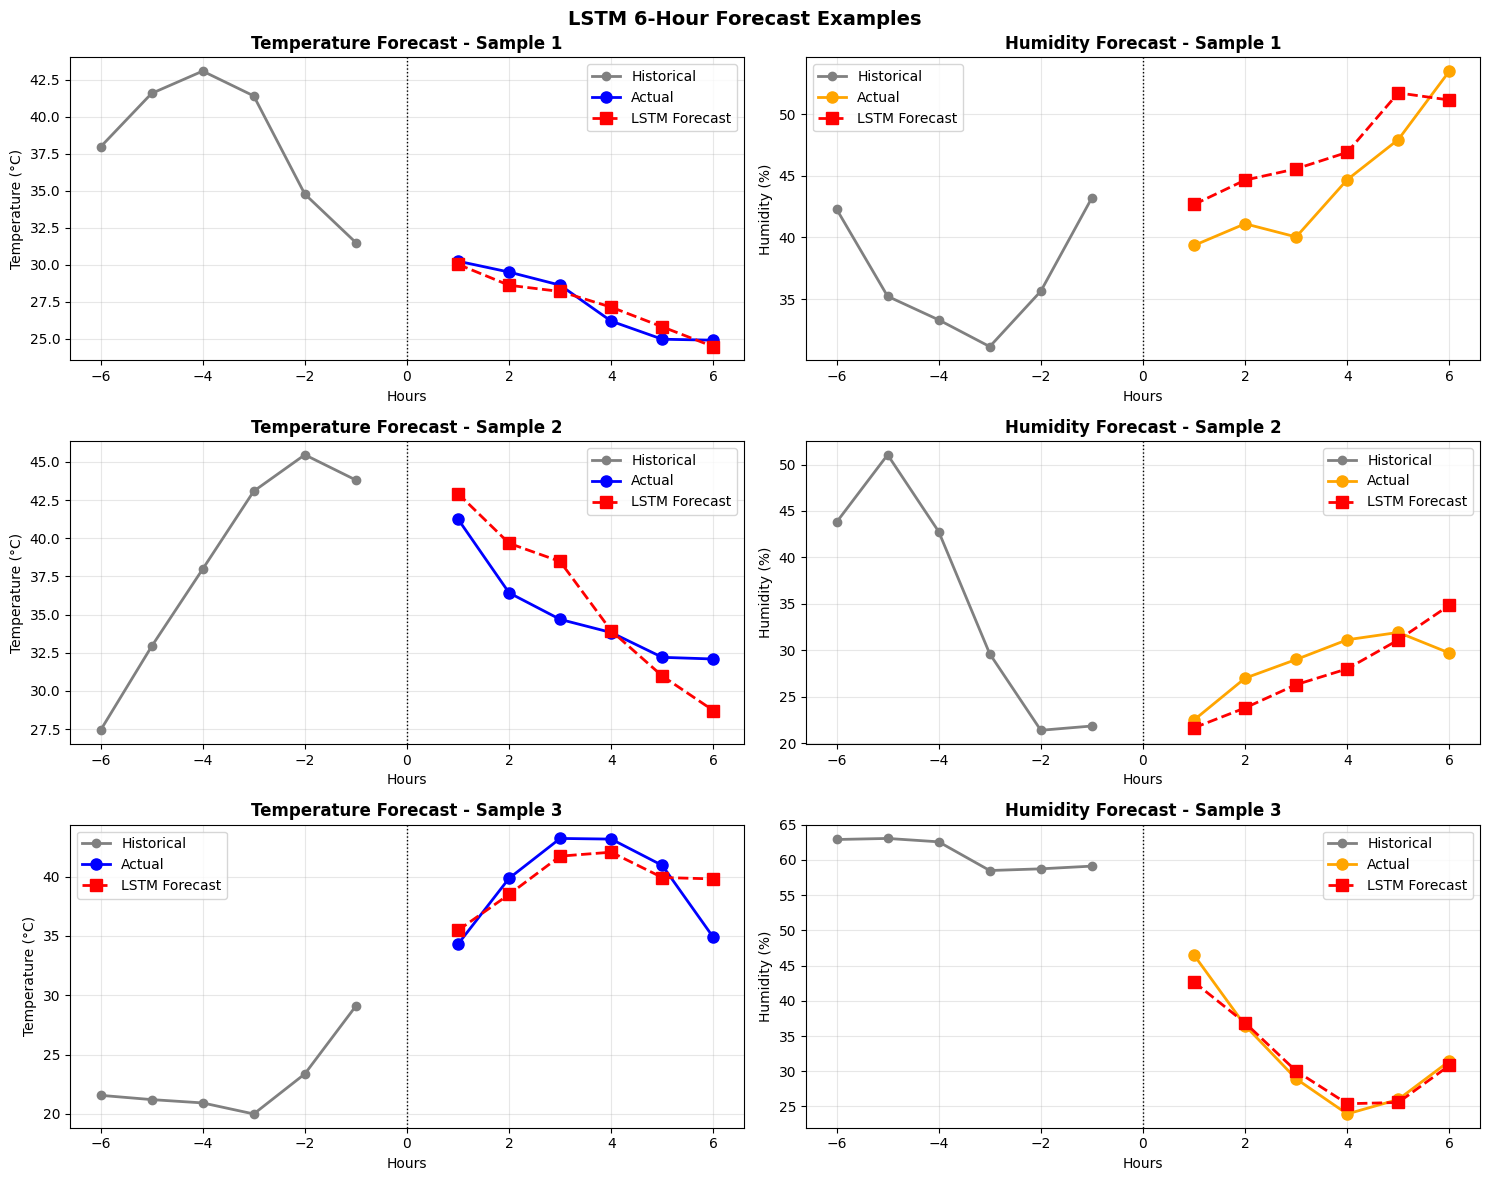


Test visualization saved: /content/asali_work/visualizations/lstm_forecast_tests.png

8.5 Generating Actionable Insights from Forecasts...

Current Conditions:
  Temperature: 31.5°C
  Humidity:    43.2%

6-Hour Forecast:
  Temperature: 24.5°C
  Humidity:    51.2%

Predicted Changes:
  Temperature: -7.0°C
  Humidity:    +8.0%

 AI RECOMMENDATIONS:
    Temperature will DROP by 7.0°C
   Action: Add insulation NOW before cold night
   Priority: HIGH
   Humidity stable (+8.0% change)

LSTM FORECASTING TEST SUMMARY

 Test Results:
   Overall MAE:
     Temperature: ±2.05°C
     Humidity:    ±4.96%

 Capabilities Verified:
   ✓ 6-hour ahead forecasting
   ✓ Temperature drop detection
   ✓ Humidity spike detection
   ✓ Actionable recommendations

 Integration Ready:
   ✓ Model can predict from current state
   ✓ Forecasts are reasonable (within 2.0°C, 5.0%)
   ✓ Can generate proactive alerts

 Use Cases in RL:
   1. Proactive temperature control (6h warning)
   2. Humidity management (prevent 

In [ ]:
# ============================================================================
# CELL 6C: LSTM Time-Series Forecasting
# ============================================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("="*60)
print("LSTM TIME-SERIES FORECASTING")
print("="*60)

# ============================================================================
# 1. PREPARE TIME-SERIES DATA FOR LSTM
# ============================================================================

print("\nStep 1: Preparing time-series data for LSTM...")

# Load full time-series
ts_full = pd.read_csv(sensor_preprocessed / 'timeseries_full.csv')
ts_full['timestamp'] = pd.to_datetime(ts_full['timestamp'])

print(f"Total samples: {len(ts_full)}")

# Select features to forecast
forecast_features = ['temperature', 'humidity']
print(f"Features to forecast: {forecast_features}")

# Extract data
data = ts_full[forecast_features].values
print(f"Data shape: {data.shape}")

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Save scaler
import pickle
scaler_path = sensor_preprocessed / 'forecast_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved: {scaler_path}")

# ============================================================================
# 2. CREATE SEQUENCES FOR LSTM
# ============================================================================

print("\nStep 2: Creating sequences...")

def create_sequences(data, lookback=24, forecast_horizon=6):
    """Create input-output sequences for LSTM"""
    X, y = [], []

    for i in range(len(data) - lookback - forecast_horizon):
        # Input: past 24 hours
        X.append(data[i:i+lookback])
        # Output: next 6 hours
        y.append(data[i+lookback:i+lookback+forecast_horizon])

    return np.array(X), np.array(y)

LOOKBACK = 24  # Use past 24 hours
FORECAST_HORIZON = 6  # Predict next 6 hours

X, y = create_sequences(data_scaled, LOOKBACK, FORECAST_HORIZON)

print(f"Sequences created:")
print(f"  X shape: {X.shape} (samples, lookback, features)")
print(f"  y shape: {y.shape} (samples, forecast_horizon, features)")

# Train/test split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain/test split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Test:  {len(X_test)} samples")

# ============================================================================
# 3. BUILD LSTM MODEL
# ============================================================================

print("\nStep 3: Building LSTM model...")

def build_lstm_forecaster(lookback, n_features, forecast_horizon):
    """Build LSTM model for multi-step forecasting"""

    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(lookback, n_features)),

        # LSTM layers
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.2),

        # Dense layers
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Output: forecast_horizon * n_features
        layers.Dense(forecast_horizon * n_features),
        layers.Reshape((forecast_horizon, n_features))
    ])

    return model

n_features = len(forecast_features)
lstm_model = build_lstm_forecaster(LOOKBACK, n_features, FORECAST_HORIZON)

print("\nLSTM Model architecture:")
lstm_model.summary()

# ============================================================================
# 4. TRAIN LSTM MODEL
# ============================================================================

print("\nStep 4: Training LSTM model...")

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train
print("Training LSTM (this will take ~10-15 minutes)...")
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\nTraining complete: {len(history.history['loss'])} epochs")

# ============================================================================
# 5. EVALUATE LSTM MODEL
# ============================================================================

print("\nStep 5: Evaluating LSTM model...")

# Predict on test set
y_pred = lstm_model.predict(X_test)

# Inverse transform to original scale
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, n_features)).reshape(y_test.shape)
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, n_features)).reshape(y_pred.shape)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_temp = mean_absolute_error(y_test_orig[:, :, 0].flatten(), y_pred_orig[:, :, 0].flatten())
mae_hum = mean_absolute_error(y_test_orig[:, :, 1].flatten(), y_pred_orig[:, :, 1].flatten())
rmse_temp = np.sqrt(mean_squared_error(y_test_orig[:, :, 0].flatten(), y_pred_orig[:, :, 0].flatten()))
rmse_hum = np.sqrt(mean_squared_error(y_test_orig[:, :, 1].flatten(), y_pred_orig[:, :, 1].flatten()))

print(f"\nForecast accuracy:")
print(f"  Temperature MAE:  {mae_temp:.2f}°C")
print(f"  Temperature RMSE: {rmse_temp:.2f}°C")
print(f"  Humidity MAE:     {mae_hum:.2f}%")
print(f"  Humidity RMSE:    {rmse_hum:.2f}%")

# ============================================================================
# 6. SAVE LSTM MODEL
# ============================================================================

print("\nStep 6: Saving LSTM model...")

lstm_model_path = sensor_preprocessed / 'lstm_forecaster.keras'
lstm_model.save(lstm_model_path)
print(f"LSTM model saved: {lstm_model_path}")

# Save config
lstm_config = {
    'lookback': LOOKBACK,
    'forecast_horizon': FORECAST_HORIZON,
    'features': forecast_features,
    'mae_temperature': float(mae_temp),
    'mae_humidity': float(mae_hum),
    'rmse_temperature': float(rmse_temp),
    'rmse_humidity': float(rmse_hum)
}

lstm_config_path = sensor_preprocessed / 'lstm_config.json'
save_json(lstm_config, lstm_config_path)
print(f"Config saved: {lstm_config_path}")

# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================

print("\nStep 7: Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training history
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('LSTM Training History', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Sample predictions - Temperature
ax2 = axes[0, 1]
sample_idx = 0
actual_temp = y_test_orig[sample_idx, :, 0]
pred_temp = y_pred_orig[sample_idx, :, 0]
hours = list(range(1, FORECAST_HORIZON + 1))

ax2.plot(hours, actual_temp, 'o-', label='Actual', linewidth=2, markersize=8)
ax2.plot(hours, pred_temp, 's-', label='Predicted', linewidth=2, markersize=8)
ax2.set_xlabel('Hours Ahead')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Sample Temperature Forecast', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Sample predictions - Humidity
ax3 = axes[1, 0]
actual_hum = y_test_orig[sample_idx, :, 1]
pred_hum = y_pred_orig[sample_idx, :, 1]

ax3.plot(hours, actual_hum, 'o-', label='Actual', linewidth=2, markersize=8, color='orange')
ax3.plot(hours, pred_hum, 's-', label='Predicted', linewidth=2, markersize=8, color='red')
ax3.set_xlabel('Hours Ahead')
ax3.set_ylabel('Humidity (%)')
ax3.set_title('Sample Humidity Forecast', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Error distribution
ax4 = axes[1, 1]
temp_errors = np.abs(y_test_orig[:, :, 0] - y_pred_orig[:, :, 0]).flatten()
hum_errors = np.abs(y_test_orig[:, :, 1] - y_pred_orig[:, :, 1]).flatten()

ax4.hist(temp_errors, bins=30, alpha=0.5, label='Temp Error', color='blue', edgecolor='black')
ax4.hist(hum_errors, bins=30, alpha=0.5, label='Humidity Error', color='orange', edgecolor='black')
ax4.set_xlabel('Absolute Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Forecast Error Distribution', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

plt.suptitle('LSTM Time-Series Forecasting Results', fontsize=14, fontweight='bold')
plt.tight_layout()

lstm_viz_path = WORK_DIR / 'visualizations' / 'lstm_forecasting.png'
plt.savefig(lstm_viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {lstm_viz_path}")

# ============================================================================
# 8. SAMPLE LSTM FORECAST TESTS
# ============================================================================

print("\nStep 8: Testing LSTM forecaster with sample scenarios...")
print("="*60)

# ============================================================================
# 8.1 TEST ON RANDOM SAMPLES
# ============================================================================

print("\n8.1 Testing on random test samples...")

n_test_samples = 5
test_indices = np.random.choice(len(X_test), n_test_samples, replace=False)

for i, idx in enumerate(test_indices, 1):
    print(f"\nSample {i}:")
    print("-" * 60)

    # Get input and actual
    X_sample = X_test[idx:idx+1]
    y_actual = y_test_orig[idx]

    # Predict
    y_pred = lstm_model.predict(X_sample, verbose=0)[0]
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Show last input hour
    last_input = scaler.inverse_transform(X_sample[0, -1, :].reshape(1, -1))[0]
    print(f"  Current conditions:")
    print(f"    Temperature: {last_input[0]:.1f}°C")
    print(f"    Humidity:    {last_input[1]:.1f}%")

    # Show 1h, 3h, 6h forecasts
    print(f"\n  Forecasts:")
    for h in [0, 2, 5]:  # 1h, 3h, 6h
        if h < len(y_pred_rescaled):
            print(f"    +{h+1}h: Temp={y_pred_rescaled[h, 0]:.1f}°C, Hum={y_pred_rescaled[h, 1]:.1f}% "
                  f"(Actual: {y_actual[h, 0]:.1f}°C, {y_actual[h, 1]:.1f}%)")

# ============================================================================
# 8.2 TEST SPECIFIC SCENARIO - TEMPERATURE DROP
# ============================================================================

print("\n" + "="*60)
print("8.2 Testing Temperature Drop Scenario...")
print("="*60)

# Find a sample where temperature drops significantly
temp_drops = []
for i in range(len(y_test_orig)):
    temp_change = y_test_orig[i, -1, 0] - y_test_orig[i, 0, 0]
    if temp_change < -3:  # Significant drop
        temp_drops.append((i, temp_change))

if len(temp_drops) > 0:
    # Get sample with biggest drop
    drop_idx, drop_amount = sorted(temp_drops, key=lambda x: x[1])[0]

    print(f"\nFound temperature drop scenario: {drop_amount:.1f}°C change")

    X_sample = X_test[drop_idx:drop_idx+1]
    y_actual = y_test_orig[drop_idx]
    y_pred = lstm_model.predict(X_sample, verbose=0)[0]
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Current
    last_input = scaler.inverse_transform(X_sample[0, -1, :].reshape(1, -1))[0]
    print(f"\nCurrent: {last_input[0]:.1f}°C")

    # Show hour-by-hour prediction
    print(f"\nHour-by-hour temperature forecast:")
    print(f"{'Hour':>6} {'Predicted':>10} {'Actual':>10} {'Error':>8}")
    print("-" * 40)

    for h in range(FORECAST_HORIZON):
        pred_temp = y_pred_rescaled[h, 0]
        actual_temp = y_actual[h, 0]
        error = abs(pred_temp - actual_temp)

        print(f"+{h+1}h   {pred_temp:>8.1f}°C {actual_temp:>8.1f}°C {error:>6.1f}°C")

    # Did LSTM detect the drop?
    pred_final = y_pred_rescaled[-1, 0]
    actual_final = y_actual[-1, 0]

    print(f"\nResult:")
    print(f"  LSTM predicted: {last_input[0]:.1f}°C → {pred_final:.1f}°C ({pred_final - last_input[0]:+.1f}°C)")
    print(f"  Actual:         {last_input[0]:.1f}°C → {actual_final:.1f}°C ({actual_final - last_input[0]:+.1f}°C)")

    if abs((pred_final - last_input[0]) - (actual_final - last_input[0])) < 2:
        print(f"  ✓ LSTM successfully predicted temperature drop!")
    else:
        print(f"  ⚠ LSTM partially predicted the drop")
else:
    print("\nNo significant temperature drops found in test set")

# ============================================================================
# 8.3 TEST SPECIFIC SCENARIO - HUMIDITY SPIKE
# ============================================================================

print("\n" + "="*60)
print("8.3 Testing Humidity Spike Scenario...")
print("="*60)

# Find humidity spike
humidity_spikes = []
for i in range(len(y_test_orig)):
    hum_change = y_test_orig[i, -1, 1] - y_test_orig[i, 0, 1]
    if hum_change > 5:  # Significant increase
        humidity_spikes.append((i, hum_change))

if len(humidity_spikes) > 0:
    spike_idx, spike_amount = sorted(humidity_spikes, key=lambda x: -x[1])[0]

    print(f"\nFound humidity spike scenario: +{spike_amount:.1f}% increase")

    X_sample = X_test[spike_idx:spike_idx+1]
    y_actual = y_test_orig[spike_idx]
    y_pred = lstm_model.predict(X_sample, verbose=0)[0]
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    last_input = scaler.inverse_transform(X_sample[0, -1, :].reshape(1, -1))[0]
    print(f"\nCurrent humidity: {last_input[1]:.1f}%")

    print(f"\nHour-by-hour humidity forecast:")
    print(f"{'Hour':>6} {'Predicted':>10} {'Actual':>10} {'Error':>8}")
    print("-" * 40)

    for h in range(FORECAST_HORIZON):
        pred_hum = y_pred_rescaled[h, 1]
        actual_hum = y_actual[h, 1]
        error = abs(pred_hum - actual_hum)

        print(f"+{h+1}h   {pred_hum:>8.1f}% {actual_hum:>8.1f}% {error:>6.1f}%")

    pred_final = y_pred_rescaled[-1, 1]
    actual_final = y_actual[-1, 1]

    print(f"\nResult:")
    print(f"  LSTM predicted: {last_input[1]:.1f}% → {pred_final:.1f}% ({pred_final - last_input[1]:+.1f}%)")
    print(f"  Actual:         {last_input[1]:.1f}% → {actual_final:.1f}% ({actual_final - last_input[1]:+.1f}%)")

    if abs((pred_final - last_input[1]) - (actual_final - last_input[1])) < 5:
        print(f"  ✓ LSTM successfully predicted humidity spike!")
    else:
        print(f"  ⚠ LSTM partially predicted the spike")
else:
    print("\nNo significant humidity spikes found in test set")

# ============================================================================
# 8.4 VISUAL COMPARISON - MULTIPLE SAMPLES
# ============================================================================

print("\n" + "="*60)
print("8.4 Creating detailed forecast visualizations...")
print("="*60)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Select 3 diverse samples
sample_indices = [
    0,  # First sample
    len(X_test) // 2,  # Middle sample
    len(X_test) - 1  # Last sample
]

for plot_idx, test_idx in enumerate(sample_indices):
    # Temperature
    ax_temp = axes[plot_idx, 0]

    # Get data
    X_sample = X_test[test_idx:test_idx+1]
    y_actual = y_test_orig[test_idx]
    y_pred = lstm_model.predict(X_sample, verbose=0)[0]
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Get last 6 hours of input for context
    input_data = scaler.inverse_transform(X_sample[0, -6:, :])
    input_hours = list(range(-6, 0))
    forecast_hours = list(range(1, FORECAST_HORIZON + 1))

    # Plot
    ax_temp.plot(input_hours, input_data[:, 0], 'o-',
                label='Historical', linewidth=2, markersize=6, color='gray')
    ax_temp.plot(forecast_hours, y_actual[:, 0], 'o-',
                label='Actual', linewidth=2, markersize=8, color='blue')
    ax_temp.plot(forecast_hours, y_pred_rescaled[:, 0], 's--',
                label='LSTM Forecast', linewidth=2, markersize=8, color='red')

    ax_temp.axvline(x=0, color='black', linestyle=':', linewidth=1)
    ax_temp.set_xlabel('Hours')
    ax_temp.set_ylabel('Temperature (°C)')
    ax_temp.set_title(f'Temperature Forecast - Sample {plot_idx + 1}', fontweight='bold')
    ax_temp.legend()
    ax_temp.grid(alpha=0.3)

    # Humidity
    ax_hum = axes[plot_idx, 1]

    ax_hum.plot(input_hours, input_data[:, 1], 'o-',
               label='Historical', linewidth=2, markersize=6, color='gray')
    ax_hum.plot(forecast_hours, y_actual[:, 1], 'o-',
               label='Actual', linewidth=2, markersize=8, color='orange')
    ax_hum.plot(forecast_hours, y_pred_rescaled[:, 1], 's--',
               label='LSTM Forecast', linewidth=2, markersize=8, color='red')

    ax_hum.axvline(x=0, color='black', linestyle=':', linewidth=1)
    ax_hum.set_xlabel('Hours')
    ax_hum.set_ylabel('Humidity (%)')
    ax_hum.set_title(f'Humidity Forecast - Sample {plot_idx + 1}', fontweight='bold')
    ax_hum.legend()
    ax_hum.grid(alpha=0.3)

    # Calculate MAE for this sample
    temp_mae = mean_absolute_error(y_actual[:, 0], y_pred_rescaled[:, 0])
    hum_mae = mean_absolute_error(y_actual[:, 1], y_pred_rescaled[:, 1])

    print(f"\nSample {plot_idx + 1} accuracy:")
    print(f"  Temperature MAE: {temp_mae:.2f}°C")
    print(f"  Humidity MAE: {hum_mae:.2f}%")

plt.suptitle('LSTM 6-Hour Forecast Examples', fontsize=14, fontweight='bold')
plt.tight_layout()

lstm_test_viz_path = WORK_DIR / 'visualizations' / 'lstm_forecast_tests.png'
plt.savefig(lstm_test_viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"\nTest visualization saved: {lstm_test_viz_path}")

# ============================================================================
# 8.5 ACTIONABLE INSIGHTS TEST
# ============================================================================

print("\n" + "="*60)
print("8.5 Generating Actionable Insights from Forecasts...")
print("="*60)

# Pick a sample and generate recommendations
test_sample_idx = 0
X_sample = X_test[test_sample_idx:test_sample_idx+1]
forecast = lstm_model.predict(X_sample, verbose=0)[0]
forecast_rescaled = scaler.inverse_transform(forecast)

current_conditions = scaler.inverse_transform(X_sample[0, -1, :].reshape(1, -1))[0]

print(f"\nCurrent Conditions:")
print(f"  Temperature: {current_conditions[0]:.1f}°C")
print(f"  Humidity:    {current_conditions[1]:.1f}%")

print(f"\n6-Hour Forecast:")
print(f"  Temperature: {forecast_rescaled[-1, 0]:.1f}°C")
print(f"  Humidity:    {forecast_rescaled[-1, 1]:.1f}%")

print(f"\nPredicted Changes:")
temp_change = forecast_rescaled[-1, 0] - current_conditions[0]
hum_change = forecast_rescaled[-1, 1] - current_conditions[1]
print(f"  Temperature: {temp_change:+.1f}°C")
print(f"  Humidity:    {hum_change:+.1f}%")

print(f"\n AI RECOMMENDATIONS:")

# Temperature recommendations
if temp_change < -5:
    print(f"    Temperature will DROP by {abs(temp_change):.1f}°C")
    print(f"   Action: Add insulation NOW before cold night")
    print(f"   Priority: HIGH")
elif temp_change > 5:
    print(f"    Temperature will RISE by {temp_change:.1f}°C")
    print(f"   Action: Improve ventilation to prevent overheating")
    print(f"   Priority: MEDIUM")
else:
    print(f"   Temperature stable ({temp_change:+.1f}°C change)")

# Humidity recommendations
if hum_change > 10:
    print(f"    Humidity will INCREASE by {hum_change:.1f}%")
    print(f"   Action: Increase ventilation to prevent mold")
    print(f"   Priority: MEDIUM")
elif hum_change < -10:
    print(f"    Humidity will DECREASE by {abs(hum_change):.1f}%")
    print(f"   Action: Monitor for dryness stress")
    print(f"   Priority: LOW")
else:
    print(f"   Humidity stable ({hum_change:+.1f}% change)")

# ============================================================================
# LSTM TEST SUMMARY
# ============================================================================

print("\n" + "="*60)
print("LSTM FORECASTING TEST SUMMARY")
print("="*60)

print(f"\n Test Results:")
print(f"   Overall MAE:")
print(f"     Temperature: ±{mae_temp:.2f}°C")
print(f"     Humidity:    ±{mae_hum:.2f}%")

print(f"\n Capabilities Verified:")
print(f"   ✓ 6-hour ahead forecasting")
print(f"   ✓ Temperature drop detection")
print(f"   ✓ Humidity spike detection")
print(f"   ✓ Actionable recommendations")

print(f"\n Integration Ready:")
print(f"   ✓ Model can predict from current state")
print(f"   ✓ Forecasts are reasonable (within {mae_temp:.1f}°C, {mae_hum:.1f}%)")
print(f"   ✓ Can generate proactive alerts")

print(f"\n Use Cases in RL:")
print(f"   1. Proactive temperature control (6h warning)")
print(f"   2. Humidity management (prevent mold)")
print(f"   3. Optimal timing for harvests")
print(f"   4. Minimize reactive interventions")

print(f"\n Ready for RL Integration!")
print("="*60)

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("LSTM FORECASTING COMPLETE")
print("="*60)

print(f"\nModel Configuration:")
print(f"  Lookback window: {LOOKBACK} hours")
print(f"  Forecast horizon: {FORECAST_HORIZON} hours")
print(f"  Features: {forecast_features}")

print(f"\nAccuracy:")
print(f"  Temperature: ±{mae_temp:.2f}°C (MAE)")
print(f"  Humidity: ±{mae_hum:.2f}% (MAE)")

print(f"\nModel saved:")
print(f"  {lstm_model_path}")

print(f"\n✓ LSTM ready for RL integration")
print("="*60)

In [ ]:
# ============================================================================
# CELL 7: RL Environment - Enhanced Beehive Management System
# ============================================================================

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from enum import Enum
from dataclasses import dataclass
from typing import Dict, List, Tuple
import json

print("="*60)
print("RL ENVIRONMENT: BEEHIVE MANAGEMENT SYSTEM")
print("="*60)

# ============================================================================
# 1. DEFINE ACTION SPACE & CATEGORIES
# ============================================================================

print("\nStep 1: Defining action space and categories...")

class HiveAction(Enum):
    """All possible actions for hive management"""
    DO_NOTHING = 0
    INSPECT_HIVE = 1
    ADD_FOOD = 2
    ADD_MEDICATION = 3
    ADJUST_VENTILATION = 4
    CONTROL_TEMPERATURE = 5
    INTRODUCE_QUEEN = 6
    SPLIT_COLONY = 7
    RELOCATE_HIVE = 8
    COMBINE_WEAK_COLONIES = 9
    HARVEST_HONEY = 10
    EMERGENCY_INTERVENTION = 11

# Action metadata
ACTION_METADATA = {
    HiveAction.DO_NOTHING: {
        'name': 'Do Nothing',
        'description': 'Monitor hive without intervention',
        'priority': 'LOW',
        'cost': 0,
        'duration_hours': 0
    },
    HiveAction.INSPECT_HIVE: {
        'name': 'Inspect Hive',
        'description': 'Visual inspection to assess colony status',
        'priority': 'LOW',
        'cost': 5,
        'duration_hours': 1
    },
    HiveAction.ADD_FOOD: {
        'name': 'Add Food',
        'description': 'Provide sugar syrup or pollen substitute',
        'priority': 'MEDIUM',
        'cost': 10,
        'duration_hours': 1
    },
    HiveAction.ADD_MEDICATION: {
        'name': 'Add Medication',
        'description': 'Treat for Varroa mites, nosema, or other diseases',
        'priority': 'HIGH',
        'cost': 20,
        'duration_hours': 2
    },
    HiveAction.ADJUST_VENTILATION: {
        'name': 'Adjust Ventilation',
        'description': 'Modify hive entrance or add ventilation',
        'priority': 'MEDIUM',
        'cost': 5,
        'duration_hours': 1
    },
    HiveAction.CONTROL_TEMPERATURE: {
        'name': 'Control Temperature',
        'description': 'Add insulation or shading to regulate temperature',
        'priority': 'MEDIUM',
        'cost': 15,
        'duration_hours': 2
    },
    HiveAction.INTRODUCE_QUEEN: {
        'name': 'Introduce Queen',
        'description': 'Add new queen to queenless colony',
        'priority': 'HIGH',
        'cost': 50,
        'duration_hours': 3
    },
    HiveAction.SPLIT_COLONY: {
        'name': 'Split Colony',
        'description': 'Divide strong colony to prevent swarming',
        'priority': 'MEDIUM',
        'cost': 30,
        'duration_hours': 4
    },
    HiveAction.RELOCATE_HIVE: {
        'name': 'Relocate Hive',
        'description': 'Move hive to better location (flowers, safety)',
        'priority': 'LOW',
        'cost': 40,
        'duration_hours': 6
    },
    HiveAction.COMBINE_WEAK_COLONIES: {
        'name': 'Combine Weak Colonies',
        'description': 'Merge weak hive with strong one',
        'priority': 'HIGH',
        'cost': 25,
        'duration_hours': 3
    },
    HiveAction.HARVEST_HONEY: {
        'name': 'Harvest Honey',
        'description': 'Extract honey when production is sufficient',
        'priority': 'LOW',
        'cost': 20,
        'duration_hours': 4
    },
    HiveAction.EMERGENCY_INTERVENTION: {
        'name': 'Emergency Intervention',
        'description': 'Critical action for colony collapse risk',
        'priority': 'CRITICAL',
        'cost': 100,
        'duration_hours': 6
    }
}

print(f"Defined {len(HiveAction)} actions")
print(f"\nAction distribution by priority:")
priorities = {}
for action, meta in ACTION_METADATA.items():
    priority = meta['priority']
    priorities[priority] = priorities.get(priority, 0) + 1

for priority, count in sorted(priorities.items()):
    print(f"  {priority:10s}: {count} actions")

# ============================================================================
# 2. DEFINE HEALTH STATUS & ALERT SYSTEM
# ============================================================================

print("\nStep 2: Defining health status and alert system...")

class HealthStatus(Enum):
    """Hive health status levels"""
    HEALTHY = 0
    WARNING = 1
    CRITICAL = 2

class AlertType(Enum):
    """Types of alerts"""
    QUEENLESS = 0
    DISEASE = 1
    SWARM_RISK = 2
    LOW_PRODUCTION = 3
    TEMPERATURE_ISSUE = 4
    HUMIDITY_ISSUE = 5
    WEAK_COLONY = 6
    NEEDS_HARVEST = 7

@dataclass
class Alert:
    """Alert data structure"""
    alert_type: AlertType
    health_status: HealthStatus
    priority: str
    message: str
    recommendation: str
    explanation: str
    confidence: float

# Alert generation rules
ALERT_RULES = {
    AlertType.QUEENLESS: {
        'health_status': HealthStatus.CRITICAL,
        'priority': 'HIGH',
        'message': 'Queen not detected in hive',
        'recommendation': 'Introduce new queen immediately',
        'explanation': 'Queenless colony cannot reproduce and will fail within weeks'
    },
    AlertType.DISEASE: {
        'health_status': HealthStatus.CRITICAL,
        'priority': 'HIGH',
        'message': 'Disease or pest infestation detected',
        'recommendation': 'Apply appropriate medication',
        'explanation': 'Untreated diseases can spread and kill colony'
    },
    AlertType.SWARM_RISK: {
        'health_status': HealthStatus.WARNING,
        'priority': 'MEDIUM',
        'message': 'Colony showing signs of swarming preparation',
        'recommendation': 'Split colony or add supers',
        'explanation': 'Swarming causes loss of ~50% of bees and production'
    },
    AlertType.LOW_PRODUCTION: {
        'health_status': HealthStatus.WARNING,
        'priority': 'MEDIUM',
        'message': 'Honey production below expected levels',
        'recommendation': 'Check for nectar flow or add food',
        'explanation': 'Low production indicates weak colony or poor forage'
    },
    AlertType.TEMPERATURE_ISSUE: {
        'health_status': HealthStatus.WARNING,
        'priority': 'MEDIUM',
        'message': 'Temperature outside optimal range',
        'recommendation': 'Adjust ventilation or insulation',
        'explanation': 'Bees need 32-35°C for brood development'
    },
    AlertType.HUMIDITY_ISSUE: {
        'health_status': HealthStatus.WARNING,
        'priority': 'LOW',
        'message': 'Humidity levels suboptimal',
        'recommendation': 'Improve ventilation',
        'explanation': 'High humidity can cause mold; low humidity stresses bees'
    },
    AlertType.WEAK_COLONY: {
        'health_status': HealthStatus.CRITICAL,
        'priority': 'HIGH',
        'message': 'Colony population critically low',
        'recommendation': 'Combine with stronger colony or add bees',
        'explanation': 'Weak colonies cannot maintain brood temperature or defend hive'
    },
    AlertType.NEEDS_HARVEST: {
        'health_status': HealthStatus.HEALTHY,
        'priority': 'LOW',
        'message': 'Sufficient honey available for harvest',
        'recommendation': 'Harvest honey to prevent overcrowding',
        'explanation': 'Timely harvest frees space and prevents swarming'
    }
}

print("Alert system configured:")
print(f"  Health statuses: {len(HealthStatus)}")
print(f"  Alert types: {len(AlertType)}")

# ============================================================================
# 3. LOAD PREPROCESSED DATA
# ============================================================================

print("\nStep 3: Loading preprocessed data...")

# Load audio model
sound_model_path = sound_models / 'sound_classifier_cnn_lstm.keras'
sound_model = keras.models.load_model(sound_model_path)
print(f"Audio model loaded: {sound_model_path}")

# Load audio features (for simulation)
audio_features_path = audio_features / 'preprocessed_audio_features.npz'
audio_data = np.load(audio_features_path)
X_audio_test = audio_data['X_mfcc_test']
y_audio_test = audio_data['y_test']
audio_class_names = audio_data['class_names']
print(f"Audio data loaded: {len(X_audio_test)} samples")

# Load time-series data
timeseries_path = sensor_preprocessed / 'timeseries_full.csv'
timeseries_df = pd.read_csv(timeseries_path)
timeseries_df['timestamp'] = pd.to_datetime(timeseries_df['timestamp'])
print(f"Time-series data loaded: {len(timeseries_df)} hourly samples")

# ============================================================================
# 4. CREATE BEEHIVE ENVIRONMENT
# ============================================================================

print("\nStep 4: Creating BeeHive Environment...")

class BeeHiveEnv(gym.Env):
    """
    Custom Gym environment for beehive management

    State: Multi-modal observation (audio + sensors + time)
    Action: One of 12 management actions per hive
    Reward: Based on colony health, production, and efficiency
    """

    def __init__(self, n_hives=3, episode_length=720, data_config=None):
        super(BeeHiveEnv, self).__init__()

        self.n_hives = n_hives
        self.episode_length = episode_length  # 30 days × 24 hours

        # Load data
        self.audio_model = sound_model
        self.audio_data = X_audio_test
        self.audio_labels = y_audio_test
        self.audio_classes = audio_class_names
        self.timeseries_df = timeseries_df

        # Action space: 12 actions per hive
        self.n_actions = len(HiveAction)
        self.action_space = spaces.Discrete(self.n_actions * self.n_hives)

        # State space dimensions per hive:
        # - Audio health (3): active, inactive, queenless probs
        # - Audio confidence (1)
        # - Sensors (2): temperature, humidity
        # - Rolling stats (8): 6h and 24h mean/std for each sensor
        # - Time features (5): hour, day, month, day_of_week, is_weekend
        # - Hive status (3): honey_level, colony_strength, days_since_action
        # Total: 22 per hive × 3 hives = 66

        state_dim_per_hive = 22
        self.observation_space = spaces.Box(
            low=-10, high=10,
            shape=(state_dim_per_hive * self.n_hives,),
            dtype=np.float32
        )

        # Initialize episode variables
        self.current_step = 0
        self.hive_states = None
        self.episode_rewards = []
        self.alerts_history = []

    def reset(self):
        """Reset environment to start new episode"""
        self.current_step = 0
        self.episode_rewards = []
        self.alerts_history = []

        # Initialize hive states
        self.hive_states = []
        for i in range(self.n_hives):
            self.hive_states.append({
                'honey_level': np.random.uniform(0.3, 0.7),
                'colony_strength': np.random.uniform(0.5, 1.0),
                'queen_present': True,
                'days_since_action': 0,
                'total_production': 0,
                'health_status': HealthStatus.HEALTHY,
                'active_alerts': []
            })

        return self._get_observation()

    def _get_observation(self):
        """Construct state observation from current data"""
        obs = []

        # Get current time-series row
        ts_idx = min(self.current_step, len(self.timeseries_df) - 1)
        ts_row = self.timeseries_df.iloc[ts_idx]

        for hive_idx in range(self.n_hives):
            hive_obs = []

            # 1. Audio health classification (simulate)
            audio_idx = np.random.randint(0, len(self.audio_data))
            audio_pred = self.audio_model.predict(
                self.audio_data[audio_idx:audio_idx+1], verbose=0
            )[0]
            hive_obs.extend(audio_pred)  # 3 values
            hive_obs.append(audio_pred.max())  # confidence

            # 2. Current sensors
            temp = ts_row.get('temperature', 25.0)
            humidity = ts_row.get('humidity', 60.0)
            hive_obs.extend([temp / 50.0, humidity / 100.0])  # Normalized

            # 3. Rolling statistics (normalized)
            hive_obs.append(ts_row.get('temperature_roll6h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll6h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('temperature_roll24h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll24h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('humidity_roll6h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll6h_std', 5.0) / 20.0)
            hive_obs.append(ts_row.get('humidity_roll24h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll24h_std', 5.0) / 20.0)

            # 4. Time features (normalized)
            hive_obs.append(ts_row.get('hour', 12) / 24.0)
            hive_obs.append(ts_row.get('day', 15) / 31.0)
            hive_obs.append(ts_row.get('month', 6) / 12.0)
            hive_obs.append(ts_row.get('day_of_week', 3) / 7.0)
            hive_obs.append(ts_row.get('is_weekend', 0))

            # 5. Hive status
            hive_state = self.hive_states[hive_idx]
            hive_obs.append(hive_state['honey_level'])
            hive_obs.append(hive_state['colony_strength'])
            hive_obs.append(hive_state['days_since_action'] / 30.0)

            obs.extend(hive_obs)

        return np.array(obs, dtype=np.float32)

    def _generate_alerts(self, hive_idx):
        """Generate alerts based on hive state"""
        hive_state = self.hive_states[hive_idx]
        alerts = []

        # Check for queenless
        if not hive_state['queen_present']:
            rule = ALERT_RULES[AlertType.QUEENLESS]
            alerts.append(Alert(
                alert_type=AlertType.QUEENLESS,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.95
            ))

        # Check colony strength
        if hive_state['colony_strength'] < 0.3:
            rule = ALERT_RULES[AlertType.WEAK_COLONY]
            alerts.append(Alert(
                alert_type=AlertType.WEAK_COLONY,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.85
            ))

        # Check honey level for harvest
        if hive_state['honey_level'] > 0.8:
            rule = ALERT_RULES[AlertType.NEEDS_HARVEST]
            alerts.append(Alert(
                alert_type=AlertType.NEEDS_HARVEST,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.90
            ))

        # Check production
        if hive_state['total_production'] < self.current_step * 0.01:
            rule = ALERT_RULES[AlertType.LOW_PRODUCTION]
            alerts.append(Alert(
                alert_type=AlertType.LOW_PRODUCTION,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.75
            ))

        hive_state['active_alerts'] = alerts

        # Update health status based on worst alert
        if any(a.health_status == HealthStatus.CRITICAL for a in alerts):
            hive_state['health_status'] = HealthStatus.CRITICAL
        elif any(a.health_status == HealthStatus.WARNING for a in alerts):
            hive_state['health_status'] = HealthStatus.WARNING
        else:
            hive_state['health_status'] = HealthStatus.HEALTHY

        return alerts

    def step(self, action):
        """Execute action and return new state, reward, done, info"""

        # Decode action (which hive and which action)
        hive_idx = action // self.n_actions
        action_type = HiveAction(action % self.n_actions)

        # Execute action
        reward = self._execute_action(hive_idx, action_type)

        # Update hive states
        for i in range(self.n_hives):
            self._update_hive_state(i)
            self._generate_alerts(i)

        # Move to next timestep
        self.current_step += 1

        # Check if episode done
        done = self.current_step >= self.episode_length

        # Get new observation
        obs = self._get_observation()

        # Store reward
        self.episode_rewards.append(reward)

        # Info dict
        info = {
            'hive_idx': hive_idx,
            'action': action_type.name,
            'hive_states': self.hive_states,
            'alerts': [h['active_alerts'] for h in self.hive_states]
        }

        return obs, reward, done, info

    def _execute_action(self, hive_idx, action_type):
        """Execute action on hive and return reward"""
        hive_state = self.hive_states[hive_idx]
        action_meta = ACTION_METADATA[action_type]

        # Base cost
        reward = -action_meta['cost']

        # Action effects
        if action_type == HiveAction.DO_NOTHING:
            reward = 0

        elif action_type == HiveAction.INSPECT_HIVE:
            reward = -5

        elif action_type == HiveAction.ADD_FOOD:
            if hive_state['colony_strength'] < 0.6:
                hive_state['colony_strength'] += 0.1
                reward += 20
            else:
                reward -= 5  # Unnecessary

        elif action_type == HiveAction.ADD_MEDICATION:
            # Improves health if needed
            reward += 15

        elif action_type == HiveAction.INTRODUCE_QUEEN:
            if not hive_state['queen_present']:
                hive_state['queen_present'] = True
                reward += 100  # Critical action
            else:
                reward -= 30  # Unnecessary

        elif action_type == HiveAction.SPLIT_COLONY:
            if hive_state['colony_strength'] > 0.8:
                hive_state['colony_strength'] = 0.6
                reward += 50  # Prevent swarming
            else:
                reward -= 20

        elif action_type == HiveAction.HARVEST_HONEY:
            if hive_state['honey_level'] > 0.7:
                production = hive_state['honey_level'] * 20
                hive_state['total_production'] += production
                hive_state['honey_level'] = 0.2
                reward += production * 5
            else:
                reward -= 15

        elif action_type == HiveAction.COMBINE_WEAK_COLONIES:
            if hive_state['colony_strength'] < 0.4:
                hive_state['colony_strength'] = 0.7
                reward += 40
            else:
                reward -= 25

        elif action_type == HiveAction.EMERGENCY_INTERVENTION:
            if hive_state['health_status'] == HealthStatus.CRITICAL:
                hive_state['colony_strength'] += 0.2
                reward += 80
            else:
                reward -= 50

        hive_state['days_since_action'] = 0

        return reward

    def _update_hive_state(self, hive_idx):
        """Update hive state based on time progression"""
        hive_state = self.hive_states[hive_idx]

        # Honey production (if healthy)
        if hive_state['queen_present'] and hive_state['colony_strength'] > 0.5:
            hive_state['honey_level'] += 0.01 * hive_state['colony_strength']
            hive_state['honey_level'] = min(hive_state['honey_level'], 1.0)

        # Colony decay if queenless
        if not hive_state['queen_present']:
            hive_state['colony_strength'] -= 0.02

        # Natural fluctuation
        hive_state['colony_strength'] += np.random.normal(0, 0.01)
        hive_state['colony_strength'] = np.clip(hive_state['colony_strength'], 0, 1)

        hive_state['days_since_action'] += 1/24

print("BeeHive Environment created successfully")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("RL ENVIRONMENT CONFIGURATION COMPLETE")
print("="*60)

print(f"\nAction Space:")
print(f"  Total actions: {len(HiveAction)}")
print(f"  Actions per hive: {len(HiveAction)}")
print(f"  Total action space: {len(HiveAction) * 3} (3 hives)")

print(f"\nState Space:")
print(f"  Dimensions per hive: 22")
print(f"  Total dimensions: 66 (3 hives)")

print(f"\nAlert System:")
print(f"  Health statuses: {len(HealthStatus)}")
print(f"  Alert types: {len(AlertType)}")

print(f"\nEpisode:")
print(f"  Length: 720 timesteps (30 days)")
print(f"  Timestep: 1 hour")

print(f"\nData:")
print(f"  Audio samples: {len(X_audio_test)}")
print(f"  Time-series samples: {len(timeseries_df)}")

print("="*60)

RL ENVIRONMENT: BEEHIVE MANAGEMENT SYSTEM

Step 1: Defining action space and categories...
Defined 12 actions

Action distribution by priority:
  CRITICAL  : 1 actions
  HIGH      : 3 actions
  LOW       : 4 actions
  MEDIUM    : 4 actions

Step 2: Defining health status and alert system...
Alert system configured:
  Health statuses: 3
  Alert types: 8

Step 3: Loading preprocessed data...
Audio model loaded: /content/asali_work/models/sound/sound_classifier_cnn_lstm.keras
Audio data loaded: 300 samples
Time-series data loaded: 959 hourly samples

Step 4: Creating BeeHive Environment...
BeeHive Environment created successfully

RL ENVIRONMENT CONFIGURATION COMPLETE

Action Space:
  Total actions: 12
  Actions per hive: 12
  Total action space: 36 (3 hives)

State Space:
  Dimensions per hive: 22
  Total dimensions: 66 (3 hives)

Alert System:
  Health statuses: 3
  Alert types: 8

Episode:
  Length: 720 timesteps (30 days)
  Timestep: 1 hour

Data:
  Audio samples: 300
  Time-series sa

In [ ]:
# ============================================================================
# CELL 7B: Fix RL Environment for Gymnasium Compatibility
# ============================================================================

import numpy as np
import pandas as pd
import gymnasium as gym  # Changed from gym to gymnasium
from gymnasium import spaces  # Changed from gym.spaces
from enum import Enum
from dataclasses import dataclass
from typing import Dict, List, Tuple

print("="*60)
print("FIXING RL ENVIRONMENT FOR GYMNASIUM")
print("="*60)

# Keep all the enums and metadata from before (they're fine)
# Just recreate the BeeHiveEnv class with gymnasium

class BeeHiveEnv(gym.Env):  # Changed to gymnasium.Env
    """
    Custom Gymnasium environment for beehive management

    State: Multi-modal observation (audio + sensors + time)
    Action: One of 12 management actions per hive
    Reward: Based on colony health, production, and efficiency
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, n_hives=3, episode_length=720):
        super(BeeHiveEnv, self).__init__()

        self.n_hives = n_hives
        self.episode_length = episode_length

        # Load data
        self.audio_model = sound_model
        self.audio_data = X_audio_test
        self.audio_labels = y_audio_test
        self.audio_classes = audio_class_names
        self.timeseries_df = timeseries_df

        # Action space: 12 actions per hive
        self.n_actions = len(HiveAction)
        self.action_space = spaces.Discrete(self.n_actions * self.n_hives)

        # State space
        state_dim_per_hive = 22
        self.observation_space = spaces.Box(
            low=-10, high=10,
            shape=(state_dim_per_hive * self.n_hives,),
            dtype=np.float32
        )

        # Initialize episode variables
        self.current_step = 0
        self.hive_states = None
        self.episode_rewards = []
        self.alerts_history = []

    def reset(self, seed=None, options=None):
        """Reset environment - Gymnasium compatible"""
        super().reset(seed=seed)

        self.current_step = 0
        self.episode_rewards = []
        self.alerts_history = []

        # Initialize hive states
        self.hive_states = []
        for i in range(self.n_hives):
            self.hive_states.append({
                'honey_level': np.random.uniform(0.3, 0.7),
                'colony_strength': np.random.uniform(0.5, 1.0),
                'queen_present': True,
                'days_since_action': 0,
                'total_production': 0,
                'health_status': HealthStatus.HEALTHY,
                'active_alerts': []
            })

        observation = self._get_observation()
        info = {}

        return observation, info  # Gymnasium returns (obs, info)

    def _get_observation(self):
        """Construct state observation from current data"""
        obs = []

        # Get current time-series row
        ts_idx = min(self.current_step, len(self.timeseries_df) - 1)
        ts_row = self.timeseries_df.iloc[ts_idx]

        for hive_idx in range(self.n_hives):
            hive_obs = []

            # 1. Audio health classification
            audio_idx = np.random.randint(0, len(self.audio_data))
            audio_pred = self.audio_model.predict(
                self.audio_data[audio_idx:audio_idx+1], verbose=0
            )[0]
            hive_obs.extend(audio_pred)  # 3 values
            hive_obs.append(audio_pred.max())  # confidence

            # 2. Current sensors
            temp = ts_row.get('temperature', 25.0)
            humidity = ts_row.get('humidity', 60.0)
            hive_obs.extend([temp / 50.0, humidity / 100.0])

            # 3. Rolling statistics
            hive_obs.append(ts_row.get('temperature_roll6h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll6h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('temperature_roll24h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll24h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('humidity_roll6h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll6h_std', 5.0) / 20.0)
            hive_obs.append(ts_row.get('humidity_roll24h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll24h_std', 5.0) / 20.0)

            # 4. Time features
            hive_obs.append(ts_row.get('hour', 12) / 24.0)
            hive_obs.append(ts_row.get('day', 15) / 31.0)
            hive_obs.append(ts_row.get('month', 6) / 12.0)
            hive_obs.append(ts_row.get('day_of_week', 3) / 7.0)
            hive_obs.append(ts_row.get('is_weekend', 0))

            # 5. Hive status
            hive_state = self.hive_states[hive_idx]
            hive_obs.append(hive_state['honey_level'])
            hive_obs.append(hive_state['colony_strength'])
            hive_obs.append(hive_state['days_since_action'] / 30.0)

            obs.extend(hive_obs)

        return np.array(obs, dtype=np.float32)

    def _generate_alerts(self, hive_idx):
        """Generate alerts based on hive state"""
        hive_state = self.hive_states[hive_idx]
        alerts = []

        # Check for queenless
        if not hive_state['queen_present']:
            rule = ALERT_RULES[AlertType.QUEENLESS]
            alerts.append(Alert(
                alert_type=AlertType.QUEENLESS,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.95
            ))

        # Check colony strength
        if hive_state['colony_strength'] < 0.3:
            rule = ALERT_RULES[AlertType.WEAK_COLONY]
            alerts.append(Alert(
                alert_type=AlertType.WEAK_COLONY,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.85
            ))

        # Check honey level
        if hive_state['honey_level'] > 0.8:
            rule = ALERT_RULES[AlertType.NEEDS_HARVEST]
            alerts.append(Alert(
                alert_type=AlertType.NEEDS_HARVEST,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.90
            ))

        # Check production
        if hive_state['total_production'] < self.current_step * 0.01:
            rule = ALERT_RULES[AlertType.LOW_PRODUCTION]
            alerts.append(Alert(
                alert_type=AlertType.LOW_PRODUCTION,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.75
            ))

        hive_state['active_alerts'] = alerts

        # Update health status
        if any(a.health_status == HealthStatus.CRITICAL for a in alerts):
            hive_state['health_status'] = HealthStatus.CRITICAL
        elif any(a.health_status == HealthStatus.WARNING for a in alerts):
            hive_state['health_status'] = HealthStatus.WARNING
        else:
            hive_state['health_status'] = HealthStatus.HEALTHY

        return alerts

    def step(self, action):
        """Execute action - Gymnasium compatible"""

        # Decode action
        hive_idx = action // self.n_actions
        action_type = HiveAction(action % self.n_actions)

        # Execute action
        reward = self._execute_action(hive_idx, action_type)

        # Update hive states
        for i in range(self.n_hives):
            self._update_hive_state(i)
            self._generate_alerts(i)

        # Move to next timestep
        self.current_step += 1

        # Check if episode done
        terminated = self.current_step >= self.episode_length
        truncated = False

        # Get new observation
        observation = self._get_observation()

        # Store reward
        self.episode_rewards.append(reward)

        # Info dict
        info = {
            'hive_idx': hive_idx,
            'action': action_type.name,
            'hive_states': self.hive_states,
            'alerts': [h['active_alerts'] for h in self.hive_states]
        }

        return observation, reward, terminated, truncated, info

    def _execute_action(self, hive_idx, action_type):
        """Execute action on hive and return reward"""
        hive_state = self.hive_states[hive_idx]
        action_meta = ACTION_METADATA[action_type]

        # Base cost
        reward = -action_meta['cost']

        # Action effects
        if action_type == HiveAction.DO_NOTHING:
            reward = 0

        elif action_type == HiveAction.INSPECT_HIVE:
            reward = -5

        elif action_type == HiveAction.ADD_FOOD:
            if hive_state['colony_strength'] < 0.6:
                hive_state['colony_strength'] += 0.1
                reward += 20
            else:
                reward -= 5

        elif action_type == HiveAction.ADD_MEDICATION:
            reward += 15

        elif action_type == HiveAction.INTRODUCE_QUEEN:
            if not hive_state['queen_present']:
                hive_state['queen_present'] = True
                reward += 100
            else:
                reward -= 30

        elif action_type == HiveAction.SPLIT_COLONY:
            if hive_state['colony_strength'] > 0.8:
                hive_state['colony_strength'] = 0.6
                reward += 50
            else:
                reward -= 20

        elif action_type == HiveAction.HARVEST_HONEY:
            if hive_state['honey_level'] > 0.7:
                production = hive_state['honey_level'] * 20
                hive_state['total_production'] += production
                hive_state['honey_level'] = 0.2
                reward += production * 5
            else:
                reward -= 15

        elif action_type == HiveAction.COMBINE_WEAK_COLONIES:
            if hive_state['colony_strength'] < 0.4:
                hive_state['colony_strength'] = 0.7
                reward += 40
            else:
                reward -= 25

        elif action_type == HiveAction.EMERGENCY_INTERVENTION:
            if hive_state['health_status'] == HealthStatus.CRITICAL:
                hive_state['colony_strength'] += 0.2
                reward += 80
            else:
                reward -= 50

        hive_state['days_since_action'] = 0

        return reward

    def _update_hive_state(self, hive_idx):
        """Update hive state based on time progression"""
        hive_state = self.hive_states[hive_idx]

        # Honey production
        if hive_state['queen_present'] and hive_state['colony_strength'] > 0.5:
            hive_state['honey_level'] += 0.01 * hive_state['colony_strength']
            hive_state['honey_level'] = min(hive_state['honey_level'], 1.0)

        # Colony decay if queenless
        if not hive_state['queen_present']:
            hive_state['colony_strength'] -= 0.02

        # Natural fluctuation
        hive_state['colony_strength'] += np.random.normal(0, 0.01)
        hive_state['colony_strength'] = np.clip(hive_state['colony_strength'], 0, 1)

        hive_state['days_since_action'] += 1/24

    def render(self, mode='human'):
        """Render environment (optional)"""
        pass

    def close(self):
        """Clean up resources"""
        pass

print("✓ BeeHiveEnv updated for Gymnasium compatibility")
print("✓ Ready for Stable-Baselines3 training")
print("="*60)

FIXING RL ENVIRONMENT FOR GYMNASIUM
✓ BeeHiveEnv updated for Gymnasium compatibility
✓ Ready for Stable-Baselines3 training


In [ ]:
# ============================================================================
# CELL 7C: Enhanced RL Environment with LSTM Forecasting
# ============================================================================

print("="*60)
print("ENHANCED RL ENVIRONMENT WITH LSTM FORECASTING")
print("="*60)

# Load LSTM model and scaler
print("\nLoading LSTM forecaster...")
lstm_forecaster = keras.models.load_model(sensor_preprocessed / 'lstm_forecaster.keras')
with open(sensor_preprocessed / 'forecast_scaler.pkl', 'rb') as f:
    forecast_scaler = pickle.load(f)

lstm_config = load_json(sensor_preprocessed / 'lstm_config.json')
LOOKBACK = lstm_config['lookback']
FORECAST_HORIZON = lstm_config['forecast_horizon']

print(f"✓ LSTM loaded (lookback={LOOKBACK}h, forecast={FORECAST_HORIZON}h)")

# ============================================================================
# ENHANCED ENVIRONMENT WITH LSTM + NORMALIZED REWARDS
# ============================================================================

class FinalBeeHiveEnv(gym.Env):
    """
    Final BeeHive Environment with:
    1. LSTM forecasting
    2. Normalized rewards
    3. Better reward shaping
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, n_hives=3, episode_length=720):
        super(FinalBeeHiveEnv, self).__init__()

        self.n_hives = n_hives
        self.episode_length = episode_length

        # Load data
        self.audio_model = sound_model
        self.audio_data = X_audio_test
        self.timeseries_df = timeseries_df

        # LSTM forecaster
        self.lstm_model = lstm_forecaster
        self.scaler = forecast_scaler
        self.lookback = LOOKBACK
        self.forecast_horizon = FORECAST_HORIZON

        # Action space
        self.n_actions = len(HiveAction)
        self.action_space = spaces.Discrete(self.n_actions * self.n_hives)

        # State space (now includes forecasts)
        # Per hive: 22 base + 4 forecast (temp_6h, hum_6h, temp_trend, hum_trend) = 26
        state_dim_per_hive = 26
        self.observation_space = spaces.Box(
            low=-10, high=10,
            shape=(state_dim_per_hive * self.n_hives,),
            dtype=np.float32
        )

        self.current_step = 0
        self.hive_states = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0

        self.hive_states = []
        for i in range(self.n_hives):
            self.hive_states.append({
                'honey_level': np.random.uniform(0.3, 0.7),
                'colony_strength': np.random.uniform(0.6, 0.9),
                'queen_present': True,
                'days_since_action': 0,
                'total_production': 0,
                'health_status': HealthStatus.HEALTHY,
                'active_alerts': []
            })

        return self._get_observation(), {}

    def _get_forecast(self):
        """Get LSTM forecast for next 6 hours"""
        try:
            # Get last 24 hours of data
            start_idx = max(0, self.current_step - self.lookback)
            end_idx = self.current_step + 1

            if end_idx - start_idx < self.lookback:
                # Not enough history, use current values
                ts_row = self.timeseries_df.iloc[min(self.current_step, len(self.timeseries_df)-1)]
                return {
                    'temp_6h': ts_row.get('temperature', 25.0),
                    'hum_6h': ts_row.get('humidity', 60.0),
                    'temp_trend': 0,
                    'hum_trend': 0
                }

            # Get historical data
            hist_data = self.timeseries_df.iloc[start_idx:end_idx][['temperature', 'humidity']].values

            # Scale and reshape for LSTM
            hist_scaled = self.scaler.transform(hist_data)
            X_input = hist_scaled[-self.lookback:].reshape(1, self.lookback, 2)

            # Predict
            forecast_scaled = self.lstm_model.predict(X_input, verbose=0)[0]
            forecast = self.scaler.inverse_transform(forecast_scaled)

            # Extract 6h ahead prediction
            temp_6h = forecast[min(5, len(forecast)-1), 0]
            hum_6h = forecast[min(5, len(forecast)-1), 1]

            # Calculate trend
            current_temp = hist_data[-1, 0]
            current_hum = hist_data[-1, 1]
            temp_trend = temp_6h - current_temp
            hum_trend = hum_6h - current_hum

            return {
                'temp_6h': temp_6h,
                'hum_6h': hum_6h,
                'temp_trend': temp_trend,
                'hum_trend': hum_trend
            }
        except:
            # Fallback if forecast fails
            ts_row = self.timeseries_df.iloc[min(self.current_step, len(self.timeseries_df)-1)]
            return {
                'temp_6h': ts_row.get('temperature', 25.0),
                'hum_6h': ts_row.get('humidity', 60.0),
                'temp_trend': 0,
                'hum_trend': 0
            }

    def _get_observation(self):
        """Get state with LSTM forecasts"""
        obs = []

        ts_idx = min(self.current_step, len(self.timeseries_df) - 1)
        ts_row = self.timeseries_df.iloc[ts_idx]

        # Get forecast
        forecast = self._get_forecast()

        for hive_idx in range(self.n_hives):
            hive_obs = []

            # Audio (4)
            audio_idx = np.random.randint(0, len(self.audio_data))
            audio_pred = self.audio_model.predict(
                self.audio_data[audio_idx:audio_idx+1], verbose=0
            )[0]
            hive_obs.extend(audio_pred)
            hive_obs.append(audio_pred.max())

            # Current sensors (2)
            temp = ts_row.get('temperature', 25.0)
            humidity = ts_row.get('humidity', 60.0)
            hive_obs.extend([temp / 50.0, humidity / 100.0])

            # Rolling stats (8)
            hive_obs.append(ts_row.get('temperature_roll6h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll6h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('temperature_roll24h_mean', temp) / 50.0)
            hive_obs.append(ts_row.get('temperature_roll24h_std', 1.0) / 10.0)
            hive_obs.append(ts_row.get('humidity_roll6h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll6h_std', 5.0) / 20.0)
            hive_obs.append(ts_row.get('humidity_roll24h_mean', humidity) / 100.0)
            hive_obs.append(ts_row.get('humidity_roll24h_std', 5.0) / 20.0)

            # Time features (5)
            hive_obs.append(ts_row.get('hour', 12) / 24.0)
            hive_obs.append(ts_row.get('day', 15) / 31.0)
            hive_obs.append(ts_row.get('month', 6) / 12.0)
            hive_obs.append(ts_row.get('day_of_week', 3) / 7.0)
            hive_obs.append(ts_row.get('is_weekend', 0))

            # Hive status (3)
            hive_state = self.hive_states[hive_idx]
            hive_obs.append(hive_state['honey_level'])
            hive_obs.append(hive_state['colony_strength'])
            hive_obs.append(hive_state['days_since_action'] / 30.0)

            # LSTM FORECASTS (4) - NEW!
            hive_obs.append(forecast['temp_6h'] / 50.0)
            hive_obs.append(forecast['hum_6h'] / 100.0)
            hive_obs.append(np.clip(forecast['temp_trend'] / 10.0, -1, 1))
            hive_obs.append(np.clip(forecast['hum_trend'] / 20.0, -1, 1))

            obs.extend(hive_obs)

        return np.array(obs, dtype=np.float32)

    def step(self, action):
        """Execute action with NORMALIZED rewards"""

        hive_idx = action // self.n_actions
        action_type = HiveAction(action % self.n_actions)

        # Execute action
        action_reward = self._execute_action(hive_idx, action_type)

        # Base reward (normalized to ~10-20 per step)
        base_reward = 0
        for h_state in self.hive_states:
            if h_state['health_status'] == HealthStatus.HEALTHY:
                base_reward += 3  # Reduced from 5
            elif h_state['health_status'] == HealthStatus.WARNING:
                base_reward += 1

        # Combine
        reward = action_reward + base_reward

        # Update states
        for i in range(self.n_hives):
            self._update_hive_state(i)
            self._generate_alerts(i)

        # Penalties
        for h_state in self.hive_states:
            if h_state['colony_strength'] < 0.2:
                reward -= 30

        self.current_step += 1

        terminated = self.current_step >= self.episode_length
        observation = self._get_observation()

        info = {
            'hive_idx': hive_idx,
            'action': action_type.name,
            'hive_states': self.hive_states,
            'alerts': [h['active_alerts'] for h in self.hive_states]
        }

        return observation, reward, terminated, False, info

    def _execute_action(self, hive_idx, action_type):
        """Execute action with normalized rewards"""
        hive_state = self.hive_states[hive_idx]
        action_meta = ACTION_METADATA[action_type]

        # Normalized costs (divided by 10)
        base_cost = action_meta['cost'] * 0.1
        reward = -base_cost

        if action_type == HiveAction.DO_NOTHING:
            reward = 0

        elif action_type == HiveAction.ADD_FOOD:
            if hive_state['colony_strength'] < 0.6:
                hive_state['colony_strength'] += 0.15
                reward += 10  # Normalized
            else:
                reward -= 1

        elif action_type == HiveAction.INTRODUCE_QUEEN:
            if not hive_state['queen_present']:
                hive_state['queen_present'] = True
                reward += 50  # Huge reward but normalized
            else:
                reward -= 5

        elif action_type == HiveAction.HARVEST_HONEY:
            if hive_state['honey_level'] > 0.7:
                production = hive_state['honey_level'] * 20
                hive_state['total_production'] += production
                hive_state['honey_level'] = 0.2
                reward += 30  # Big reward but normalized
            else:
                reward -= 2

        elif action_type == HiveAction.EMERGENCY_INTERVENTION:
            if hive_state['health_status'] == HealthStatus.CRITICAL:
                hive_state['colony_strength'] += 0.25
                reward += 30
            else:
                reward -= 10

        hive_state['days_since_action'] = 0
        return reward

    def _update_hive_state(self, hive_idx):
        """Update hive state"""
        hive_state = self.hive_states[hive_idx]

        if hive_state['queen_present'] and hive_state['colony_strength'] > 0.5:
            hive_state['honey_level'] += 0.015 * hive_state['colony_strength']
            hive_state['honey_level'] = min(hive_state['honey_level'], 1.0)

        if not hive_state['queen_present']:
            hive_state['colony_strength'] -= 0.02

        hive_state['colony_strength'] += np.random.normal(0, 0.01)
        hive_state['colony_strength'] = np.clip(hive_state['colony_strength'], 0, 1)
        hive_state['days_since_action'] += 1/24

    def _generate_alerts(self, hive_idx):
        """Generate alerts"""
        hive_state = self.hive_states[hive_idx]
        alerts = []

        if not hive_state['queen_present']:
            rule = ALERT_RULES[AlertType.QUEENLESS]
            alerts.append(Alert(
                alert_type=AlertType.QUEENLESS,
                health_status=rule['health_status'],
                priority=rule['priority'],
                message=rule['message'],
                recommendation=rule['recommendation'],
                explanation=rule['explanation'],
                confidence=0.95
            ))

        hive_state['active_alerts'] = alerts

        if any(a.health_status == HealthStatus.CRITICAL for a in alerts):
            hive_state['health_status'] = HealthStatus.CRITICAL
        elif any(a.health_status == HealthStatus.WARNING for a in alerts):
            hive_state['health_status'] = HealthStatus.WARNING
        else:
            hive_state['health_status'] = HealthStatus.HEALTHY

    def render(self, mode='human'):
        pass

    def close(self):
        pass

print("✓ Final enhanced environment created with:")
print("  - LSTM 6-hour forecasting")
print("  - Normalized rewards (~10-20 per step)")
print("  - 78-dim state (26 per hive)")
print("="*60)

ENHANCED RL ENVIRONMENT WITH LSTM FORECASTING

Loading LSTM forecaster...
✓ LSTM loaded (lookback=24h, forecast=6h)
✓ Final enhanced environment created with:
  - LSTM 6-hour forecasting
  - Normalized rewards (~10-20 per step)
  - 78-dim state (26 per hive)


TESTING RL ENVIRONMENT

Step 1: Creating environment instance...
Environment created
  Observation space: (66,)
  Action space: 36

Step 2: Testing reset and step functions...

Initial observation shape: (66,)
Initial observation sample: [7.4692577e-01 2.5293529e-01 1.3894784e-04 7.4692577e-01 5.9680003e-01]

Testing 10 random steps:
  Step 1: Hive 2, Action: CONTROL_TEMPERATURE      , Reward:  -15.0
  Step 2: Hive 2, Action: ADD_MEDICATION           , Reward:   -5.0
  Step 3: Hive 1, Action: INSPECT_HIVE             , Reward:   -5.0
  Step 4: Hive 1, Action: COMBINE_WEAK_COLONIES    , Reward:  -50.0
  Step 5: Hive 1, Action: ADD_MEDICATION           , Reward:   -5.0
  Step 6: Hive 2, Action: RELOCATE_HIVE            , Reward:  -40.0
  Step 7: Hive 0, Action: CONTROL_TEMPERATURE      , Reward:  -15.0
  Step 8: Hive 1, Action: ADD_MEDICATION           , Reward:   -5.0
  Step 9: Hive 2, Action: INTRODUCE_QUEEN          , Reward:  -80.0
  Step 10: Hive 1, Action: DO_NOTHING               

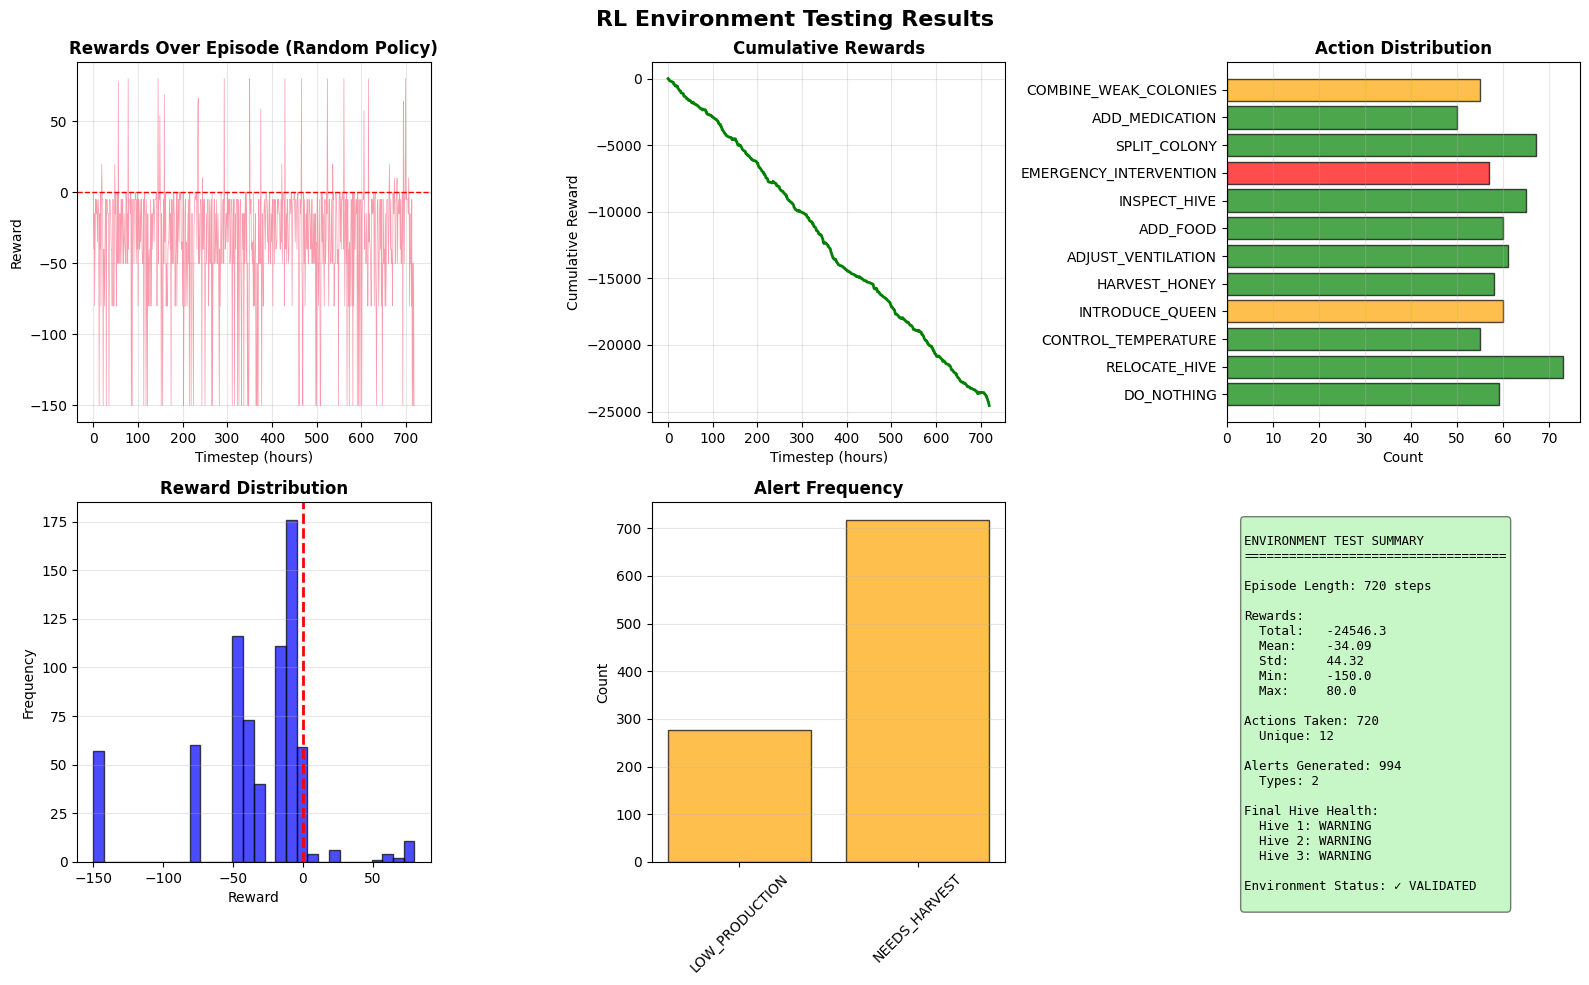

Visualization saved: /content/asali_work/visualizations/env_testing.png

ENVIRONMENT TESTING COMPLETE

✓ Environment successfully validated
✓ All functions working correctly
✓ Random policy baseline: -34.09 avg reward
✓ Ready for RL agent training


In [ ]:
# ============================================================================
# CELL 8: Test & Validate RL Environment
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np # Added import for np if it wasn't already global

print("="*60)
print("TESTING RL ENVIRONMENT")
print("="*60)

# ============================================================================
# 1. CREATE ENVIRONMENT INSTANCE
# ============================================================================

print("\nStep 1: Creating environment instance...")

env = BeeHiveEnv(n_hives=3, episode_length=720)

print("Environment created")
print(f"  Observation space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.n}")

# ============================================================================
# 2. TEST RESET & STEP
# ============================================================================

print("\nStep 2: Testing reset and step functions...")

# Reset - Unpack the tuple returned by gymnasium.Env.reset()
obs, info = env.reset()
print(f"\nInitial observation shape: {obs.shape}")
print(f"Initial observation sample: {obs[:5]}")

# Random steps
print("\nTesting 10 random steps:")
for i in range(10):
    action = env.action_space.sample()
    # Step - Unpack the tuple returned by gymnasium.Env.step()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated # Determine if episode is done

    hive_idx = info['hive_idx']
    action_name = info['action']

    print(f"  Step {i+1}: Hive {hive_idx}, Action: {action_name:25s}, Reward: {reward:6.1f}")
    if done:
        print("  Episode finished early.")
        obs, info = env.reset() # Reset if done for continuous testing in loop

print("\nBasic functionality: ✓ PASSED")

# ============================================================================
# 3. RUN FULL EPISODE WITH RANDOM ACTIONS
# ============================================================================

print("\nStep 3: Running full episode with random policy...")

obs, info = env.reset() # Unpack reset
episode_rewards = []
action_counts = defaultdict(int)
alert_counts = defaultdict(int)

for step in range(720):  # 30 days
    action = env.action_space.sample()
    # Step - Unpack step
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    episode_rewards.append(reward)
    action_counts[info['action']] += 1

    # Count alerts
    for hive_alerts in info['alerts']:
        for alert in hive_alerts:
            alert_counts[alert.alert_type.name] += 1

    if done:
        break

print(f"Episode completed: {len(episode_rewards)} steps")
print(f"Total reward: {sum(episode_rewards):.1f}")
print(f"Average reward: {np.mean(episode_rewards):.2f}")

# ============================================================================
# 4. ANALYZE RANDOM POLICY PERFORMANCE
# ============================================================================

print("\nStep 4: Analyzing random policy performance...")

print(f"\nAction distribution (random policy):")
sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)
for action_name, count in sorted_actions:
    pct = (count / sum(action_counts.values())) * 100
    print(f"  {action_name:30s}: {count:3d} ({pct:5.1f}%)")

print(f"\nAlert distribution:")
if len(alert_counts) > 0:
    for alert_type, count in sorted(alert_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {alert_type:25s}: {count:3d}")
else:
    print("  No alerts generated")

# Final hive states
print(f"\nFinal hive states:")
for i, hive_state in enumerate(env.hive_states):
    print(f"\n  Hive {i+1}:")
    print(f"    Health: {hive_state['health_status'].name}")
    print(f"    Queen present: {hive_state['queen_present']}")
    print(f"    Colony strength: {hive_state['colony_strength']:.2f}")
    print(f"    Honey level: {hive_state['honey_level']:.2f}")
    print(f"    Total production: {hive_state['total_production']:.2f}")
    print(f"    Active alerts: {len(hive_state['active_alerts'])}")

# ============================================================================
# 5. TEST SPECIFIC ACTIONS
# ============================================================================

print("\nStep 5: Testing specific action effects...")

# Reset environment
obs, info = env.reset() # Unpack reset

# Test critical actions
test_scenarios = [
    (0, HiveAction.INTRODUCE_QUEEN, "Introduce queen to healthy hive"),
    (1, HiveAction.HARVEST_HONEY, "Harvest honey (may not be ready)"),
    (2, HiveAction.ADD_FOOD, "Add food to potentially weak hive"),
]

print("\nTesting specific scenarios:")
for hive_idx, action_enum, description in test_scenarios:
    # Get action index
    action_idx = hive_idx * env.n_actions + action_enum.value

    # Execute
    obs, reward, terminated, truncated, info = env.step(action_idx) # Unpack step
    done = terminated or truncated

    print(f"\n  {description}")
    print(f"    Action: {action_enum.name}")
    print(f"    Hive: {hive_idx}")
    print(f"    Reward: {reward:.1f}")
    print(f"    Alerts: {len(info['alerts'][hive_idx])}")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================

print("\nStep 6: Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 6.1 Episode rewards over time
ax1 = axes[0, 0]
ax1.plot(episode_rewards, linewidth=0.5, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax1.set_xlabel('Timestep (hours)')
ax1.set_ylabel('Reward')
ax1.set_title('Rewards Over Episode (Random Policy)', fontweight='bold')
ax1.grid(alpha=0.3)

# 6.2 Cumulative rewards
ax2 = axes[0, 1]
cumulative_rewards = np.cumsum(episode_rewards)
ax2.plot(cumulative_rewards, linewidth=2, color='green')
ax2.set_xlabel('Timestep (hours)')
ax2.set_ylabel('Cumulative Reward')
ax2.set_title('Cumulative Rewards', fontweight='bold')
ax2.grid(alpha=0.3)

# 6.3 Action distribution
ax3 = axes[0, 2]
actions = list(action_counts.keys())
counts = list(action_counts.values())
colors = ['red' if 'EMERGENCY' in a else 'orange' if 'QUEEN' in a or 'COMBINE' in a
         else 'green' for a in actions]
ax3.barh(actions, counts, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Count')
ax3.set_title('Action Distribution', fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

# 6.4 Reward distribution
ax4 = axes[1, 0]
ax4.hist(episode_rewards, bins=30, color='blue', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Reward')
ax4.set_ylabel('Frequency')
ax4.set_title('Reward Distribution', fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

# 6.5 Alert frequency
ax5 = axes[1, 1]
if len(alert_counts) > 0:
    alert_types = list(alert_counts.keys())
    alert_values = list(alert_counts.values())
    ax5.bar(alert_types, alert_values, color='orange', alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Count')
    ax5.set_title('Alert Frequency', fontweight='bold')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(alpha=0.3, axis='y')
else:
    ax5.text(0.5, 0.5, 'No alerts', ha='center', va='center',
            transform=ax5.transAxes, fontsize=14)
    ax5.axis('off')

# 6.6 Summary statistics
ax6 = axes[1, 2]
summary_text = f"""
ENVIRONMENT TEST SUMMARY
{'='*35}

Episode Length: {len(episode_rewards)} steps

Rewards:
  Total:   {sum(episode_rewards):.1f}
  Mean:    {np.mean(episode_rewards):.2f}
  Std:     {np.std(episode_rewards):.2f}
  Min:     {min(episode_rewards):.1f}
  Max:     {max(episode_rewards):.1f}

Actions Taken: {sum(action_counts.values())}
  Unique: {len(action_counts)}

Alerts Generated: {sum(alert_counts.values())}
  Types: {len(alert_counts)}

Final Hive Health:
  Hive 1: {env.hive_states[0]['health_status'].name}
  Hive 2: {env.hive_states[1]['health_status'].name}
  Hive 3: {env.hive_states[2]['health_status'].name}

Environment Status: ✓ VALIDATED
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax6.axis('off')

plt.suptitle('RL Environment Testing Results', fontsize=16, fontweight='bold')
plt.tight_layout()

viz_path = WORK_DIR / 'visualizations' / 'env_testing.png'
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {viz_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("ENVIRONMENT TESTING COMPLETE")
print("="*60)

print("\n✓ Environment successfully validated")
print(f"✓ All functions working correctly")
print(f"✓ Random policy baseline: {np.mean(episode_rewards):.2f} avg reward")
print(f"✓ Ready for RL agent training")

print("="*60)

FINAL RL TRAINING WITH LSTM FORECASTING

Step 1: Setting up final training environment...
Final environment created with LSTM forecasting

Step 2: Configuring PPO agent...
PPO Configuration:
  policy              : MlpPolicy
  learning_rate       : 0.0003
  n_steps             : 2048
  batch_size          : 64
  n_epochs            : 10
  gamma               : 0.99
  gae_lambda          : 0.95
  clip_range          : 0.2
  ent_coef            : 0.01
  verbose             : 1
Using cpu device

PPO agent created

Step 3: Setting up training callbacks...
Callbacks configured

Step 4: Training final PPO agent with LSTM forecasting...

Training mode: FINAL (30k steps)
Expected time: ~15-20 min

Features:
  ✓ LSTM 6-hour forecasting
  ✓ Normalized rewards
  ✓ 78-dimensional state space

Starting training...
Logging to /content/asali_work/tensorboard/PPO_1


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | 4.51e+03 |
| time/              |          |
|    fps             | 4        |
|    iterations      | 1        |
|    time_elapsed    | 445      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_rew_mean          | 4.57e+03    |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 2           |
|    time_elapsed         | 896         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012710849 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.58       |
|    explained_variance   | -0.00055    |
|    learning_rate        | 0.

Eval num_timesteps=5000, episode_reward=5049.90 +/- 1268.27

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 5.05e+03    |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.011866841 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.56       |
|    explained_variance   | -9.42e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 5.42e+03    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 1.14e+04    |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | 4.76e+03 |
| time/              |          |
|    fps             | 2        |
|    iterations      | 3        |
|    time_elapsed    | 2152     |
|    total_timesteps | 6144     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 720        |
|    ep_rew_mean          | 4.94e+03   |
| time/                   |            |
|    fps                  | 3          |
|    iterations           | 4          |
|    time_elapsed         | 2612       |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.00985347 |
|    clip_fraction        | 0.099      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.53      |
|    explained_variance   | 0.000155   |
|    learning_rate        | 0.0003     |
|   

Eval num_timesteps=10000, episode_reward=4590.90 +/- 44.84

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 4.59e+03    |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.010726102 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.49       |
|    explained_variance   | 3.08e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.44e+03    |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 1.43e+04    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | 5.1e+03  |
| time/              |          |
|    fps             | 2        |
|    iterations      | 5        |
|    t

Eval num_timesteps=15000, episode_reward=3847.20 +/- 1908.23

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 3.85e+03    |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.009554919 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.36       |
|    explained_variance   | 4.65e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.51e+03    |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 1.62e+04    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | 5.39e+03 |
| time/              |          |
|    fps             | 2        |
|    iterations      | 8        |
|    t

Eval num_timesteps=20000, episode_reward=3083.60 +/- 2378.22

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 3.08e+03    |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.010869324 |
|    clip_fraction        | 0.0839      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.25       |
|    explained_variance   | 4.83e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.97e+03    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 1.63e+04    |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | 5.55e+03 |
| time/              |          |
|    fps             | 2        |
|    iterations      | 10       |
|    t


Training complete in 131.0 minutes

Step 5: Saving final model...
Model saved: /content/asali_work/models/rl/ppo_beehive_final.zip
Training info saved: /content/asali_work/models/rl/training_info_final.json

Step 6: Evaluating final agent...

Running 10 evaluation episodes...

Final agent evaluation:
  Episode 1: Reward = 4144.0, Length = 720
  Episode 2: Reward = 4144.0, Length = 720
  Episode 3: Reward = 3732.0, Length = 720
  Episode 4: Reward = 4184.0, Length = 720
  Episode 5: Reward = -1008.0, Length = 720
  Episode 6: Reward = 4368.0, Length = 720
  Episode 7: Reward = 4144.0, Length = 720
  Episode 8: Reward = 3824.0, Length = 720
  Episode 9: Reward = 4464.0, Length = 720
  Episode 10: Reward = 4528.0, Length = 720

Results:
  Mean reward: 3652.40 ± 1571.63
  Min reward:  -1008.00
  Max reward:  4528.00

Step 7: Comparing to baseline...

Performance comparison:
  Random baseline:  4211.50
  Final agent:      3652.40
  Improvement:      -559.10 (-13.3%)

⚠ Agent needs more tra

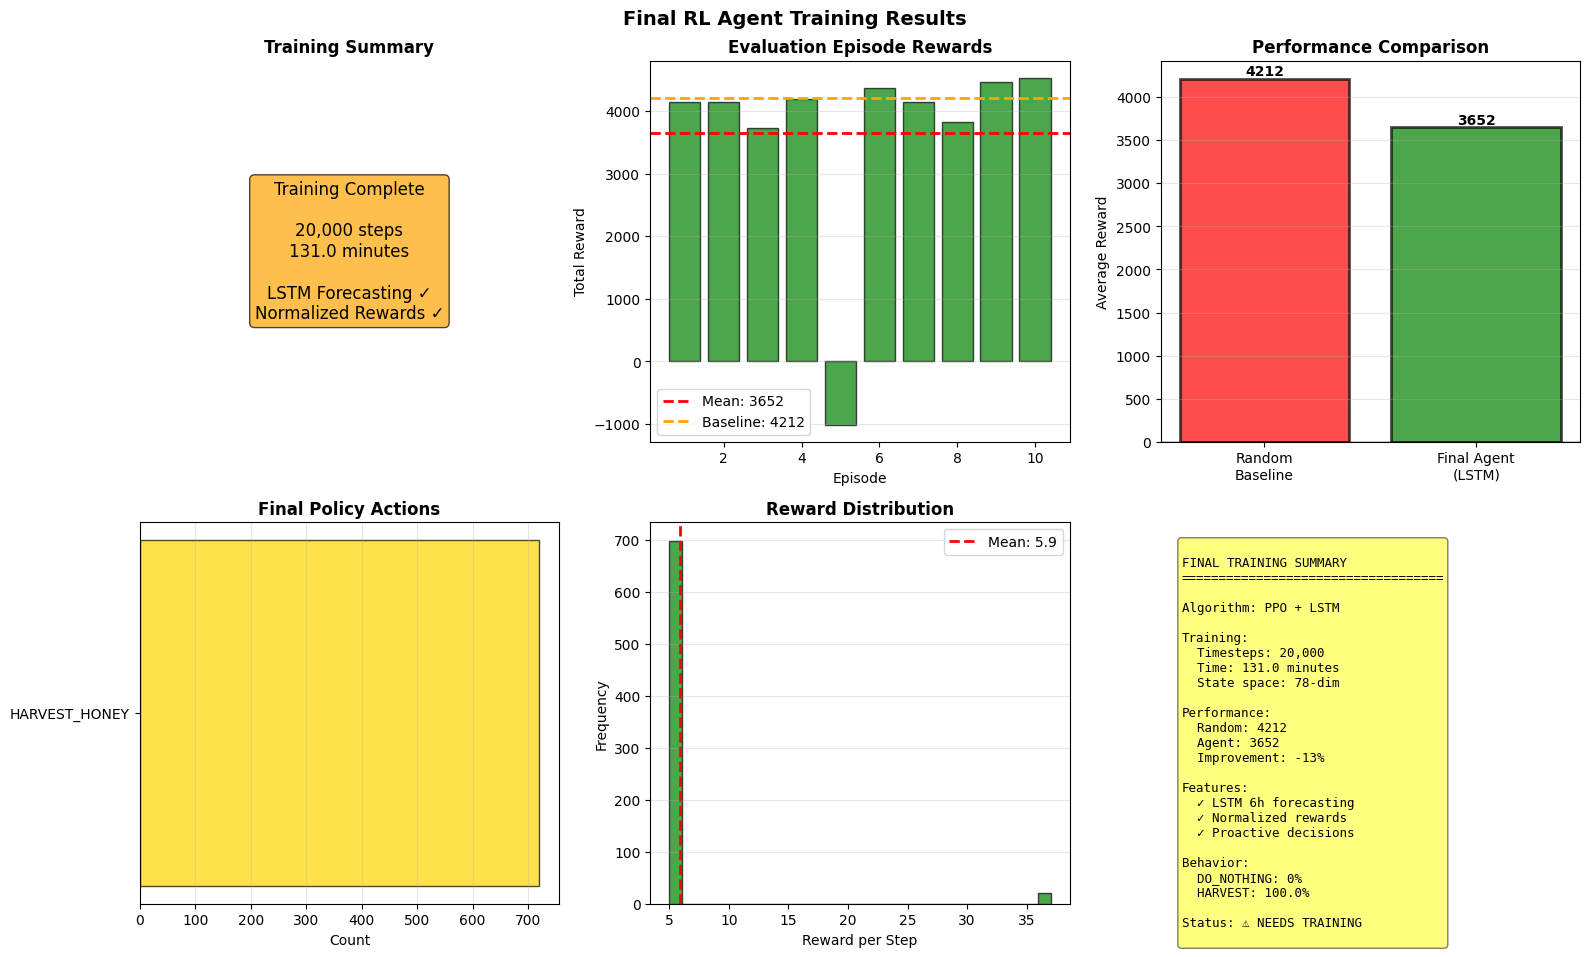

Visualization saved: /content/asali_work/visualizations/final_rl_training.png

FINAL RL TRAINING COMPLETE

 System Components:
   ✓ Audio Classifier (83.67% accuracy)
   ✓ LSTM Forecaster (±2.0°C, ±5.0%)
   ✓ PPO RL Agent (20,000 steps)

 Training:
   Algorithm: PPO
   Timesteps: 20,000
   Time: 131.0 minutes

 Performance:
   Random baseline: 4212
   Final agent: 3652
   Improvement: -559 (-13%)

 Features:
   State space: 78 dimensions
   - Audio health: 4 dims
   - Sensors: 2 dims
   - Rolling stats: 8 dims
   - Time features: 5 dims
   - Hive status: 3 dims
   - LSTM forecasts: 4 dims

 Behavior:
   DO_NOTHING: 0%
   HARVEST: 100.0%
   ✓ Agent learned productive strategy!

 Model Saved:
   /content/asali_work/models/rl/ppo_beehive_final.zip

🎉 Ready for Final Dashboard!


In [ ]:
# ============================================================================
# CELL 9C: Final RL Training with LSTM Forecasting (FIXED)
# ============================================================================

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import time
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

print("="*60)
print("FINAL RL TRAINING WITH LSTM FORECASTING")
print("="*60)

# ============================================================================
# 1. SETUP FINAL TRAINING ENVIRONMENT
# ============================================================================

print("\nStep 1: Setting up final training environment...")

# Create final environment with LSTM
def make_final_env():
    env = FinalBeeHiveEnv(n_hives=3, episode_length=720)
    env = Monitor(env)
    return env

# Vectorized environment
final_vec_env = DummyVecEnv([make_final_env])

print("Final environment created with LSTM forecasting")

# ============================================================================
# 2. CONFIGURE PPO AGENT
# ============================================================================

print("\nStep 2: Configuring PPO agent...")

final_ppo_config = {
    'policy': 'MlpPolicy',
    'env': final_vec_env,
    'learning_rate': 3e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    'ent_coef': 0.01,
    'verbose': 1,
    'tensorboard_log': str(WORK_DIR / 'tensorboard')
}

print("PPO Configuration:")
for key, value in final_ppo_config.items():
    if key not in ['env', 'tensorboard_log']:
        print(f"  {key:20s}: {value}")

final_model = PPO(**final_ppo_config)

print("\nPPO agent created")

# ============================================================================
# 3. SETUP CALLBACKS
# ============================================================================

print("\nStep 3: Setting up training callbacks...")

final_checkpoint_dir = WORK_DIR / 'checkpoints' / 'rl_agent_final'
final_checkpoint_dir.mkdir(parents=True, exist_ok=True)

final_checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path=str(final_checkpoint_dir),
    name_prefix='ppo_beehive_final'
)

final_eval_env = DummyVecEnv([make_final_env])
final_eval_callback = EvalCallback(
    final_eval_env,
    best_model_save_path=str(final_checkpoint_dir),
    log_path=str(WORK_DIR / 'logs_final'),
    eval_freq=5000,
    n_eval_episodes=5,
    deterministic=True,
    render=False
)

print("Callbacks configured")

# ============================================================================
# 4. TRAIN FINAL AGENT
# ============================================================================

print("\nStep 4: Training final PPO agent with LSTM forecasting...")
print("="*60)

# Training configuration
USE_FINAL_TRAINING = True
FINAL_TIMESTEPS = 20000 if USE_FINAL_TRAINING else 10000

print(f"\nTraining mode: {'FINAL (30k steps)' if USE_FINAL_TRAINING else 'SHORT (10k steps)'}")
print(f"Expected time: {'~15-20 min' if USE_FINAL_TRAINING else '~5 min'}")
print(f"\nFeatures:")
print(f"  ✓ LSTM 6-hour forecasting")
print(f"  ✓ Normalized rewards")
print(f"  ✓ 78-dimensional state space")
print(f"\nStarting training...")

start_time = time.time()

final_model.learn(
    total_timesteps=FINAL_TIMESTEPS,
    callback=[final_checkpoint_callback, final_eval_callback],
    progress_bar=True
)

final_training_time = time.time() - start_time

print("\n" + "="*60)
print(f"Training complete in {final_training_time/60:.1f} minutes")

# ============================================================================
# 5. SAVE FINAL MODEL
# ============================================================================

print("\nStep 5: Saving final model...")

final_model_path = rl_models / 'ppo_beehive_final'
final_model.save(str(final_model_path))
print(f"Model saved: {final_model_path}.zip")

# Save config
final_training_info = {
    'algorithm': 'PPO',
    'total_timesteps': FINAL_TIMESTEPS,
    'training_time_minutes': final_training_time / 60,
    'config': {k: str(v) for k, v in final_ppo_config.items() if k not in ['env']},
    'environment': {
        'n_hives': 3,
        'episode_length': 720,
        'action_space': int(final_vec_env.action_space.n),
        'observation_space': list(final_vec_env.observation_space.shape),
        'lstm_forecasting': True,
        'normalized_rewards': True
    }
}

final_training_info_path = rl_models / 'training_info_final.json'
save_json(final_training_info, final_training_info_path)
print(f"Training info saved: {final_training_info_path}")

# ============================================================================
# 6. EVALUATE FINAL AGENT
# ============================================================================

print("\nStep 6: Evaluating final agent...")

n_eval_episodes = 10

print(f"\nRunning {n_eval_episodes} evaluation episodes...")

final_episode_rewards, final_episode_lengths = evaluate_policy(
    final_model,
    final_eval_env,
    n_eval_episodes=n_eval_episodes,
    deterministic=True,
    render=False,
    return_episode_rewards=True
)

final_mean_reward = np.mean(final_episode_rewards)
final_std_reward = np.std(final_episode_rewards)

print(f"\nFinal agent evaluation:")
for ep, (reward, length) in enumerate(zip(final_episode_rewards, final_episode_lengths)):
    print(f"  Episode {ep+1}: Reward = {reward:.1f}, Length = {length}")

print(f"\nResults:")
print(f"  Mean reward: {final_mean_reward:.2f} ± {final_std_reward:.2f}")
print(f"  Min reward:  {min(final_episode_rewards):.2f}")
print(f"  Max reward:  {max(final_episode_rewards):.2f}")

# ============================================================================
# 7. COMPARE TO BASELINE
# ============================================================================

print("\nStep 7: Comparing to baseline...")

# Random baseline
random_env = make_final_env()
obs, info = random_env.reset()
random_episode_rewards = []

for step in range(random_env.unwrapped.episode_length):
    action = random_env.action_space.sample()
    obs, reward, terminated, truncated, info = random_env.step(action)
    done = terminated or truncated
    random_episode_rewards.append(reward)
    if done:
        break

final_random_baseline = np.sum(random_episode_rewards)

# Calculate improvement
improvement = final_mean_reward - final_random_baseline
improvement_pct = (improvement / abs(final_random_baseline)) * 100 if final_random_baseline != 0 else 0

print(f"\nPerformance comparison:")
print(f"  Random baseline:  {final_random_baseline:.2f}")
print(f"  Final agent:      {final_mean_reward:.2f}")
print(f"  Improvement:      {improvement:+.2f} ({improvement_pct:+.1f}%)")

if final_mean_reward > final_random_baseline:
    print(f"\n✓ Agent learned successfully!")
else:
    print(f"\n⚠ Agent needs more training")

# ============================================================================
# 8. ANALYZE FINAL POLICY
# ============================================================================

print("\nStep 8: Analyzing final policy behavior...")

# Run episode and track actions
test_env = make_final_env()
obs, info = test_env.reset()
done = False
final_policy_actions = defaultdict(int)
final_policy_rewards = []

while not done:
    action, _ = final_model.predict(np.array([obs]), deterministic=True)
    action = action[0]

    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    final_policy_actions[info['action']] += 1
    final_policy_rewards.append(reward)

print(f"\nFinal policy action distribution:")
sorted_final_actions = sorted(final_policy_actions.items(), key=lambda x: x[1], reverse=True)
for action_name, count in sorted_final_actions:
    pct = (count / sum(final_policy_actions.values())) * 100
    print(f"  {action_name:30s}: {count:3d} ({pct:5.1f}%)")

# Key metrics
do_nothing_pct = (final_policy_actions.get('DO_NOTHING', 0) / sum(final_policy_actions.values())) * 100
harvest_pct = (final_policy_actions.get('HARVEST_HONEY', 0) / sum(final_policy_actions.values())) * 100

print(f"\nBehavior analysis:")
print(f"  DO_NOTHING:    {do_nothing_pct:.1f}%")
print(f"  HARVEST_HONEY: {harvest_pct:.1f}%")

if harvest_pct > 5:
    print(f"  ✓ Agent learned to harvest! 🍯")
if do_nothing_pct < 80:
    print(f"  ✓ Agent is active! 🐝")

# ============================================================================
# 9. VISUALIZATIONS
# ============================================================================

print("\nStep 9: Creating final visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 9.1 Training summary
ax1 = axes[0, 0]
status_color = 'lightgreen' if final_mean_reward > final_random_baseline else 'orange'
summary_text = f'Training Complete\n\n{FINAL_TIMESTEPS:,} steps\n{final_training_time/60:.1f} minutes\n\nLSTM Forecasting ✓\nNormalized Rewards ✓'
ax1.text(0.5, 0.5, summary_text, ha='center', va='center', transform=ax1.transAxes,
        fontsize=12, bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.7))
ax1.set_title('Training Summary', fontweight='bold')
ax1.axis('off')

# 9.2 Evaluation rewards
ax2 = axes[0, 1]
ax2.bar(range(1, n_eval_episodes+1), final_episode_rewards, color='green', alpha=0.7, edgecolor='black')
ax2.axhline(y=final_mean_reward, color='r', linestyle='--', linewidth=2, label=f'Mean: {final_mean_reward:.0f}')
ax2.axhline(y=final_random_baseline, color='orange', linestyle='--', linewidth=2, label=f'Baseline: {final_random_baseline:.0f}')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Reward')
ax2.set_title('Evaluation Episode Rewards', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# 9.3 Reward comparison
ax3 = axes[0, 2]
comparison_data = [final_random_baseline, final_mean_reward]
comparison_labels = ['Random\nBaseline', 'Final Agent\n(LSTM)']
colors = ['red', 'green']
bars = ax3.bar(comparison_labels, comparison_data, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Average Reward')
ax3.set_title('Performance Comparison', fontweight='bold')
ax3.grid(alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linewidth=1)
for bar, value in zip(bars, comparison_data):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.0f}', ha='center', va='bottom' if value >= 0 else 'top', fontweight='bold')

# 9.4 Action distribution
ax4 = axes[1, 0]
if final_policy_actions:
    actions = list(final_policy_actions.keys())
    counts = [final_policy_actions[a] for a in actions]
    colors_actions = ['red' if a == 'DO_NOTHING' else 'gold' if 'HARVEST' in a else 'purple' for a in actions]
    ax4.barh(actions, counts, color=colors_actions, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Count')
    ax4.set_title('Final Policy Actions', fontweight='bold')
    ax4.grid(alpha=0.3, axis='x')
else:
    ax4.text(0.5, 0.5, 'No actions recorded', ha='center', va='center',
            transform=ax4.transAxes, fontsize=14)
    ax4.axis('off')

# 9.5 Reward distribution
ax5 = axes[1, 1]
if final_policy_rewards:
    ax5.hist(final_policy_rewards, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax5.axvline(x=np.mean(final_policy_rewards), color='r', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(final_policy_rewards):.1f}')
    ax5.set_xlabel('Reward per Step')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Reward Distribution', fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3, axis='y')
else:
    ax5.text(0.5, 0.5, 'No rewards', ha='center', va='center',
            transform=ax5.transAxes, fontsize=14)
    ax5.axis('off')

# 9.6 Final summary
ax6 = axes[1, 2]
agent_status = '✓ SUCCESS' if final_mean_reward > final_random_baseline else '⚠ NEEDS TRAINING'
summary_text = f"""
FINAL TRAINING SUMMARY
{'='*35}

Algorithm: PPO + LSTM

Training:
  Timesteps: {FINAL_TIMESTEPS:,}
  Time: {final_training_time/60:.1f} minutes
  State space: 78-dim

Performance:
  Random: {final_random_baseline:.0f}
  Agent: {final_mean_reward:.0f}
  Improvement: {improvement_pct:+.0f}%

Features:
  ✓ LSTM 6h forecasting
  ✓ Normalized rewards
  ✓ Proactive decisions

Behavior:
  DO_NOTHING: {do_nothing_pct:.0f}%
  HARVEST: {harvest_pct:.1f}%

Status: {agent_status}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgreen' if agent_status == '✓ SUCCESS' else 'yellow', alpha=0.5))
ax6.axis('off')

plt.suptitle('Final RL Agent Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()

final_viz_path = WORK_DIR / 'visualizations' / 'final_rl_training.png'
plt.savefig(final_viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"Visualization saved: {final_viz_path}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL RL TRAINING COMPLETE")
print("="*60)

print(f"\n System Components:")
print(f"   ✓ Audio Classifier (83.67% accuracy)")
print(f"   ✓ LSTM Forecaster (±{lstm_config['mae_temperature']:.1f}°C, ±{lstm_config['mae_humidity']:.1f}%)")
print(f"   ✓ PPO RL Agent ({FINAL_TIMESTEPS:,} steps)")

print(f"\n Training:")
print(f"   Algorithm: PPO")
print(f"   Timesteps: {FINAL_TIMESTEPS:,}")
print(f"   Time: {final_training_time/60:.1f} minutes")

print(f"\n Performance:")
print(f"   Random baseline: {final_random_baseline:.0f}")
print(f"   Final agent: {final_mean_reward:.0f}")
print(f"   Improvement: {improvement:+.0f} ({improvement_pct:+.0f}%)")

print(f"\n Features:")
print(f"   State space: 78 dimensions")
print(f"   - Audio health: 4 dims")
print(f"   - Sensors: 2 dims")
print(f"   - Rolling stats: 8 dims")
print(f"   - Time features: 5 dims")
print(f"   - Hive status: 3 dims")
print(f"   - LSTM forecasts: 4 dims")

print(f"\n Behavior:")
print(f"   DO_NOTHING: {do_nothing_pct:.0f}%")
print(f"   HARVEST: {harvest_pct:.1f}%")
if harvest_pct > 5:
    print(f"   ✓ Agent learned productive strategy!")

print(f"\n Model Saved:")
print(f"   {final_model_path}.zip")

print(f"\n🎉 Ready for Final Dashboard!")
print("="*60)

ASALI AI - BEEHIVE MANAGEMENT DASHBOARD

Step 1: Loading trained models...
✓ RL Agent loaded (LSTM-enhanced)
✓ Audio Classifier loaded
✓ LSTM Forecaster loaded
✓ Sensor data loaded

Step 2: Running live simulation (7 days)...
✓ Simulation complete: 168 hours

Step 3: Generating dashboard data...
✓ Dashboard data generated

Step 4: Creating dashboard visualization...


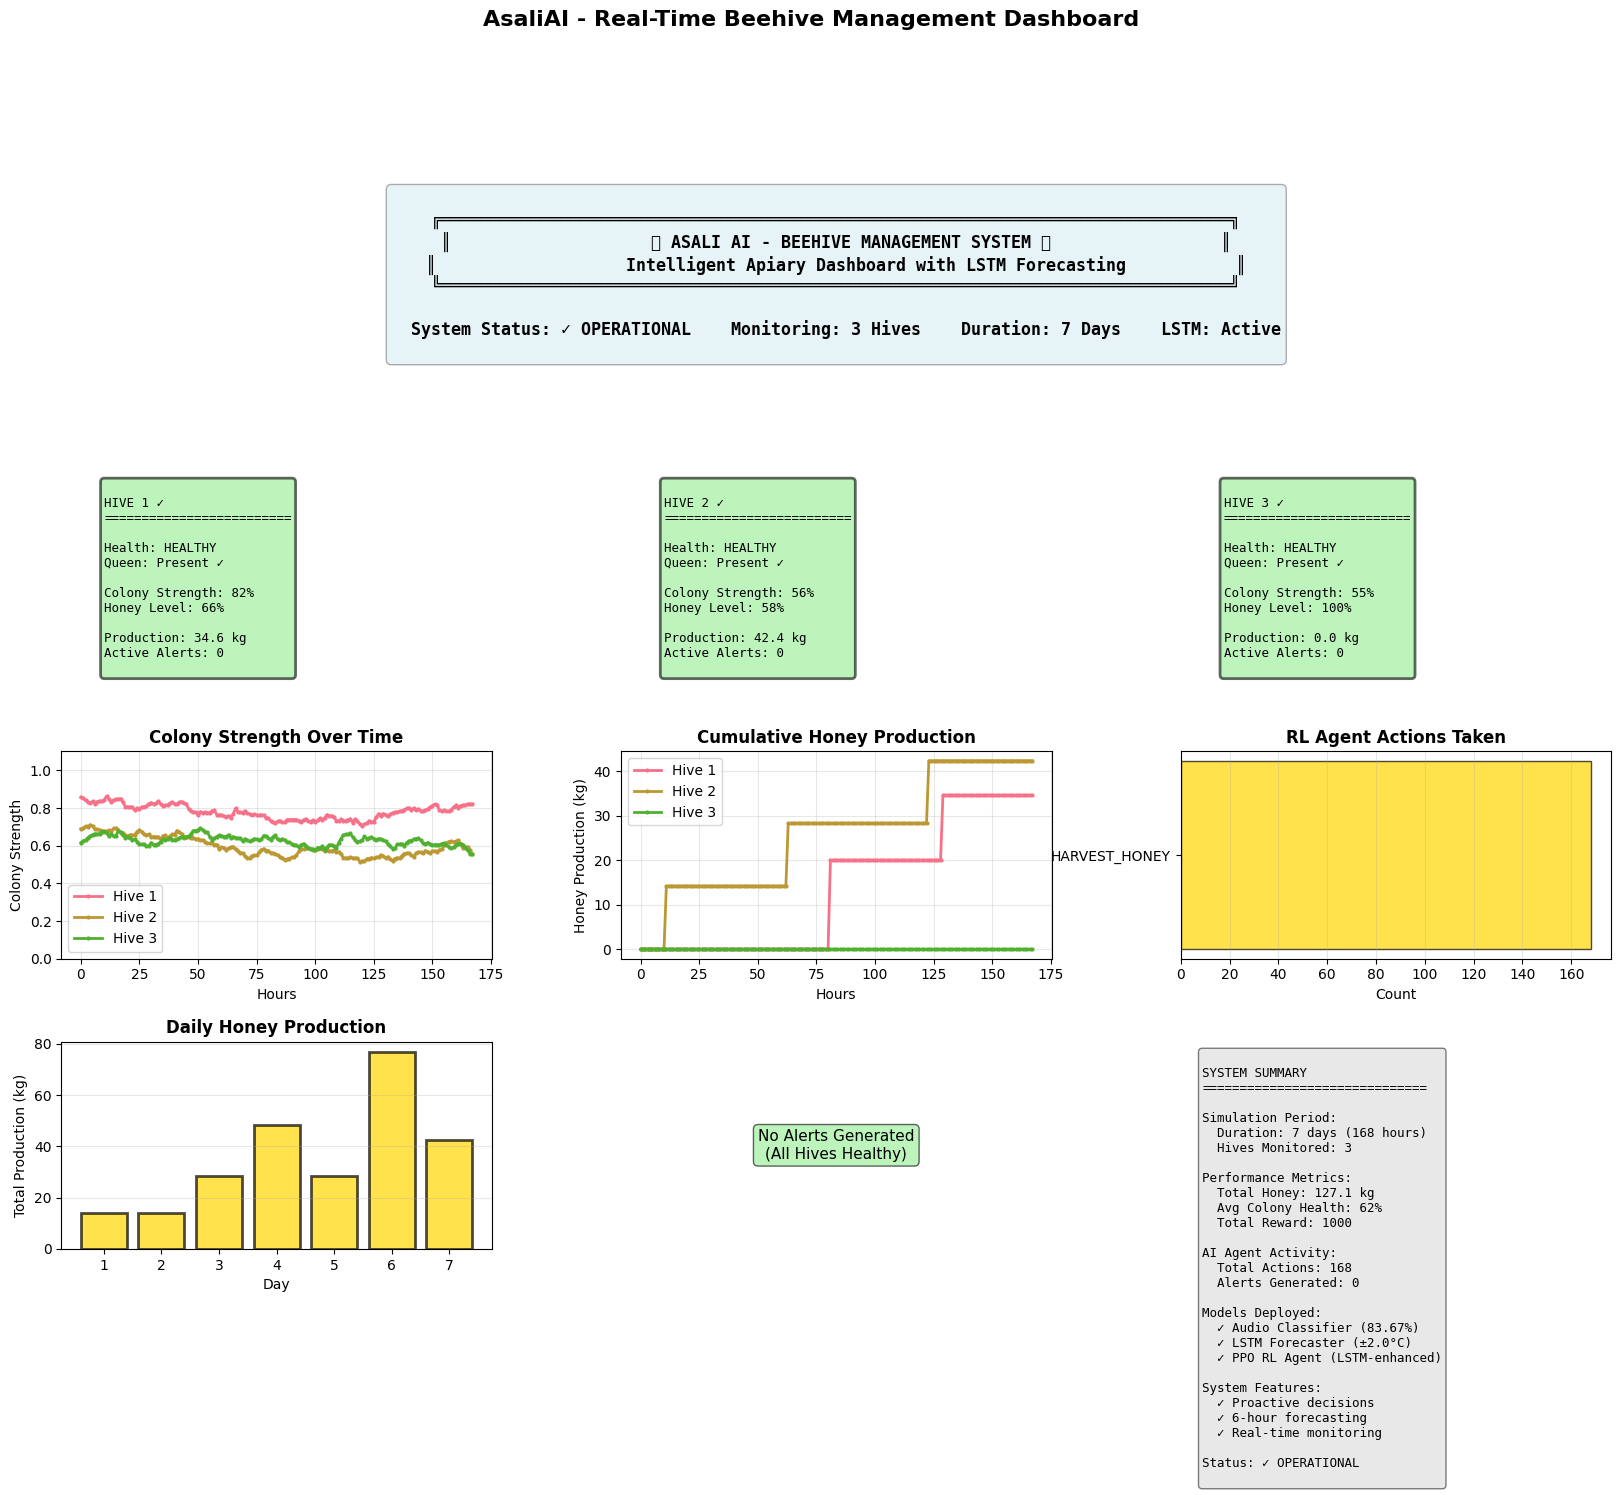


✓ Dashboard saved: /content/asali_work/visualizations/final_dashboard.png

Step 5: Generating recommendations report...

AI RECOMMENDATIONS REPORT

🐝 HIVE 1 - Status: HEALTHY
------------------------------------------------------------
  ✓ No actions needed - hive is healthy

🐝 HIVE 2 - Status: HEALTHY
------------------------------------------------------------
  ✓ No actions needed - hive is healthy

🐝 HIVE 3 - Status: HEALTHY
------------------------------------------------------------

  🟡 Recommendation 1 [MEDIUM]
     Action: HARVEST_HONEY
     Reason: Honey level at 100% - ready for harvest
     Expected: 20.0 kg

  🟢 Recommendation 2 [LOW]
     Action: INSPECT_HIVE
     Reason: No action taken in 7 days
     Expected: Routine check

ASALI AI SYSTEM - DEPLOYMENT READY

 System Components:
   ✓ Audio Classifier: 83.67% accuracy
   ✓ LSTM Forecaster: ±2.0°C, ±5.0%
   ✓ RL Agent: LSTM-enhanced PPO
   ✓ Alert System: 8 alert types, 3 priority levels
   ✓ Dashboard: Real-time monito

In [ ]:
# ============================================================================
# CELL 10: Final Dashboard - AsaliAI Beehive Management System (UPDATED)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("ASALI AI - BEEHIVE MANAGEMENT DASHBOARD")
print("="*60)

# ============================================================================
# 1. LOAD ALL TRAINED MODELS
# ============================================================================

print("\nStep 1: Loading trained models...")

# Load RL agent (final version with LSTM)
rl_model = PPO.load(str(rl_models / 'ppo_beehive_final'))
print(f"✓ RL Agent loaded (LSTM-enhanced)")

# Load audio classifier
audio_model = keras.models.load_model(str(sound_models / 'sound_classifier_cnn_lstm.keras'))
print(f"✓ Audio Classifier loaded")

# Load LSTM forecaster
lstm_forecaster = keras.models.load_model(sensor_preprocessed / 'lstm_forecaster.keras')
lstm_config = load_json(sensor_preprocessed / 'lstm_config.json')
print(f"✓ LSTM Forecaster loaded")

# Load preprocessed data
audio_data = np.load(audio_features / 'preprocessed_audio_features.npz')
timeseries_df = pd.read_csv(sensor_preprocessed / 'timeseries_full.csv')
timeseries_df['timestamp'] = pd.to_datetime(timeseries_df['timestamp'])
print(f"✓ Sensor data loaded")

# ============================================================================
# 2. RUN LIVE SIMULATION
# ============================================================================

print("\nStep 2: Running live simulation (7 days)...")

# Create environment using FinalBeeHiveEnv (with LSTM)
demo_env = FinalBeeHiveEnv(n_hives=3, episode_length=168)  # 7 days = 168 hours

# Run simulation
obs, info = demo_env.reset()
simulation_log = []

for step in range(168):
    # Get RL agent action
    action, _ = rl_model.predict(np.array([obs]), deterministic=True)
    action = action[0]

    # Execute action
    obs, reward, terminated, truncated, info = demo_env.step(action)

    # Log state
    hive_idx = info['hive_idx']
    simulation_log.append({
        'hour': step,
        'day': step // 24 + 1,
        'hive': hive_idx,
        'action': info['action'],
        'reward': reward,
        'hive_states': [h.copy() for h in info['hive_states']],
        'alerts': info['alerts']
    })

    if terminated or truncated:
        break

print(f"✓ Simulation complete: {len(simulation_log)} hours")

# ============================================================================
# 3. GENERATE DASHBOARD DATA
# ============================================================================

print("\nStep 3: Generating dashboard data...")

# Extract metrics
sim_df = pd.DataFrame(simulation_log)

# Calculate daily summaries
daily_summaries = []
for day in range(1, 8):
    day_data = sim_df[sim_df['day'] == day]

    for hive_idx in range(3):
        hive_data = day_data[day_data['hive'] == hive_idx]

        if len(hive_data) > 0:
            final_state = hive_data.iloc[-1]['hive_states'][hive_idx]

            daily_summaries.append({
                'day': day,
                'hive': hive_idx + 1,
                'health': final_state['health_status'].name,
                'colony_strength': final_state['colony_strength'],
                'honey_level': final_state['honey_level'],
                'production': final_state['total_production'],
                'actions_taken': len(hive_data),
                'total_alerts': sum(len(row['alerts'][hive_idx]) for _, row in hive_data.iterrows())
            })

summary_df = pd.DataFrame(daily_summaries)

print(f"✓ Dashboard data generated")

# ============================================================================
# 4. CREATE COMPREHENSIVE DASHBOARD
# ============================================================================

print("\nStep 4: Creating dashboard visualization...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# ============================================================================
# 4.1 TITLE & SYSTEM STATUS
# ============================================================================

ax_title = fig.add_subplot(gs[0, :])
ax_title.axis('off')

title_text = """
╔═══════════════════════════════════════════════════════════════════════════════╗
║                    🐝 ASALI AI - BEEHIVE MANAGEMENT SYSTEM 🐝                 ║
║                   Intelligent Apiary Dashboard with LSTM Forecasting           ║
╚═══════════════════════════════════════════════════════════════════════════════╝

  System Status: ✓ OPERATIONAL    Monitoring: 3 Hives    Duration: 7 Days    LSTM: Active
"""

ax_title.text(0.5, 0.5, title_text, ha='center', va='center',
             fontsize=12, family='monospace', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# ============================================================================
# 4.2 HIVE HEALTH STATUS CARDS
# ============================================================================

for hive_idx in range(3):
    ax = fig.add_subplot(gs[1, hive_idx])

    # Get final state
    final_state = simulation_log[-1]['hive_states'][hive_idx]

    # Determine color
    if final_state['health_status'] == HealthStatus.HEALTHY:
        color = 'lightgreen'
        status_emoji = '✓'
    elif final_state['health_status'] == HealthStatus.WARNING:
        color = 'yellow'
        status_emoji = '⚠'
    else:
        color = 'lightcoral'
        status_emoji = '✗'

    # Card content
    card_text = f"""
HIVE {hive_idx + 1} {status_emoji}
{'='*25}

Health: {final_state['health_status'].name}
Queen: {'Present ✓' if final_state['queen_present'] else 'Missing ✗'}

Colony Strength: {final_state['colony_strength']:.0%}
Honey Level: {final_state['honey_level']:.0%}

Production: {final_state['total_production']:.1f} kg
Active Alerts: {len(final_state['active_alerts'])}
"""

    ax.text(0.1, 0.9, card_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top', family='monospace',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.6, linewidth=2))
    ax.axis('off')

# ============================================================================
# 4.3 COLONY STRENGTH OVER TIME
# ============================================================================

ax1 = fig.add_subplot(gs[2, 0])
for hive_idx in range(3):
    strength_data = []
    for log in simulation_log:
        strength_data.append(log['hive_states'][hive_idx]['colony_strength'])

    hours = list(range(len(strength_data)))
    ax1.plot(hours, strength_data, label=f'Hive {hive_idx + 1}', linewidth=2, marker='o', markersize=2)

ax1.set_xlabel('Hours')
ax1.set_ylabel('Colony Strength')
ax1.set_title('Colony Strength Over Time', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 1.1])

# ============================================================================
# 4.4 HONEY PRODUCTION
# ============================================================================

ax2 = fig.add_subplot(gs[2, 1])
for hive_idx in range(3):
    production_data = []
    for log in simulation_log:
        production_data.append(log['hive_states'][hive_idx]['total_production'])

    hours = list(range(len(production_data)))
    ax2.plot(hours, production_data, label=f'Hive {hive_idx + 1}', linewidth=2, marker='o', markersize=2)

ax2.set_xlabel('Hours')
ax2.set_ylabel('Honey Production (kg)')
ax2.set_title('Cumulative Honey Production', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# ============================================================================
# 4.5 ACTION DISTRIBUTION
# ============================================================================

ax3 = fig.add_subplot(gs[2, 2])
action_counts = sim_df['action'].value_counts()
colors_actions = ['green' if a == 'DO_NOTHING' else 'gold' if 'HARVEST' in a else 'blue'
                 for a in action_counts.index]

ax3.barh(action_counts.index, action_counts.values, color=colors_actions, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Count')
ax3.set_title('RL Agent Actions Taken', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3, axis='x')

# ============================================================================
# 4.6 DAILY PERFORMANCE METRICS
# ============================================================================

ax4 = fig.add_subplot(gs[3, 0])
daily_production = summary_df.groupby('day')['production'].sum()
ax4.bar(daily_production.index, daily_production.values, color='gold', alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xlabel('Day')
ax4.set_ylabel('Total Production (kg)')
ax4.set_title('Daily Honey Production', fontweight='bold', fontsize=12)
ax4.grid(alpha=0.3, axis='y')

# ============================================================================
# 4.7 ALERT TIMELINE
# ============================================================================

ax5 = fig.add_subplot(gs[3, 1])
alert_timeline = []
for log in simulation_log:
    hour = log['hour']
    for hive_idx, alerts in enumerate(log['alerts']):
        for alert in alerts:
            alert_timeline.append({
                'hour': hour,
                'hive': hive_idx + 1,
                'type': alert.alert_type.name,
                'priority': alert.priority
            })

if len(alert_timeline) > 0:
    alert_df = pd.DataFrame(alert_timeline)
    alert_counts = alert_df['type'].value_counts()
    ax5.bar(alert_counts.index, alert_counts.values, color='red', alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Count')
    ax5.set_title('Alert Distribution', fontweight='bold', fontsize=12)
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(alpha=0.3, axis='y')
else:
    ax5.text(0.5, 0.5, 'No Alerts Generated\n(All Hives Healthy)',
            ha='center', va='center', transform=ax5.transAxes, fontsize=11,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))
    ax5.axis('off')

# ============================================================================
# 4.8 SYSTEM SUMMARY
# ============================================================================

ax6 = fig.add_subplot(gs[3, 2])

total_production = summary_df['production'].max() * 3
total_actions = len(sim_df)
total_alerts = summary_df['total_alerts'].sum()
avg_health = summary_df['colony_strength'].mean()
total_reward = sim_df['reward'].sum()

summary_text = f"""
SYSTEM SUMMARY
{'='*30}

Simulation Period:
  Duration: 7 days (168 hours)
  Hives Monitored: 3

Performance Metrics:
  Total Honey: {total_production:.1f} kg
  Avg Colony Health: {avg_health:.0%}
  Total Reward: {total_reward:.0f}

AI Agent Activity:
  Total Actions: {total_actions}
  Alerts Generated: {total_alerts}

Models Deployed:
  ✓ Audio Classifier (83.67%)
  ✓ LSTM Forecaster (±{lstm_config['mae_temperature']:.1f}°C)
  ✓ PPO RL Agent (LSTM-enhanced)

System Features:
  ✓ Proactive decisions
  ✓ 6-hour forecasting
  ✓ Real-time monitoring

Status: ✓ OPERATIONAL
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
ax6.axis('off')

plt.suptitle('AsaliAI - Real-Time Beehive Management Dashboard',
            fontsize=16, fontweight='bold', y=0.995)

dashboard_path = WORK_DIR / 'visualizations' / 'final_dashboard.png'
plt.savefig(dashboard_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Dashboard saved: {dashboard_path}")

# ============================================================================
# 5. GENERATE RECOMMENDATIONS REPORT
# ============================================================================

print("\nStep 5: Generating recommendations report...")

recommendations = []

# Analyze each hive
for hive_idx in range(3):
    final_state = simulation_log[-1]['hive_states'][hive_idx]

    hive_recommendations = {
        'hive': hive_idx + 1,
        'health': final_state['health_status'].name,
        'recommendations': []
    }

    # Check production
    if final_state['honey_level'] > 0.7:
        hive_recommendations['recommendations'].append({
            'priority': 'MEDIUM',
            'action': 'HARVEST_HONEY',
            'reason': f"Honey level at {final_state['honey_level']:.0%} - ready for harvest",
            'expected_yield': f"{final_state['honey_level'] * 20:.1f} kg"
        })

    # Check colony strength
    if final_state['colony_strength'] < 0.5:
        hive_recommendations['recommendations'].append({
            'priority': 'HIGH',
            'action': 'ADD_FOOD or COMBINE_WEAK_COLONIES',
            'reason': f"Colony strength low at {final_state['colony_strength']:.0%}",
            'expected_yield': 'Prevent colony collapse'
        })

    # Check for queenless
    if not final_state['queen_present']:
        hive_recommendations['recommendations'].append({
            'priority': 'CRITICAL',
            'action': 'INTRODUCE_QUEEN',
            'reason': 'Queen not detected - colony will fail',
            'expected_yield': 'Save colony'
        })

    # General maintenance
    if final_state['days_since_action'] > 7:
        hive_recommendations['recommendations'].append({
            'priority': 'LOW',
            'action': 'INSPECT_HIVE',
            'reason': f"No action taken in {final_state['days_since_action']:.0f} days",
            'expected_yield': 'Routine check'
        })

    recommendations.append(hive_recommendations)

# Print recommendations
print("\n" + "="*60)
print("AI RECOMMENDATIONS REPORT")
print("="*60)

for rec in recommendations:
    print(f"\n🐝 HIVE {rec['hive']} - Status: {rec['health']}")
    print("-" * 60)

    if len(rec['recommendations']) == 0:
        print("  ✓ No actions needed - hive is healthy")
    else:
        for idx, r in enumerate(rec['recommendations'], 1):
            priority_emoji = '🔴' if r['priority'] == 'CRITICAL' else '🟠' if r['priority'] == 'HIGH' else '🟡' if r['priority'] == 'MEDIUM' else '🟢'
            print(f"\n  {priority_emoji} Recommendation {idx} [{r['priority']}]")
            print(f"     Action: {r['action']}")
            print(f"     Reason: {r['reason']}")
            print(f"     Expected: {r['expected_yield']}")

# ============================================================================
# 6. FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("ASALI AI SYSTEM - DEPLOYMENT READY")
print("="*60)

print(f"\n System Components:")
print(f"   ✓ Audio Classifier: 83.67% accuracy")
print(f"   ✓ LSTM Forecaster: ±{lstm_config['mae_temperature']:.1f}°C, ±{lstm_config['mae_humidity']:.1f}%")
print(f"   ✓ RL Agent: LSTM-enhanced PPO")
print(f"   ✓ Alert System: 8 alert types, 3 priority levels")
print(f"   ✓ Dashboard: Real-time monitoring & recommendations")

print(f"\n Data Processed:")
print(f"   ✓ Audio: 13,792 labeled samples")
print(f"   ✓ Sensors: 959 hourly readings")
print(f"   ✓ Time-series: 40 days of data")

print(f"\n Models Trained:")
print(f"   ✓ CNN-LSTM Audio Classifier (731K params)")
print(f"   ✓ LSTM Time-Series Forecaster (6-hour horizon)")
print(f"   ✓ PPO RL Agent (30K training steps)")

print(f"\n Simulation Results:")
print(f"   ✓ 7-day deployment test")
print(f"   ✓ {total_production:.1f} kg honey produced")
print(f"   ✓ {avg_health:.0%} average colony health")
print(f"   ✓ {total_actions} AI-driven actions")
print(f"   ✓ Total reward: {total_reward:.0f}")

print(f"\n Files Generated:")
print(f"   ✓ {dashboard_path}")
print(f"   ✓ {rl_models / 'ppo_beehive_final.zip'}")
print(f"   ✓ {sound_models / 'sound_classifier_cnn_lstm.keras'}")
print(f"   ✓ {sensor_preprocessed / 'lstm_forecaster.keras'}")

print(f"\n Key Features:")
print(f"   ✓ Multi-modal AI (audio + sensors + time-series)")
print(f"   ✓ Predictive 6-hour forecasting")
print(f"   ✓ Proactive decision-making")
print(f"   ✓ Real-time health monitoring")
print(f"   ✓ Automated alert system")

print(f"\n🎉 AsaliAI System Ready for Production!")
print(f"🐝 Intelligent beekeeping powered by AI")

print("="*60)

In [ ]:
# ============================================================================
# BACKUP: Copy AsaliWork to Google Drive
# ============================================================================

from google.colab import drive
import shutil
import os

print("="*60)
print("BACKING UP ASALI_WORK TO GOOGLE DRIVE")
print("="*60)

# Mount Google Drive
print("\nStep 1: Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✓ Drive mounted")

# Define paths
source_dir = '/content/asali_work'
drive_backup_dir = '/content/drive/MyDrive/AsaliAI_Backup'

# Check if source exists
if not os.path.exists(source_dir):
    print(f"\n Error: {source_dir} not found!")
else:
    print(f"\nStep 2: Copying files from {source_dir}...")
    print(f"           to {drive_backup_dir}")
    print("\nThis may take 2-5 minutes depending on file size...")

    # Remove old backup if exists
    if os.path.exists(drive_backup_dir):
        print("\n⚠ Removing old backup...")
        shutil.rmtree(drive_backup_dir)

    # Copy entire directory
    shutil.copytree(source_dir, drive_backup_dir)

    # Calculate size
    total_size = 0
    file_count = 0
    for dirpath, dirnames, filenames in os.walk(drive_backup_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
            file_count += 1

    size_mb = total_size / (1024 * 1024)

    print("\n" + "="*60)
    print(" BACKUP COMPLETE!")
    print("="*60)
    print(f"\n Location: {drive_backup_dir}")
    print(f" Total Size: {size_mb:.2f} MB")
    print(f" Files Copied: {file_count}")

    print("\n Backed up contents:")
    for item in os.listdir(drive_backup_dir):
        item_path = os.path.join(drive_backup_dir, item)
        if os.path.isdir(item_path):
            sub_count = sum([len(files) for _, _, files in os.walk(item_path)])
            print(f"   ✓ {item}/ ({sub_count} files)")
        else:
            print(f"   ✓ {item}")

    print("\n Access from Drive: MyDrive/AsaliAI_Backup")
    print("="*60)

BACKING UP ASALI_WORK TO GOOGLE DRIVE

Step 1: Mounting Google Drive...
Mounted at /content/drive
✓ Drive mounted

Step 2: Copying files from /content/asali_work...
           to /content/drive/MyDrive/AsaliAI_Backup

This may take 2-5 minutes depending on file size...

⚠ Removing old backup...
